# Prédicition de la variable de la consommation d'énergie des bâtiments de SEATTLE

In [1]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import scipy
import scipy.stats
from pathlib import Path
import timeit
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import FETCH_LOAD_DATAS
from TUNING_SUPERVISED_MODELS import *

##### Paramètres généraux d'affichage et fonction de sauvegarde des visualisations

In [2]:
SEED = 49

In [3]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)

plt.rcParams['figure.figsize'] = [10, 8]

In [4]:
IMAGES_PATH = Path() / "img" / "prediction_conso"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"prediction_conso - {fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

##### Chargements des données et initialisation des variables utiles

In [5]:
data = pd.read_csv("datasets/df_EDA.csv")
df = data.copy()

Nous allons dans un premier temps chercher à optimiser un modèle nous permettant d'obtenir les meilleures performances possibles pour la prédiction de notre valeur cible de consomation d'énergie, sans la variable **ENRGYSTARScore**, puis nous verrons en la rajoutant à notre jeu de données si elle permet d'atteindre de meilleurs résulats.

In [6]:
df.head()

LargestPropertyUseType Neighborhood PrimaryPropertyType  \
0                  Hotel     DOWNTOWN               Hotel   
1                  Hotel     DOWNTOWN               Hotel   
2                  Hotel     DOWNTOWN               Hotel   
3                  Hotel     DOWNTOWN               Hotel   
4                  Hotel     DOWNTOWN               Hotel   

  SecondLargestPropertyUseType ThirdLargestPropertyUseType  \
0                         None                        None   
1                      Parking                  Restaurant   
2                         None                        None   
3                         None                        None   
4                      Parking               Swimming Pool   

   LargestPropertyUseTypeGFA  PropertyGFATotal  \
0                    88434.0             88434   
1                    83880.0            103566   
2                   756493.0            956110   
3                    61320.0             61320   
4                   123445.0            175580   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              0.0                             0.0   
1                          15064.0                          4622.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                          68009.0                             0.0   

   ENERGYSTARScore  Latitude  Longitude  NumberofBuildings  NumberofFloors  \
0             60.0  47.61220 -122.33799                1.0              12   
1             61.0  47.61317 -122.33393                1.0              11   
2             43.0  47.61393 -122.33810                1.0              41   
3             56.0  47.61412 -122.33664                1.0              10   
4             75.0  47.61375 -122.34047                1.0              18   

   PropertyGFABuilding(s)  PropertyGFAParking  YearBuilt  SiteEnergyUse(kBtu)  \
0                   88434                   0       1927            7226362.5   
1                   88502               15064       1996            8387933.0   
2                  759392              196718       1969           72587024.0   
3                   61320                   0       1926            6794584.0   
4                  113580               62000       1980           14172606.0   

   TotalGHGEmissions  
0             249.98  
1             295.86  
2            2089.28  
3             286.43  
4             505.01

In [7]:
df.drop(columns='ENERGYSTARScore', inplace=True)
df.drop(columns='TotalGHGEmissions', inplace=True)

In [8]:
conso = 'SiteEnergyUse(kBtu)'

cat_features = ['Neighborhood', 'PrimaryPropertyType',
                'LargestPropertyUseType',
                'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType']

num_features = ['LargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'NumberofBuildings', 
                     'NumberofFloors', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal',
                     'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'YearBuilt']

log_features = ['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA', 
                'ThirdLargestPropertyUseTypeGFA']

std_features = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
                'PropertyGFAParking', 'YearBuilt']

In [9]:
df = df[num_features+cat_features+[conso]]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=conso),df[conso], test_size=0.2, random_state=SEED)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [11]:
cat_features_ind = [X_train.columns.get_loc(ft) for ft in cat_features]
numerical_features_ind = [X_train.columns.get_loc(ft) for ft in num_features]
log_features_ind = [X_train.columns.get_loc(ft) for ft in log_features]
std_features_ind = [X_train.columns.get_loc(ft) for ft in std_features]

# Première estimation de performance

### Métriques de performance

Pour notre problématiques, les métriques de performances auxquelles nous allons être attentifs sont la **RMSE**, la **RMSLE** et la **MAE** plus que le score **R²**.

En effet ce dernier peut être interprété comme la proportion de variance dans le jeu de données que notre modèle entraîné est capable d'expliquer, et dépend donc beaucoup du jeu de données. Nous lui préférerons les mesures de performances neutres citées ci-avant, ainsi que le **score R² ajusté** qui permet de mieux quantifier la robustesse de notre modèle (la valeur de la mesure **R² ajusté** est toujours inférieure ou égale à la valeur de **R²**).

### Utilisation de la librairie PyCaret pour nos estimations de performance

Nous allons lancé une batterie de modèles standards avec leurs paramètres par défaut sur notre jeu de données brut afin d'avoir une **performance de base** à laquelle nous allons comparer la performance du modèle dont nous ajusterons les hyperparamètres après avoir réalisé un travail spécifique sur les variables (**feature engineering**).

Pour cela, nous utilisons la librairie **PyCaret** (https://github.com/pycaret/pycaret) qui est la version Python de la librairie **Caret** pour **R** (**C**lassification **A**nd **RE**gression **T**raining) pour se faire une idée des modèles qui sont pertinents pour répondre à notre problématique de régression.

Voici les caractéristiques des entraînements de modèles réalisés par **PyCaret**:

   1. **OneHotEncoding** sur les variables catégorielles
   2. Les variables numériques sont normalisées (les **SVM** et **KNN** sont sensibles aux différences d'échelle)
   3. Aucune sélection de variable ni élimination de la multicollinéarité entre elles
   4. Les résultats sont une moyenne suite à une validation croisée simple à 10 passes (K-Fold)

In [12]:
df_train = X_train.copy()
df_train['TARGET'] = y_train

In [13]:
s = setup(df_train, target = 'TARGET', normalize=True, session_id=SEED, silent=True)

best_models = compare_models(sort='RMSE', exclude=['lar', 'llar'])

# Traitement des valeurs aberrantes

Nous choisissons d'utiliser le critère de l'**inter-quartile** pour traiter les valeurs aberrantes, car nous n'avons pas besoins de faire d'hypothèses sur la distribution des variables.

Nous allons pour cela créer une fonction qui fera partie du processus global de pré-traitement des données avant l'évaluation de modèles pouvant potentiellement répondre à notre problématique, et nous pourrons ainsi observer l'impact de la présence de cette étape de traitement sur les performances des modèles (d'autant plus que cette étape nous prive d'un nombre important d'observations, **près de 60%**, voir ci-après).

In [14]:
def remove_outliers_IR(data):
    df = data.copy()
    for col in data.select_dtypes(include=np.number).columns:
        Q3 = df.describe()[col]['75%']
        Q1 = df.describe()[col]['25%']
        IR = Q3 - Q1
        df.drop(index=df[df[col]>Q3+1.5*IR].index, inplace=True)
        df.drop(index=df[df[col]<Q1-1.5*IR].index, inplace=True)
    return df

In [15]:
df_train.shape[0], remove_outliers_IR(df_train).shape[0], f"{(df_train.shape[0]-remove_outliers_IR(df_train).shape[0])/df_train.shape[0]}%"

(1249, 523, '0.5812650120096077%')

# Évaluation des différents pré-traitements de données

Maintenant que nous avons une estimation de base de la performance que l'on peut attendre d'un modèle pour répondre à notre problématique, nous allons évaluer quelles combinaisons de transformations lors du pré-traitement des données permettent aux modèles standards (*paramètres par défaut*) d'atteindre les meilleures performances.

A l'issue de cette série d'évalutations, nous choisirons les combinaisons de transformations des données donnant les meilleurs résulats et nous entraînerons spécifiquement (ajustement des hyperparamètres) les modèles les plus prometteurs dans ces configuration.

Nous allons ainsi comparer sur chaque combinaison de transformation de pré-traitement un ensemble de modèles de régression, ici au nombre de 13, cela devrait nous donnner une diversité suffisante de modèles.

In [16]:
from sklearn.linear_model import OrthogonalMatchingPursuit, ElasticNet, Ridge, HuberRegressor, Lasso
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.base import clone

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

from sklearn.model_selection import KFold

In [17]:
omp = OrthogonalMatchingPursuit(normalize=False)
el_net = ElasticNet(random_state=SEED)
ridge_reg = Ridge(random_state=SEED)
huber = HuberRegressor(max_iter=200)
las = Lasso(random_state=SEED)
gbr = GradientBoostingRegressor(random_state=SEED)
rfr = RandomForestRegressor(random_state=SEED)
hgbr = HistGradientBoostingRegressor(random_state=SEED)
svr = SVR()
lsvr = LinearSVR(random_state=SEED)
xgb = XGBRegressor(random_state=SEED)
knr = KNeighborsRegressor()
lgb = LGBMRegressor(random_state=SEED)
dum_mean = DummyRegressor(strategy='mean')
dum_median = DummyRegressor(strategy='median')

models_to_train = {
                   'OrthoMatchingPursuit':omp,
                   'ElasticNet':el_net,
                   'Ridge':ridge_reg,
                   'Huber':huber,
                   'Lasso':las,
                   'GradientBoosting':gbr,
                   'RandomForest': rfr,
                   'HistGradientBoosting':hgbr,
                   'SupportVector':svr,
                   'LinearSupportVector':lsvr,
                   'XGBoost':xgb,
                   'KNeighbors':knr,
                   'LightGBM':lgb,
                   'Dummy_mean':dum_mean,
                   'Dummy_median':dum_median
                  }
metrics = {
           'MAE':mean_absolute_error,
           'MSE':mean_squared_error,
           'RMSE':mean_squared_error,
           'adj. R²':r2_score,
           'R²':r2_score,
           'RMSLE':mean_squared_log_error
          }

kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

dict_synth_prepros = dict()

## Valeur cible brute

Nous définissons une fonction qui va nous permettre de réaliser une validation croisée (10 passes) sur chacun de nos modèles et de mesurer sur chacune des passes les métriques de performances qui nous intéressent, puis de présenter dans un tableau synthétique la moyenne de ces métriques sur l'ensemble des passses pour chaque modèle.

In [18]:
def cross_val_models_raw(X_train, y_train):
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in models_to_train.keys()]
                     )
    df.index.name = 'Model'
    
    for mdl_name, model in models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_std = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(y)[test_index], 
                               y_pred=np.abs((y_pred_std)))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
            
    return df.sort_values(by='RMSE', ascending=True)

#### Pré-traitement des données n°1
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, QuantileTransformer

In [20]:
def log_tr(X):
    return np.log2(X+1)

def inv_log_tr(Y):
    return (np.exp2(Y)-1)

cat_ft_pipeline = Pipeline([('one_hot_cat_ft', OneHotEncoder(sparse=False))])

ft_prepro_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                   ('std_num_ft', StandardScaler(), std_features_ind),
                                   ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                  ])

X_train_tr_log = ft_prepro_log.fit_transform(X_train)

ohenc_col_names = ft_prepro_log.named_transformers_['one_hot_cat_ft']['one_hot_cat_ft'].get_feature_names()
tr_col_names = list(num_features) + list(ohenc_col_names)

In [21]:
df_ft_log_tgt_raw = cross_val_models_raw(X_train_tr_log, y_train)
dict_synth_prepros['df_ft_log_tgt_raw'] = df_ft_log_tgt_raw
df_ft_log_tgt_raw

MAE                     MSE         RMSE adj. R²  \
Model                                                                           
GradientBoosting      3651794.77  115228802896790.953125   9696627.83    0.53   
RandomForest          3509410.47  129225361474843.453125   9945335.71    0.53   
XGBoost               3742617.45    127980470140678.8125  10240731.56    0.51   
Ridge                 4277225.96  139506157401227.546875  10819263.66     0.3   
OrthoMatchingPursuit  4353843.21    148299460164733.1875  11163883.27    0.31   
Lasso                 4371808.75   148534252472434.09375  11376004.97    0.12   
HistGradientBoosting  4378230.03    170028636535966.5625  11749998.65    0.42   
LightGBM              4401213.02    174436072653810.9375  11927321.84    0.38   
KNeighbors            3945954.71    188466453856828.8125  12077210.89    0.43   
ElasticNet             4836526.0   210814115608587.59375  13010476.86    0.28   
Huber                  4172150.2     257832854081159.625  14147546.14    0.26   
Dummy_mean             7885454.4       352139423861416.5  17173197.11   -0.18   
SupportVector         6191034.45      375930946719011.75  17832367.64   -0.29   
Dummy_median          6191045.21    375931131950056.1875  17832373.33   -0.29   
LinearSupportVector   6907509.59    397474170376088.9375  18477818.76   -0.41   

                     RMSLE TT(sec)    R²  
Model                                     
GradientBoosting      1.57    0.51  0.60  
RandomForest          1.52    1.79  0.59  
XGBoost               1.54    0.27  0.58  
Ridge                 1.76    0.01  0.39  
OrthoMatchingPursuit  1.81     0.0  0.40  
Lasso                 1.77     0.2  0.25  
HistGradientBoosting   1.6    6.32  0.50  
LightGBM              1.61    0.15  0.46  
KNeighbors            1.54    0.04  0.51  
ElasticNet            1.81    0.01  0.38  
Huber                 1.63     0.2  0.36  
Dummy_mean            2.17     0.0 -0.01  
SupportVector         1.88    0.36 -0.11  
Dummy_median          1.88     0.0 -0.11  
LinearSupportVector   2.44     0.0 -0.21

#### Pré-traitement des données n°2
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [22]:
X_train_wo_ouliers = remove_outliers_IR(X_train)
y_train_wo_outliers = y_train.loc[X_train_wo_ouliers.index]
y_train_wo_outliers.reset_index(drop=True, inplace=True)

ft_prepro_wo_outliers_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                               ('std_num_ft', StandardScaler(), std_features_ind),
                                               ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                              ])

X_train_tr_log_wo_outliers = ft_prepro_wo_outliers_log.fit_transform(X_train_wo_ouliers)

In [23]:
df_ft_log_tgt_raw_wo_out = cross_val_models_raw(X_train_tr_log_wo_outliers, y_train_wo_outliers)
dict_synth_prepros['df_ft_log_tgt_raw_wo_out'] = df_ft_log_tgt_raw_wo_out
df_ft_log_tgt_raw_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
Ridge                 1335056.32   6543133541514.639648  2346897.27    0.23   
Lasso                 1358585.82   6589585118201.990234  2366991.53    0.22   
GradientBoosting      1284460.05   6599727828967.799805  2370834.44    0.23   
OrthoMatchingPursuit  1395628.75   6907956442420.709961  2406476.89     0.2   
XGBoost                1364853.7   6830557404153.330078  2450433.59    0.14   
RandomForest          1336073.55   7146435434938.900391  2477698.26    0.14   
KNeighbors             1396564.2   7505190465834.240234  2549410.04    0.09   
LightGBM              1576772.66   7862823884833.790039   2650276.7    -0.0   
ElasticNet            1524862.45   7984969934871.860352  2650402.81    0.02   
HistGradientBoosting  1628652.25   8081180504679.570312  2684395.75   -0.03   
Huber                 1388029.53   8623393953594.070312  2753411.83   -0.05   
Dummy_mean            1816233.04   9715579150849.089844   2973188.5   -0.27   
SupportVector         1610029.16  10470967974197.839844  3076025.43   -0.34   
Dummy_median          1610029.67  10470970319507.410156  3076025.86   -0.34   
LinearSupportVector   2236199.01  14607565536144.949219  3695105.89   -1.01   

                     RMSLE TT(sec)    R²  
Model                                     
Ridge                 1.77     0.0  0.38  
Lasso                 1.83    0.12  0.36  
GradientBoosting      1.69    0.18  0.37  
OrthoMatchingPursuit  1.84     0.0  0.35  
XGBoost               1.71    0.12  0.31  
RandomForest          1.69    0.68  0.30  
KNeighbors            1.69    0.01  0.26  
LightGBM              1.74    0.07  0.18  
ElasticNet            1.78    0.01  0.20  
HistGradientBoosting   1.8    1.98  0.16  
Huber                  1.7    0.12  0.14  
Dummy_mean            1.86     0.0 -0.03  
SupportVector         1.76    0.04 -0.09  
Dummy_median          1.76     0.0 -0.09  
LinearSupportVector   2.55     0.0 -0.64

#### Pré-traitement des données n°3
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [24]:
ft_prepro_std = ColumnTransformer([('std_num_ft', StandardScaler(), numerical_features_ind),
                                   ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                  ])

X_train_tr_std = ft_prepro_std.fit_transform(X_train)

In [25]:
df_ft_std_tgt_raw = cross_val_models_raw(X_train_tr_std, y_train)
dict_synth_prepros['df_ft_std_tgt_raw'] = df_ft_std_tgt_raw
df_ft_std_tgt_raw

MAE                     MSE         RMSE adj. R²  \
Model                                                                           
GradientBoosting      3629886.17  116886057169378.546875    9673758.8    0.54   
RandomForest          3515658.72  131518766720891.765625  10026068.95    0.52   
XGBoost               3782873.21  130616591754745.203125   10415818.5    0.49   
Ridge                 4254467.66       136234504236982.5  10511383.61    0.33   
OrthoMatchingPursuit  4319982.97    147474128506737.5625  10953802.85    0.34   
Lasso                 4484502.43   145923830797434.40625  11169909.17    0.16   
HistGradientBoosting  4377897.39   170025586908590.53125  11749987.29    0.42   
LightGBM              4459429.02    178315219437098.0625  12090261.25    0.33   
ElasticNet            4504593.21   199413432698834.84375  12657722.34    0.31   
KNeighbors            4240068.83    213858561453318.4375  13073535.61    0.31   
Huber                 4017118.42   237733001394824.90625  13639615.59     0.3   
Dummy_mean             7885454.4       352139423861416.5  17173197.11   -0.18   
SupportVector         6191029.37    375930648140023.1875  17832358.82   -0.29   
Dummy_median          6191045.21    375931131950056.1875  17832373.33   -0.29   
LinearSupportVector   7394229.86    406131047535242.1875  18728446.07   -0.46   

                     RMSLE TT(sec)    R²  
Model                                     
GradientBoosting      1.57    0.55  0.60  
RandomForest          1.52    1.76  0.59  
XGBoost               1.55    0.27  0.56  
Ridge                 1.83    0.01  0.42  
OrthoMatchingPursuit   1.8    0.01  0.43  
Lasso                 1.85    0.21  0.27  
HistGradientBoosting   1.6    6.69  0.50  
LightGBM              1.59    0.19  0.42  
ElasticNet            1.71    0.01  0.41  
KNeighbors             1.6    0.05  0.41  
Huber                 1.56    0.05  0.40  
Dummy_mean            2.17     0.0 -0.01  
SupportVector         1.88    0.31 -0.11  
Dummy_median          1.88     0.0 -0.11  
LinearSupportVector    7.2     0.0 -0.26

#### Pré-traitement des données n°4
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [26]:
X_train_tr_std_wo_outliers = ft_prepro_std.fit_transform(X_train_wo_ouliers)

df_ft_std_tgt_raw_wo_out = cross_val_models_raw(X_train_tr_std_wo_outliers, y_train_wo_outliers)
dict_synth_prepros['df_ft_std_tgt_raw_wo_out'] = df_ft_std_tgt_raw_wo_out
df_ft_std_tgt_raw_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
Ridge                 1330096.23   6496465314642.669922  2339050.75    0.24   
Lasso                 1347677.36   6550003805842.150391  2356050.53    0.23   
GradientBoosting       1288121.9   6616180496655.580078  2374737.73    0.22   
OrthoMatchingPursuit  1395784.44   6802290744028.980469   2390716.0    0.21   
XGBoost               1364720.17   6790815856052.950195  2444308.14    0.15   
RandomForest          1327071.64   6996218605045.650391  2446595.57    0.17   
KNeighbors            1413695.63   7475786185775.700195  2564125.03    0.07   
ElasticNet            1508268.56   7920496777659.290039  2640459.42    0.02   
HistGradientBoosting  1628351.61   8078855608323.959961  2684068.79   -0.03   
LightGBM              1602095.42   8116237186081.530273  2687329.47   -0.03   
Huber                 1385938.82   8530987052835.099609  2737558.12   -0.04   
Dummy_mean            1816233.04   9715579150849.089844   2973188.5   -0.27   
SupportVector         1610023.62  10470944626169.740234  3076020.88   -0.34   
Dummy_median          1610029.67  10470970319507.410156  3076025.86   -0.34   
LinearSupportVector   2438859.35  15628253065837.400391  3833783.78   -1.19   

                     RMSLE TT(sec)    R²  
Model                                     
Ridge                 1.77     0.0  0.38  
Lasso                 1.79    0.13  0.37  
GradientBoosting      1.69    0.18  0.37  
OrthoMatchingPursuit  1.81     0.0  0.35  
XGBoost                1.7    0.14  0.31  
RandomForest          1.69    0.61  0.33  
KNeighbors             1.7    0.01  0.25  
ElasticNet            1.78    0.01  0.21  
HistGradientBoosting   1.8     2.0  0.16  
LightGBM              1.83    0.07  0.16  
Huber                 1.71    0.03  0.15  
Dummy_mean            1.86     0.0 -0.03  
SupportVector         1.76    0.05 -0.09  
Dummy_median          1.76     0.0 -0.09  
LinearSupportVector   7.05     0.0 -0.78

> Nous pouvons observer que le traitement des valeurs aberrantes réduit considérablement la **RMSE** (ratio 1:4 pour le modèle le plus performant).

## Valeur cible passée au logarithme

In [27]:
target_prepro_log = Pipeline([('target_log', FunctionTransformer(log_tr))])

y_train_tr_log = target_prepro_log.fit_transform(y_train)
y_train_tr_log_wo_outliers = target_prepro_log.fit_transform(y_train_wo_outliers)

In [28]:
def cross_val_models_log(X_train, y_train=[y_train_tr_log, y_train_tr_log_wo_outliers], outliers=False):
    
    if outliers:
        y = y_train[1].copy()
    else:
        y = y_train[0].copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in models_to_train.keys()]
                     )
    df.index.name = 'Model'
    for mdl_name, model in models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_log = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(inv_log_tr(y))[test_index], 
                               y_pred=np.abs(inv_log_tr(y_pred_log)))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
            
    return df.sort_values(by='RMSE', ascending=True)

#### Pré-traitement des données n°5
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [29]:
df_ft_log_tgt_log = cross_val_models_log(X_train_tr_log)
dict_synth_prepros['df_ft_log_tgt_log'] = df_ft_log_tgt_log
df_ft_log_tgt_log

MAE                     MSE          RMSE  \
Model                                                                     
LinearSupportVector    3562030.46   95737807202591.859375    9285739.52   
XGBoost                3487933.99       110773061952966.5    9523006.84   
Huber                  3274519.15  115383757738104.578125    9880809.85   
GradientBoosting       3629174.64    143295702588398.1875   11015811.11   
RandomForest           3681335.17    181432391739798.1875   11797015.11   
SupportVector           3850231.5   210075453774942.09375   12889736.61   
LightGBM               4349181.47      241930736983658.75   13933616.78   
HistGradientBoosting   4449350.28    241601541606941.4375   14091964.02   
KNeighbors             4098441.98   276965793896177.09375   14323271.36   
ElasticNet             5018719.77     312624258815764.125   15942840.76   
Lasso                  5514358.87    341793820570787.6875   16824564.49   
Dummy_mean             6193007.64    375749257841295.8125   17826868.44   
Dummy_median           6191045.25       375931152473296.0   17832373.96   
Ridge                  5894554.03      5940948376744901.0   34474991.68   
OrthoMatchingPursuit  15165493.87    144921607406526528.0  134574605.57   

                      adj. R² RMSLE TT(sec)       R²  
Model                                                 
LinearSupportVector      0.35   1.5    0.06     0.44  
XGBoost                  0.62  1.68    0.25     0.67  
Huber                    0.38  1.48    0.37     0.47  
GradientBoosting          0.5  1.61    0.49     0.57  
RandomForest             0.44  1.58     1.5     0.52  
SupportVector            0.36  1.55    0.28     0.45  
LightGBM                 0.24  1.57    0.14     0.35  
HistGradientBoosting     0.21  1.58    6.99     0.32  
KNeighbors               0.26  1.59    0.04     0.36  
ElasticNet               0.02  1.64    0.01     0.16  
Lasso                   -0.12  1.71    0.01     0.04  
Dummy_mean              -0.28  1.89     0.0    -0.10  
Dummy_median            -0.29  1.88     0.0    -0.11  
Ridge                  -97.65  1.54    0.01   -83.82  
OrthoMatchingPursuit -2446.18  1.57    0.01 -2103.02

#### Pré-traitement des données n°6
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [30]:
df_ft_log_tgt_log_wo_out = cross_val_models_log(X_train_tr_log_wo_outliers, outliers=True)
dict_synth_prepros['df_ft_log_tgt_log_wo_out'] = df_ft_log_tgt_log_wo_out
df_ft_log_tgt_log_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
LinearSupportVector   1222259.35   6678969446162.280273  2377908.69     0.2   
Huber                  1213113.5   6757156155900.860352  2398060.68    0.18   
XGBoost               1326487.97   7051885447921.330078  2444895.98    0.15   
GradientBoosting      1317768.12   7524682738345.980469  2497582.81    0.13   
RandomForest          1318002.58    7612651353439.94043  2536488.88     0.1   
Ridge                 1427754.07   7991933013163.879883  2626322.87     0.0   
OrthoMatchingPursuit  1448024.66   8390557928049.919922  2694885.13   -0.02   
KNeighbors            1487022.21   8818784935862.320312  2814340.59   -0.13   
SupportVector         1419036.28   9097188996733.759766  2837038.55   -0.12   
HistGradientBoosting  1614260.88   9426392142110.300781  2890547.44    -0.2   
LightGBM              1620233.23  10506274509213.269531  3034278.77   -0.31   
Dummy_median          1610029.78  10470973862082.699219  3076026.52   -0.34   
Lasso                  1634702.9  11048735787811.960938  3165026.58   -0.43   
Dummy_mean             1634702.9  11048735787811.960938  3165026.58   -0.43   
ElasticNet            1635123.65  11070185919562.660156  3168510.47   -0.43   

                     RMSLE TT(sec)    R²  
Model                                     
LinearSupportVector   1.64    0.02  0.35  
Huber                 1.65    0.18  0.34  
XGBoost               1.78    0.13  0.31  
GradientBoosting      1.79    0.24  0.30  
RandomForest           1.7    0.57  0.27  
Ridge                 1.71     0.0  0.19  
OrthoMatchingPursuit  1.71     0.0  0.17  
KNeighbors            1.81    0.01  0.09  
SupportVector         1.72    0.04  0.09  
HistGradientBoosting  1.68    1.99  0.03  
LightGBM              1.69    0.07 -0.07  
Dummy_median          1.76     0.0 -0.09  
Lasso                 1.76     0.0 -0.16  
Dummy_mean            1.76     0.0 -0.16  
ElasticNet            1.76     0.0 -0.16

#### Pré-traitement des données n°7
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [31]:
df_ft_std_tgt_log = cross_val_models_log(X_train_tr_std)
dict_synth_prepros['df_ft_std_tgt_log'] = df_ft_std_tgt_log
df_ft_std_tgt_log

MAE                     MSE          RMSE  \
Model                                                                     
XGBoost                3508719.42  111367454827723.046875    9527906.28   
GradientBoosting       3629946.16   143101790091027.65625   11018623.86   
RandomForest           3732199.34   192370748936073.96875   12019938.35   
LightGBM               4360732.08       249146582911662.0   14071241.15   
HistGradientBoosting   4450539.98    241611634937632.6875   14092460.19   
SupportVector          3932266.12     262932641539049.375   14096998.17   
KNeighbors             4252065.88     279605128977805.625   14419548.92   
ElasticNet             5744405.25    340930960909779.5625   16812202.32   
Lasso                  6176042.95    374728244548743.0625   17800455.55   
Dummy_mean             6193007.64    375749257841295.8125   17826868.44   
Dummy_median           6191045.25       375931152473296.0   17832373.96   
Ridge                 12116737.46     16045284887587236.0   82297541.66   
OrthoMatchingPursuit   32037783.5    387779207124868800.0  303187155.96   
Huber                 45946800.28    317726098672286208.0  332071858.71   
LinearSupportVector   60878969.53    684128728570813184.0  482452457.85   

                      adj. R² RMSLE TT(sec)       R²  
Model                                                 
XGBoost                  0.62  1.67    0.25     0.67  
GradientBoosting          0.5  1.62    0.53     0.57  
RandomForest             0.43  1.58    1.53     0.51  
LightGBM                 0.25  1.57    0.14     0.36  
HistGradientBoosting     0.21  1.58    5.87     0.32  
SupportVector            0.28   1.5    0.29     0.38  
KNeighbors               0.25   1.7    0.04     0.35  
ElasticNet              -0.13  1.79    0.01     0.03  
Lasso                   -0.28  1.88     0.0    -0.10  
Dummy_mean              -0.28  1.89     0.0    -0.10  
Dummy_median            -0.29  1.88     0.0    -0.11  
Ridge                 -108.88  1.63    0.01   -93.47  
OrthoMatchingPursuit -5886.19  1.67    0.01 -5060.66  
Huber                 -777.09  1.66    0.39  -667.99  
LinearSupportVector  -2331.36  1.62    0.02 -2004.31

#### Pré-traitement des données n°8
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [32]:
df_ft_std_tgt_log_wo_out = cross_val_models_log(X_train_tr_std_wo_outliers, outliers=True)
dict_synth_prepros['df_ft_std_tgt_log_wo_out'] = df_ft_std_tgt_log_wo_out
df_ft_std_tgt_log_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
LinearSupportVector   1260214.05        6934740280606.0  2396702.21     0.2   
Huber                  1255999.3   6959913668010.589844  2405979.06    0.18   
XGBoost               1324116.09   7195672191630.179688  2455506.36    0.14   
SupportVector         1272707.98   7228234710145.150391  2465544.01    0.16   
GradientBoosting      1331593.77   7738078599685.299805  2531060.19    0.11   
RandomForest          1313508.23   7617508772101.179688  2534378.89     0.1   
Ridge                 1425786.28   7726057914547.179688  2581827.02    0.04   
OrthoMatchingPursuit  1437495.92   8285947262107.099609  2667499.29     0.0   
KNeighbors            1480956.68   8771194140562.719727  2806548.57   -0.12   
HistGradientBoosting  1614260.88   9426392142110.300781  2890547.44    -0.2   
LightGBM               1619094.9   9836469703377.539062  2968094.11   -0.26   
Dummy_median          1610029.78  10470973862082.699219  3076026.52   -0.34   
ElasticNet             1634702.9  11048735787811.960938  3165026.58   -0.43   
Lasso                  1634702.9  11048735787811.960938  3165026.58   -0.43   
Dummy_mean             1634702.9  11048735787811.960938  3165026.58   -0.43   

                     RMSLE TT(sec)    R²  
Model                                     
LinearSupportVector   1.69    0.01  0.35  
Huber                  1.7    0.16  0.33  
XGBoost               1.77    0.12  0.30  
SupportVector         1.67    0.04  0.32  
GradientBoosting       1.8    0.22  0.28  
RandomForest          1.69    0.53  0.27  
Ridge                 1.71     0.0  0.22  
OrthoMatchingPursuit  1.71     0.0  0.19  
KNeighbors             1.8    0.01  0.09  
HistGradientBoosting  1.68    1.98  0.03  
LightGBM              1.69    0.07 -0.03  
Dummy_median          1.76     0.0 -0.09  
ElasticNet            1.76     0.0 -0.16  
Lasso                 1.76     0.0 -0.16  
Dummy_mean            1.76     0.0 -0.16

## Valeur cible normalisée

In [33]:
target_prepro_std = Pipeline([('target_std', StandardScaler())])

y_train_tr_std = target_prepro_std.fit_transform(pd.DataFrame(y_train))
y_train_tr_std_wo_outliers = target_prepro_std.fit_transform(pd.DataFrame(y_train_wo_outliers))

In [34]:
def cross_val_models_std(X_training, y_train=[y_train_tr_std, y_train_tr_std_wo_outliers], outliers=False):
    
    if outliers:
        y = y_train[1].copy()
    else:
        y = y_train[0].copy()
    
    X = X_training.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in models_to_train.keys()]
                     )
    df.index.name = 'Model'
    
                         
    
    for mdl_name, model in models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_std = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(target_prepro_std.inverse_transform(y))[test_index], 
                               y_pred=np.abs(target_prepro_std.inverse_transform(y_pred_std)))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

#### Pré-traitement des données n°9
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [35]:
df_ft_log_tgt_std = cross_val_models_std(X_train_tr_log)
dict_synth_prepros['df_ft_log_tgt_std'] = df_ft_log_tgt_std
df_ft_log_tgt_std

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
GradientBoosting       599575.79   3109191506083.339844  1596176.58    0.59   
RandomForest            586563.7   3623635778581.709961   1670468.5    0.58   
Ridge                  759067.37        3888455170393.5  1810575.92    0.38   
LinearSupportVector    706865.91    4098931877485.72998  1821940.61    0.55   
XGBoost                623354.95   4339055658519.339844  1839629.51    0.56   
OrthoMatchingPursuit   750871.72       4108187867985.25   1859576.2    0.39   
HistGradientBoosting    729747.9   4694041968892.610352  1952420.64    0.49   
LightGBM               737212.55   4822319892148.580078  1983668.44    0.45   
KNeighbors             655339.22   5198310131996.540039  2005768.07     0.5   
Huber                   621051.0       5371320261323.75  2041955.11     0.5   
SupportVector           661410.6    6457910337728.80957  2221347.11    0.43   
ElasticNet            1075223.92   8380870507864.830078  2579209.78    0.21   
Lasso                 1280481.74   9532946492565.919922  2818117.57    0.01   
Dummy_mean             1309606.4   9712762656025.859375  2852103.08   -0.02   
Dummy_median          1028201.04  10368989133914.759766  2961578.24   -0.12   

                     RMSLE TT(sec)    R²  
Model                                     
GradientBoosting      0.27    0.52  0.60  
RandomForest          0.26    1.77  0.59  
Ridge                 0.37    0.01  0.38  
LinearSupportVector   0.38    0.07  0.55  
XGBoost               0.27    0.25  0.56  
OrthoMatchingPursuit  0.35     0.0  0.40  
HistGradientBoosting  0.36    5.82  0.50  
LightGBM              0.32    0.14  0.46  
KNeighbors            0.29    0.04  0.51  
Huber                 0.28    0.41  0.50  
SupportVector         0.29    0.14  0.43  
ElasticNet            0.45     0.0  0.22  
Lasso                 0.55     0.0  0.02  
Dummy_mean            0.56     0.0 -0.01  
Dummy_median          0.55     0.0 -0.11

#### Pré-traitement des données n°10
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [36]:
df_ft_log_tgt_std_wo_out = cross_val_models_std(X_train_tr_log_wo_outliers, outliers=True)
dict_synth_prepros['df_ft_log_tgt_std_wo_out'] = df_ft_log_tgt_std_wo_out
df_ft_log_tgt_std_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
Ridge                 1335056.32   6543133541514.639648  2346897.27    0.36   
Huber                 1246123.66    6642660151738.94043  2351825.34    0.36   
GradientBoosting      1284295.01   6581503923876.660156  2366502.33    0.36   
OrthoMatchingPursuit  1395628.75   6907956442420.709961  2406476.89    0.33   
XGBoost               1354786.38   6898225988033.509766  2448798.37    0.29   
RandomForest          1336414.57   7148376278555.379883  2472904.42    0.29   
LinearSupportVector   1396990.76   7315171255723.120117  2519767.57    0.25   
KNeighbors             1396564.2   7505190465834.240234  2549410.04    0.24   
LightGBM              1576772.66   7862823897601.110352   2650276.7    0.16   
HistGradientBoosting  1628652.26    8081180501234.55957  2684395.74    0.14   
SupportVector         1392630.06   8722845337133.230469  2771653.56    0.11   
ElasticNet            1816233.04   9715579150849.089844   2973188.5   -0.06   
Lasso                 1816233.04   9715579150849.089844   2973188.5   -0.06   
Dummy_mean            1816233.04   9715579150849.089844   2973188.5   -0.06   
Dummy_median          1610029.67  10470970319507.410156  3076025.86   -0.12   

                     RMSLE TT(sec)    R²  
Model                                     
Ridge                 1.77     0.0  0.38  
Huber                 1.74    0.17  0.38  
GradientBoosting      1.69    0.17  0.37  
OrthoMatchingPursuit  1.84     0.0  0.35  
XGBoost               1.74    0.13  0.31  
RandomForest          1.69    0.64  0.31  
LinearSupportVector   1.79    0.02  0.27  
KNeighbors            1.69    0.01  0.26  
LightGBM              1.74    0.07  0.18  
HistGradientBoosting   1.8    1.98  0.16  
SupportVector          1.7    0.04  0.13  
ElasticNet            1.86     0.0 -0.03  
Lasso                 1.86     0.0 -0.03  
Dummy_mean            1.86     0.0 -0.03  
Dummy_median          1.76     0.0 -0.09

#### Pré-traitement des données n°11
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [37]:
df_ft_std_tgt_std = cross_val_models_std(X_train_tr_std)
dict_synth_prepros['df_ft_std_tgt_std'] = df_ft_std_tgt_std
df_ft_std_tgt_std

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
Huber                  568792.02    3287019726922.02002  1615141.71     0.6   
GradientBoosting        607928.1   3241277666275.990234  1623867.55    0.57   
RandomForest           587364.74   3681777520308.319824  1681024.68    0.58   
LinearSupportVector    578553.24   3870584294852.200195  1731619.53    0.61   
Ridge                  738186.13   3783793868201.959961  1754645.92    0.41   
OrthoMatchingPursuit   732918.61   4076661164044.580078   1822001.8    0.42   
XGBoost                629278.98   4417552395681.919922  1870755.21    0.54   
HistGradientBoosting   729692.66   4693957853612.049805   1952418.8    0.49   
LightGBM               747378.96   4930954051633.660156   2012135.7    0.41   
KNeighbors             704185.32   5898679070289.669922  2171236.43     0.4   
SupportVector          661946.51    6409505543852.44043  2178204.44    0.46   
ElasticNet            1143847.07   8669412188728.080078   2625186.0    0.17   
Lasso                  1309606.4   9712762656025.859375  2852103.08   -0.02   
Dummy_mean             1309606.4   9712762656025.859375  2852103.08   -0.02   
Dummy_median          1028201.04  10368989133914.759766  2961578.24   -0.12   

                     RMSLE TT(sec)    R²  
Model                                     
Huber                 0.27    0.35  0.61  
GradientBoosting      0.27    0.57  0.58  
RandomForest          0.26    1.97  0.59  
LinearSupportVector   0.27    0.05  0.61  
Ridge                 0.36     0.0  0.42  
OrthoMatchingPursuit  0.33     0.0  0.43  
XGBoost               0.27    0.25  0.55  
HistGradientBoosting  0.36     5.8  0.50  
LightGBM              0.33    0.14  0.42  
KNeighbors            0.32    0.04  0.41  
SupportVector         0.28    0.15  0.47  
ElasticNet            0.48     0.0  0.18  
Lasso                 0.56     0.0 -0.01  
Dummy_mean            0.56     0.0 -0.01  
Dummy_median          0.55     0.0 -0.11

#### Pré-traitement des données n°12
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [38]:
df_ft_std_tgt_std_wo_out = cross_val_models_std(X_train_tr_std_wo_outliers, outliers=True)
dict_synth_prepros['df_ft_std_tgt_std_wo_out'] = df_ft_std_tgt_std_wo_out
df_ft_std_tgt_std_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
LinearSupportVector   1224369.34   6622461212023.980469  2335813.98    0.38   
Ridge                 1330096.23   6496465314642.669922  2339050.75    0.37   
GradientBoosting      1284299.96    6565901390026.05957  2361126.95    0.36   
Huber                 1268412.59        6766753624665.5  2370288.66    0.35   
SupportVector         1284371.05   6737676220437.599609  2370380.64    0.35   
OrthoMatchingPursuit  1395784.44   6802290744028.980469   2390716.0    0.34   
XGBoost               1340598.15   6692812101061.019531   2413922.2    0.31   
RandomForest          1339958.92   7209136008639.700195  2492245.07    0.27   
KNeighbors            1413695.63   7475786185775.700195  2564125.03    0.22   
HistGradientBoosting  1628351.61    8078855604867.30957  2684068.79    0.14   
LightGBM              1602095.42   8116237203592.820312  2687329.47    0.14   
ElasticNet            1816233.04   9715579150849.089844   2973188.5   -0.06   
Lasso                 1816233.04   9715579150849.089844   2973188.5   -0.06   
Dummy_mean            1816233.04   9715579150849.089844   2973188.5   -0.06   
Dummy_median          1610029.67  10470970319507.410156  3076025.86   -0.12   

                     RMSLE TT(sec)    R²  
Model                                     
LinearSupportVector   1.69    0.01  0.39  
Ridge                 1.77     0.0  0.38  
GradientBoosting      1.69    0.17  0.38  
Huber                 1.73    0.16  0.37  
SupportVector         1.69    0.05  0.37  
OrthoMatchingPursuit  1.81     0.0  0.35  
XGBoost               1.74    0.13  0.33  
RandomForest          1.69    0.64  0.29  
KNeighbors             1.7    0.01  0.25  
HistGradientBoosting   1.8     2.0  0.16  
LightGBM              1.83    0.07  0.16  
ElasticNet            1.86     0.0 -0.03  
Lasso                 1.86     0.0 -0.03  
Dummy_mean            1.86     0.0 -0.03  
Dummy_median          1.76     0.0 -0.09

## Valeur cible transformée avec *QuantileTransformer*

In [39]:
target_prepro_qt = Pipeline([('target_qt', QuantileTransformer(output_distribution="normal", random_state=SEED))])

y_train_tr_qt = target_prepro_qt.fit_transform(pd.DataFrame(y_train))
y_train_tr_qt_wo_outliers = target_prepro_qt.fit_transform(pd.DataFrame(y_train_wo_outliers))

In [40]:
def cross_val_models_qt(X_train, y_train):
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in models_to_train.keys()]
                     )
    df.index.name = 'Model'
    
    for mdl_name, model in models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_qt = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(target_prepro_qt.inverse_transform(y))[test_index], 
                               y_pred=np.abs(target_prepro_qt.inverse_transform(y_pred_qt.reshape(-1,1))))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

#### Pré-traitement des données n°13
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [41]:
df_ft_log_tgt_qt = cross_val_models_qt(X_train_tr_log, y_train_tr_qt)
dict_synth_prepros['df_ft_log_tgt_qt'] = df_ft_log_tgt_qt
df_ft_log_tgt_qt

MAE                   MSE        RMSE adj. R²  \
Model                                                                        
XGBoost                845954.83  2336437236405.680176  1478827.48    0.68   
GradientBoosting       829757.77  2419498352234.109863   1513078.0    0.67   
Ridge                  852164.18   3025787883725.97998  1645257.76    0.51   
RandomForest            871734.5  3267024500584.169922   1694293.9    0.57   
LightGBM                948007.1  3472593980797.330078  1785740.17    0.55   
HistGradientBoosting   955717.32  3516468420777.569824  1803532.71    0.54   
Huber                  912157.15  3502478383559.660156  1818120.85    0.47   
SupportVector          899091.62  3681915506981.319824  1825141.71    0.54   
LinearSupportVector    1064407.9  4545797401373.610352  1927928.62    0.47   
KNeighbors             993669.54  4952452216920.540039  2066835.93    0.44   
OrthoMatchingPursuit   981166.22  5461940656316.519531  2176841.12    0.29   
ElasticNet            1348328.01  7900987180867.240234  2706996.42    0.01   
Lasso                 1561645.29  9719464032080.859375  3019978.39   -0.24   
Dummy_median          1592337.76  9919543243471.439453  3053793.14   -0.27   
Dummy_mean            1592466.84  9960279749233.339844  3060271.35   -0.27   

                     RMSLE TT(sec)    R²  
Model                                     
XGBoost               1.76    0.31  0.72  
GradientBoosting      1.53    0.53  0.72  
Ridge                 1.49    0.01  0.58  
RandomForest          1.52     1.4  0.63  
LightGBM              1.55    0.14  0.61  
HistGradientBoosting  1.55    5.48  0.60  
Huber                  1.5    0.38  0.54  
SupportVector         1.53    0.26  0.61  
LinearSupportVector   1.54    0.07  0.55  
KNeighbors            1.54    0.04  0.51  
OrthoMatchingPursuit  1.51     0.0  0.39  
ElasticNet            1.63    0.01  0.15  
Lasso                 1.71     0.0 -0.07  
Dummy_median          1.73     0.0 -0.09  
Dummy_mean            1.73     0.0 -0.10

#### Pré-traitement des données n°14
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Passage aux logarithmes de certaines variables numériques pour rapprocher leur distribution d'une distribution normale
   - Normalisation des autres variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [42]:
df_ft_log_tgt_qt_wo_out = cross_val_models_qt(X_train_tr_log_wo_outliers, y_train_tr_qt_wo_outliers)
dict_synth_prepros['df_ft_log_tgt_qt_wo_out'] = df_ft_log_tgt_qt_wo_out
df_ft_log_tgt_qt_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
Huber                 1224780.27   6624217736646.009766  2358233.95     0.2   
GradientBoosting       1252686.1   6737045575196.230469  2383685.88    0.21   
Ridge                 1244996.91   6919192852006.400391  2418237.23    0.17   
XGBoost               1306088.92   6787494318536.349609  2439240.81    0.15   
OrthoMatchingPursuit  1295819.31   7458946409827.790039  2490455.76    0.15   
RandomForest          1288513.33   7421458009784.169922  2515031.28    0.12   
LinearSupportVector   1374736.97   7860759742606.610352  2585353.21    0.03   
LightGBM              1453374.36   8366282379292.900391  2696945.41   -0.01   
HistGradientBoosting  1461806.13   8338283891316.839844   2711983.2   -0.04   
KNeighbors            1449975.29   8631752128192.459961   2770032.2   -0.08   
SupportVector         1408104.47   8970504304338.980469  2814148.87    -0.1   
Dummy_median          1610027.15  10470888755284.509766  3076010.53   -0.34   
ElasticNet            1610109.83  10525798809486.869141  3084106.94   -0.35   
Lasso                 1610109.83  10525798809486.869141  3084106.94   -0.35   
Dummy_mean            1610109.83  10525798809486.869141  3084106.94   -0.35   

                     RMSLE TT(sec)    R²  
Model                                     
Huber                 1.66    0.17  0.35  
GradientBoosting      1.66    0.16  0.36  
Ridge                 1.65     0.0  0.33  
XGBoost               1.93    0.14  0.31  
OrthoMatchingPursuit  1.67     0.0  0.31  
RandomForest          1.72    0.51  0.28  
LinearSupportVector   1.68    0.03  0.21  
LightGBM              1.62    0.07  0.18  
HistGradientBoosting   1.6    1.92  0.15  
KNeighbors            1.78    0.01  0.12  
SupportVector         1.72    0.05  0.10  
Dummy_median          1.76     0.0 -0.09  
ElasticNet            1.76     0.0 -0.10  
Lasso                 1.76     0.0 -0.10  
Dummy_mean            1.76     0.0 -0.10

#### Pré-traitement des données n°15
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [43]:
df_ft_std_tgt_qt = cross_val_models_qt(X_train_tr_std, y_train_tr_qt)
dict_synth_prepros['df_ft_std_tgt_qt'] = df_ft_std_tgt_qt
df_ft_std_tgt_qt

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
XGBoost                849009.74   2386427149986.439941  1497996.28    0.67   
GradientBoosting       833926.63        2501021651345.0  1537595.93    0.66   
RandomForest           869438.66   3040878627983.910156  1658295.43    0.59   
HistGradientBoosting   955949.82   3517638510089.549805  1803976.82    0.54   
LightGBM               951642.48   3602948146541.169922  1823259.94    0.53   
SupportVector          910063.76   4394121464567.140137  1953135.26     0.5   
KNeighbors            1066839.83   5450237213750.219727  2180027.54    0.36   
Ridge                 1221031.74   9080854337109.419922   2900301.1   -0.28   
ElasticNet            1581946.64   9853151813035.039062  3041491.04   -0.26   
Dummy_median          1592337.76   9919543243471.439453  3053793.14   -0.27   
Lasso                 1592466.84   9960279749233.339844  3060271.35   -0.27   
Dummy_mean            1592466.84   9960279749233.339844  3060271.35   -0.27   
OrthoMatchingPursuit  1329115.55  11504336192202.310547  3233181.49   -0.54   
Huber                 1313841.03  12636277141817.599609  3299186.98    -0.6   
LinearSupportVector   1300943.86  12871747269755.519531  3344668.84    -0.7   

                     RMSLE TT(sec)    R²  
Model                                     
XGBoost               1.76    0.25  0.71  
GradientBoosting      1.53    0.51  0.71  
RandomForest          1.52    1.38  0.65  
HistGradientBoosting  1.55    5.89  0.60  
LightGBM              1.55    0.13  0.60  
SupportVector          1.5    0.28  0.57  
KNeighbors            1.65    0.04  0.45  
Ridge                 1.55    0.01 -0.10  
ElasticNet            1.73     0.0 -0.08  
Dummy_median          1.73     0.0 -0.09  
Lasso                 1.73     0.0 -0.10  
Dummy_mean            1.73     0.0 -0.10  
OrthoMatchingPursuit  1.56     0.0 -0.32  
Huber                 1.68    0.29 -0.37  
LinearSupportVector   1.55    0.03 -0.46

#### Pré-traitement des données n°16
   - Suppression des lignes comportant des valeurs aberrantes au sens du critère de l'inter-quartile
   - Normalisation de toutes les variables numériques
   - Tableau disjonctif complet des variables catégorielles

In [44]:
df_ft_std_tgt_qt_wo_out = cross_val_models_qt(X_train_tr_std_wo_outliers, y_train_tr_qt_wo_outliers)
dict_synth_prepros['df_ft_std_tgt_qt_wo_out'] = df_ft_std_tgt_qt_wo_out
df_ft_std_tgt_qt_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
Huber                  1244459.1    6759088034246.94043  2378030.97     0.2   
Ridge                 1252393.57   6723413022293.759766  2381548.67    0.21   
GradientBoosting      1247723.96   6728415639578.589844   2384790.3    0.21   
LinearSupportVector   1262337.89   6899682084323.049805  2398253.53    0.19   
SupportVector         1247221.81   6969195405072.580078  2413549.25     0.2   
XGBoost               1316986.01   6892921137500.780273  2456688.36    0.14   
OrthoMatchingPursuit  1291473.07   7359247998405.740234  2477857.47    0.15   
RandomForest          1292974.55   7435792486102.290039  2519035.87    0.12   
LightGBM              1468871.35   8386512656574.679688   2710925.9   -0.03   
HistGradientBoosting  1461806.13   8338283891316.839844   2711983.2   -0.04   
KNeighbors             1451757.1   8569696716706.709961  2766914.78   -0.08   
Dummy_median          1610027.15  10470888755284.509766  3076010.53   -0.34   
ElasticNet            1610109.83  10525798809486.869141  3084106.94   -0.35   
Lasso                 1610109.83  10525798809486.869141  3084106.94   -0.35   
Dummy_mean            1610109.83  10525798809486.869141  3084106.94   -0.35   

                     RMSLE TT(sec)    R²  
Model                                     
Huber                 1.67    0.18  0.35  
Ridge                 1.65     0.0  0.35  
GradientBoosting      1.66    0.18  0.35  
LinearSupportVector   1.67    0.01  0.34  
SupportVector         1.66    0.04  0.35  
XGBoost               1.93    0.13  0.30  
OrthoMatchingPursuit  1.67     0.0  0.31  
RandomForest          1.72    0.52  0.28  
LightGBM              1.62    0.07  0.16  
HistGradientBoosting   1.6    1.92  0.15  
KNeighbors            1.78    0.01  0.12  
Dummy_median          1.76     0.0 -0.09  
ElasticNet            1.76     0.0 -0.10  
Lasso                 1.76     0.0 -0.10  
Dummy_mean            1.76     0.0 -0.10

In [45]:
ft_prepro_qt_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                      ('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), std_features_ind),
                                      ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                     ])

ft_prepro_qt = ColumnTransformer([('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), numerical_features_ind),
                                   ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                  ])

X_train_tr_qt_log = ft_prepro_qt_log.fit_transform(X_train)
X_train_tr_qt_log_wo_outliers = ft_prepro_qt_log.fit_transform(X_train_wo_ouliers)
X_train_tr_qt = ft_prepro_qt.fit_transform(X_train)
X_train_tr_qt_wo_outliers = ft_prepro_qt.fit_transform(X_train_wo_ouliers)

In [46]:
df_ft_qt_log_tgt_qt = cross_val_models_qt(X_train_tr_qt_log, y_train_tr_qt)
dict_synth_prepros['df_ft_qt_log_tgt_qt'] = df_ft_qt_log_tgt_qt
df_ft_qt_log_tgt_qt

MAE                   MSE        RMSE adj. R²  \
Model                                                                        
Ridge                  819884.14   2180074892394.48999  1424806.76     0.7   
XGBoost                 843135.0  2277457760766.040039  1460659.91    0.68   
Huber                  797318.91  2407774272647.410156  1487347.42    0.67   
GradientBoosting       828573.51  2412061367560.799805   1510167.7    0.67   
LinearSupportVector    895923.09  2569127167985.370117  1553905.09    0.64   
RandomForest           868803.67  3258081022124.180176  1695802.03    0.56   
OrthoMatchingPursuit   907068.56  3512921546086.819824  1787932.41    0.54   
HistGradientBoosting   954976.68  3507032265534.459961  1801406.79    0.54   
LightGBM               966680.33  3681469894781.220215  1837772.87    0.52   
SupportVector          908028.15  3795323493077.799805  1853132.91    0.53   
KNeighbors             1045164.3  5151894391858.900391  2115596.77    0.41   
ElasticNet            1347067.67  7905565283680.389648  2706808.35    0.01   
Lasso                 1561645.29  9719464032080.859375  3019978.39   -0.24   
Dummy_median          1592337.76  9919543243471.439453  3053793.14   -0.27   
Dummy_mean            1592466.84  9960279749233.339844  3060271.35   -0.27   

                     RMSLE TT(sec)    R²  
Model                                     
Ridge                 1.49     0.0  0.75  
XGBoost               1.76    0.26  0.73  
Huber                 1.55    0.35  0.72  
GradientBoosting      1.53     0.5  0.72  
LinearSupportVector   1.55    0.06  0.69  
RandomForest          1.52    1.39  0.62  
OrthoMatchingPursuit   1.5    0.01  0.61  
HistGradientBoosting  1.55     5.6  0.60  
LightGBM              1.51    0.13  0.59  
SupportVector         1.53    0.29  0.60  
KNeighbors            1.56    0.04  0.49  
ElasticNet            1.63    0.01  0.15  
Lasso                 1.71     0.0 -0.07  
Dummy_median          1.73     0.0 -0.09  
Dummy_mean            1.73     0.0 -0.10

In [47]:
df_ft_qt_log_tgt_qt_wo_out = cross_val_models_qt(X_train_tr_qt_log_wo_outliers, y_train_tr_qt_wo_outliers)
dict_synth_prepros['df_ft_qt_log_tgt_qt_wo_out'] = df_ft_qt_log_tgt_qt_wo_out
df_ft_qt_log_tgt_qt_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
GradientBoosting      1251164.31   6732507871825.320312  2382682.07    0.21   
Huber                 1227026.26   6754504059509.889648  2399474.71    0.19   
Ridge                 1242344.97   6924734049858.110352  2417383.29    0.17   
LinearSupportVector   1309867.95   6908234844047.019531  2435655.82    0.15   
XGBoost               1304760.82    6786254484442.44043  2437235.81    0.16   
RandomForest          1291561.52   7429210972790.040039  2517570.92    0.12   
OrthoMatchingPursuit  1326886.73   7655302097834.110352  2544031.83     0.1   
LightGBM              1462509.13   8298037261833.519531  2704867.13   -0.03   
HistGradientBoosting  1461429.67   8341413423829.799805  2712114.64   -0.04   
KNeighbors            1433697.56    8564282945189.94043  2749137.01   -0.07   
SupportVector          1407937.9   9004125219463.070312   2820440.7   -0.11   
Dummy_median          1610027.15  10470888755284.509766  3076010.53   -0.34   
ElasticNet            1610109.83  10525798809486.869141  3084106.94   -0.35   
Lasso                 1610109.83  10525798809486.869141  3084106.94   -0.35   
Dummy_mean            1610109.83  10525798809486.869141  3084106.94   -0.35   

                     RMSLE TT(sec)    R²  
Model                                     
GradientBoosting      1.66    0.17  0.36  
Huber                 1.66    0.17  0.34  
Ridge                 1.64     0.0  0.33  
LinearSupportVector   1.73    0.02  0.31  
XGBoost               1.93    0.12  0.31  
RandomForest          1.72    0.57  0.28  
OrthoMatchingPursuit  1.68     0.0  0.27  
LightGBM              1.61    0.07  0.16  
HistGradientBoosting   1.6    1.96  0.15  
KNeighbors            1.78    0.01  0.13  
SupportVector         1.72    0.04  0.10  
Dummy_median          1.76     0.0 -0.09  
ElasticNet            1.76     0.0 -0.10  
Lasso                 1.76     0.0 -0.10  
Dummy_mean            1.76     0.0 -0.10

In [48]:
df_ft_qt_tgt_qt = cross_val_models_qt(X_train_tr_qt, y_train_tr_qt)
dict_synth_prepros['df_ft_qt_tgt_qt'] = df_ft_qt_tgt_qt
df_ft_qt_tgt_qt

MAE                   MSE        RMSE adj. R²  \
Model                                                                        
Huber                  809788.02  2380805021545.560059  1494467.41    0.65   
GradientBoosting       832960.38  2493756818084.189941  1533668.31    0.66   
LinearSupportVector    827836.88  2488417439343.950195   1536639.6    0.64   
XGBoost                862301.35  2626800287442.540039  1550535.97    0.66   
Ridge                  854525.62  2657202511485.160156  1579205.54    0.62   
RandomForest           867806.47  3043861302326.799805  1662013.11    0.58   
LightGBM               953100.98       3464480445312.5  1790931.11    0.55   
SupportVector           860749.1  3618584875501.089844  1800737.11    0.56   
HistGradientBoosting   954962.51  3511428946879.549805  1802805.29    0.54   
OrthoMatchingPursuit   934632.13  3850756851054.180176  1879842.38    0.51   
KNeighbors            1066902.49   5469496792157.19043  2202039.55    0.36   
ElasticNet            1468007.52  9128864210926.179688  2917864.82   -0.15   
Dummy_median          1592337.76  9919543243471.439453  3053793.14   -0.27   
Lasso                 1592229.33  9959200737532.640625  3060036.38   -0.27   
Dummy_mean            1592466.84  9960279749233.339844  3060271.35   -0.27   

                     RMSLE TT(sec)    R²  
Model                                     
Huber                 1.53    0.39  0.70  
GradientBoosting      1.53    0.58  0.71  
LinearSupportVector   1.53    0.06  0.69  
XGBoost               1.77    0.28  0.71  
Ridge                 1.49    0.01  0.67  
RandomForest          1.52    1.48  0.64  
LightGBM              1.52    0.15  0.61  
SupportVector         1.51     0.3  0.62  
HistGradientBoosting  1.55    5.89  0.60  
OrthoMatchingPursuit  1.51    0.01  0.58  
KNeighbors            1.56    0.04  0.45  
ElasticNet            1.67    0.01  0.01  
Dummy_median          1.73     0.0 -0.09  
Lasso                 1.73     0.0 -0.10  
Dummy_mean            1.73     0.0 -0.10

In [49]:
df_ft_qt_tgt_qt_wo_out = cross_val_models_qt(X_train_tr_qt_wo_outliers, y_train_tr_qt_wo_outliers)
dict_synth_prepros['df_ft_qt_tgt_qt_wo_out'] = df_ft_qt_tgt_qt_wo_out
df_ft_qt_tgt_qt_wo_out

MAE                    MSE        RMSE adj. R²  \
Model                                                                         
Huber                 1212815.79   6615349124100.950195  2354221.39    0.22   
GradientBoosting      1246316.49   6712334956844.650391  2379301.34    0.21   
LinearSupportVector   1210331.17   6840648951453.639648  2381387.03     0.2   
Ridge                 1235035.33   6872035977816.719727  2403749.96    0.18   
XGBoost               1311497.73   6870061449852.080078  2446212.76    0.15   
RandomForest          1294556.67   7485476550782.860352  2530201.76    0.11   
OrthoMatchingPursuit  1332963.66   7708931425730.080078  2570058.61    0.05   
SupportVector         1333602.39   8218765159897.040039  2672096.08    0.01   
HistGradientBoosting  1453203.88        8281307447779.0   2699042.4   -0.03   
LightGBM              1457683.61   8455161178820.230469  2710042.06   -0.03   
KNeighbors            1438660.89   8646776967527.980469  2760109.99   -0.07   
Dummy_median          1610027.15  10470888755284.509766  3076010.53   -0.34   
ElasticNet            1610109.83  10525798809486.869141  3084106.94   -0.35   
Lasso                 1610109.83  10525798809486.869141  3084106.94   -0.35   
Dummy_mean            1610109.83  10525798809486.869141  3084106.94   -0.35   

                     RMSLE TT(sec)    R²  
Model                                     
Huber                 1.66    0.19  0.36  
GradientBoosting      1.66    0.21  0.36  
LinearSupportVector   1.71    0.02  0.35  
Ridge                 1.64     0.0  0.33  
XGBoost               1.92    0.12  0.31  
RandomForest          1.72    0.66  0.27  
OrthoMatchingPursuit  1.68     0.0  0.23  
SupportVector         1.69    0.04  0.20  
HistGradientBoosting   1.6    2.03  0.16  
LightGBM              1.62    0.07  0.17  
KNeighbors            1.78    0.01  0.13  
Dummy_median          1.76     0.0 -0.09  
ElasticNet            1.76     0.0 -0.10  
Lasso                 1.76     0.0 -0.10  
Dummy_mean            1.76     0.0 -0.10

### Conclusion de l'évalutation des différentes pré-traitement des variables numériques

Les meilleurs résultats sont obtenus dans la configuration suivante :

   1. la valeur cible est transformée avec **QuantileTransformer**
   2. **Passage aux logarithmes de certaines variables numériques** pour rapprocher leur distribution d'une distribution normale
   3. Transformation des autres variables numériques avec **QuantileTransformer**
   4. Tableau disjonctif complet des variables catégorielles

Dans cette configuration, les modèles les plus prometteurs sont les modèles **Ridge** et **XGBoost**.

Nous allons donc nous concentrer sur ces modèle pour affiner nos prédictions, mais avant de passer à la suite, faisons un petit récapitulatif du travail sur le pré-traitement des données réalisé jusqu'ici :   

In [50]:
best_rmse = [pd.DataFrame(df_ft_qt_log_tgt_qt.loc[['Ridge','XGBoost'],:])]
best_rmse[0]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    819884.14   2180074892394.48999  1424806.76     0.7  1.49     0.0   
XGBoost   843135.0  2277457760766.040039  1460659.91    0.68  1.76    0.26   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

### Impact des configurations de pré-traitement des données sur le score RMSE obtenus par les modèles

In [51]:
df_rmse_prepro = pd.DataFrame(index=[name for name in models_to_train.keys()])
for name, df_tmp in dict_synth_prepros.items():
    df_rmse_prepro[name] = df_tmp['RMSE'].astype(float)

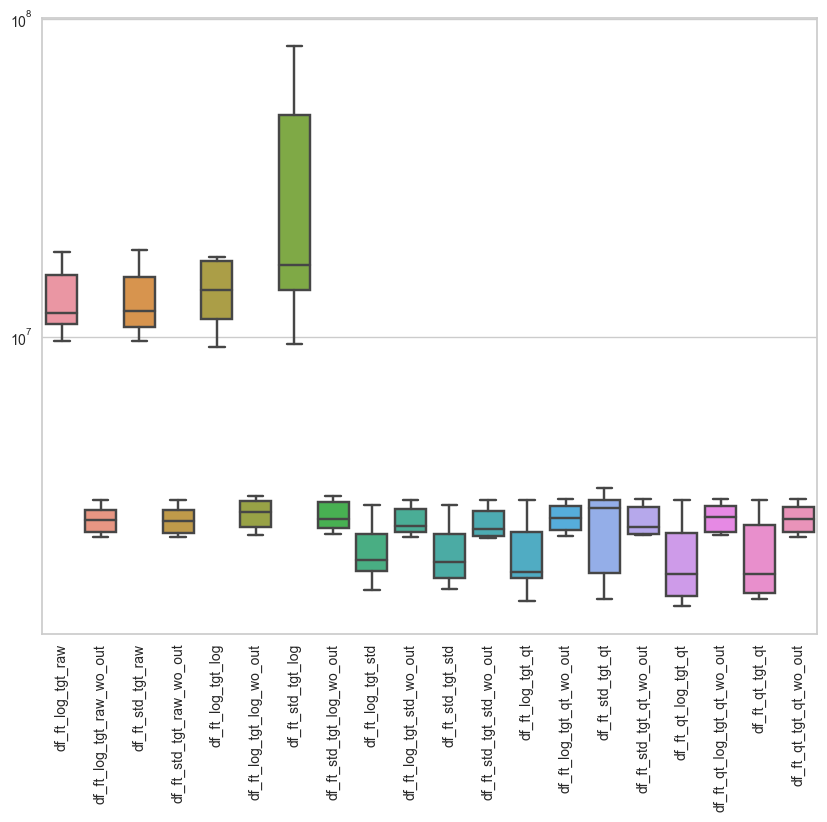

In [52]:
sns.boxplot(df_rmse_prepro, showfliers=False)
plt.xticks(rotation = 90);
plt.yscale('log')
save_fig("Impact des différentes confiurations de pré-traitement sur le score RMSE des modèles")

### Comparaison des scores RMSE des différentes modèles

In [53]:
df_rmse_models = pd.DataFrame(index=[name for name in dict_synth_prepros.keys()])
for model in models_to_train.keys():
    for name, df_tmp in dict_synth_prepros.items():
        df_rmse_models.loc[name, model] = df_tmp.loc[model,'RMSE']

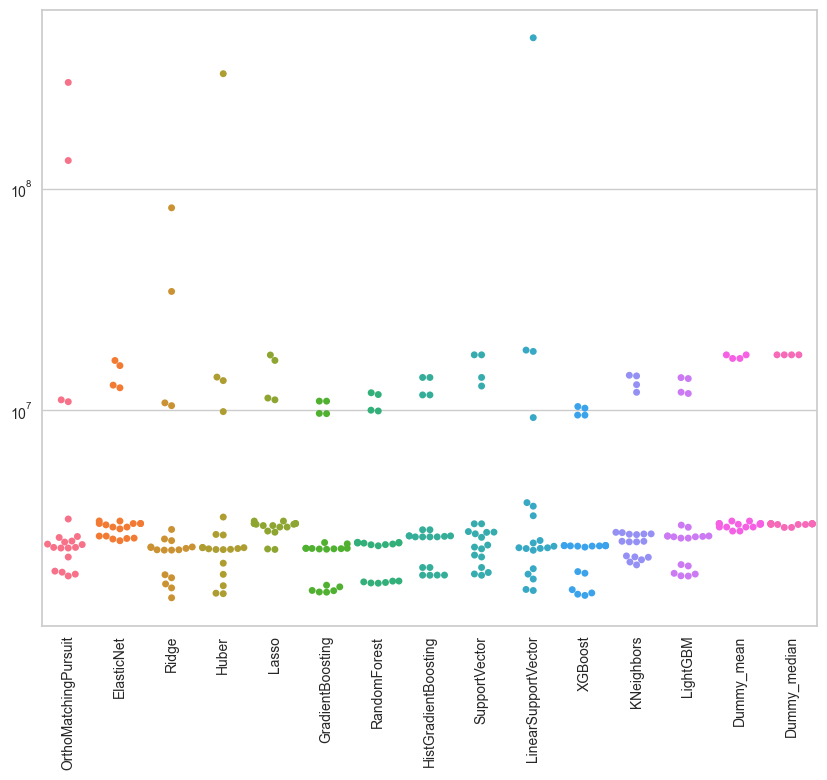

In [54]:
sns.swarmplot(df_rmse_models)
plt.xticks(rotation = 90)
plt.yscale('log')
save_fig("Comparaison des scores RMSE des différents modèles obtenus pour différentes configurations de pré-traitement")

# Feature Engineering

Maintenant que nous avons défini les meilleures configurations de traitement de nos variables numériques, nous allons travailler sur nos variables catégorielles dans le but d'améliorer les performances de nos 2 modèles prometteurs avec leurs paramètres par défaut, avant de passer à l'ajustement de leurs hyperparamètres.

In [55]:
promising_models_to_train = {'Ridge':ridge_reg,
                             'XGBoost':xgb
                            }

In [56]:
def cross_val_promising_models(X_train, y_train):
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model for model in promising_models_to_train.keys()]
                     )
    df.index.name = 'Model'
    
    for mdl_name, model in promising_models_to_train.items():
        
        dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }
        
        for train_index, test_index in kfold.split(X):
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            mdl.fit(X[train_index], y[train_index])
            fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
            dict_results['TT(sec)'].append(fit_duration)

            y_pred_qt = mdl.predict(X[test_index])

            for mtr_name, metric in metrics.items():
                score = metric(y_true=np.abs(target_prepro_qt.inverse_transform(y))[test_index], 
                               y_pred=np.abs(target_prepro_qt.inverse_transform(y_pred_qt.reshape(-1,1))))
                if mtr_name in ('RMSE','RMSLE'):
                    score = np.sqrt(score)
                elif mtr_name == 'adj. R²':
                    score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
                dict_results[mtr_name].append(score)
        
        for mtr_name, scores in dict_results.items():            
            df.loc[mdl_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

### YearBuilt

In [57]:
df_year = df.copy()
df_year['YearBuilt'] = pd.cut(df['YearBuilt'], 12)

In [58]:
std_features_year = std_features.copy()
std_features_year.remove('YearBuilt')
cat_features_year = cat_features.copy()
cat_features_year.append('YearBuilt')

In [59]:
std_features_ind_year = [std_features_year.index(ft) for ft in std_features_year]
cat_features_ind_year = [cat_features_year.index(ft) for ft in cat_features_year]

In [60]:
ft_prepro_qt_log_year = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                           ('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), std_features_ind_year),
                                           ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind_year)
                                          ])

In [61]:
X_train_year, _, y_train_year, _ = train_test_split(df_year.drop(columns=conso), df_year[conso], test_size=0.2, random_state=SEED)

y_train_year_qt = target_prepro_qt.transform(pd.DataFrame(y_train_year))

X_train_year_tr_log_qt = ft_prepro_qt_log_year.fit_transform(X_train_year)

cross_val_promising_models(X_train_year_tr_log_qt, y_train_year_qt)

MAE                    MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                          
XGBoost  2903532.99  32596395619412.191406  5662716.26    1.17  1.57    4.76   
Ridge    2890082.24  33430633313901.898438  5724774.51    1.17  1.55    0.17   

           R²  
Model          
XGBoost  0.53  
Ridge    0.53

In [62]:
df_year = df.copy()
df_year['YearBuilt'] = 2016-df_year['YearBuilt']

In [63]:
X_train_year, _, y_train_year, _ = train_test_split(df_year.drop(columns=conso), df_year[conso], test_size=0.2, random_state=SEED)

y_train_year_qt = target_prepro_qt.transform(pd.DataFrame(y_train_year))

X_train_year_tr_log_qt = ft_prepro_qt_log.fit_transform(X_train_year)

cross_val_promising_models(X_train_year_tr_log_qt, y_train_year_qt)

MAE                    MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                          
Ridge    2388785.51  22297430812579.851562  4648331.86    0.64  1.47    0.01   
XGBoost  2521141.08  27287957700047.441406  5165519.49    0.57   1.7    0.38   

           R²  
Model          
Ridge    0.69  
XGBoost  0.63

> Visiblement, les transformations que nous avons imaginé pour la varaible **YearBuilt** ne permettent pas d'améliorer les performances de nos modèles.

## Variables catégorielles

Vérifions s'il nous est possible de diminuer le nombre de modalités dans nos variables catégorielles afin de réduire le nombre de colonnes dans notre jeu de données transformé suite à l'application du *OneHotEncoder* dans l'espoir que cela améliore les résultats de nos modèles.

Gardons également à l'esprit qu'une diminution du nombre de modalités dans une variable catégorielle diminue également sa variance, ce qui peut avoir pour effet de diminuer son pouvoir prédictif selon nos modèles : nous veillerons ainsi à ne regrouper que les modalités décrivant des fonctions de densité de probabilité de la variable cible qui sont très proches.

### Neighborhood

Pour éviter de faire appel à la fonction *train_test_split* et appliquer notre pipeline de pré-traitement des données une multitude de fois par la suite, nous allons travailler directement sur le DataFrame obtenu à partir de notre jeu d'entraînement transformé auquel nous avons assigné les noms de colonnes des variables transformées :

In [64]:
df_train_qt_log = pd.DataFrame(X_train_tr_qt_log, columns=tr_col_names)

x_0 = [element for element in ohenc_col_names if element[:2]=='x0'] #Neighborhood
x_1 = [element for element in ohenc_col_names if element[:2]=='x1'] #PrimaryPropertyType
x_2 = [element for element in ohenc_col_names if element[:2]=='x2'] #LargestPropertyUseType
x_3 = [element for element in ohenc_col_names if element[:2]=='x3'] #SecondLargestPropertyUseType
x_4 = [element for element in ohenc_col_names if element[:2]=='x4'] #ThirdLargestPropertyUseType

dict_cols_grps = {ft:[ft] for ft in num_features}
dict_cols_grps['Neighborhood'] = x_0
dict_cols_grps['PrimaryPropertyType'] = x_1
dict_cols_grps['LargestPropertyUseType'] = x_2
dict_cols_grps['SecondLargestPropertyUseType'] = x_3
dict_cols_grps['ThirdLargestPropertyUseType'] = x_4

In [65]:
df_nh = df[['Neighborhood', conso]].copy()

In [66]:
# df_nh = df_train_qt_log.copy()
# df_nh = pd.concat([df_nh, pd.DataFrame(y_train_tr_qt, columns=[conso])], axis=1)

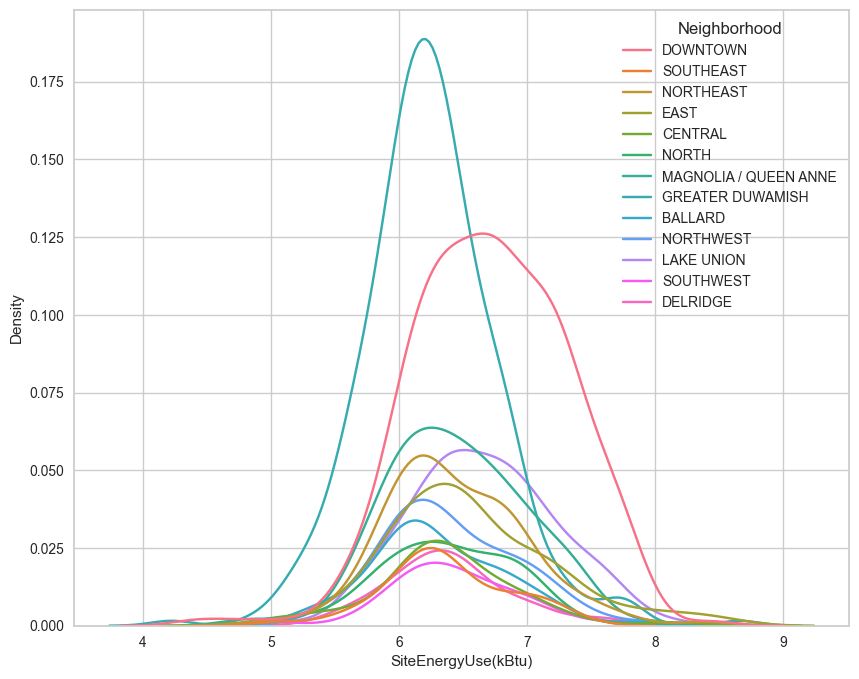

In [67]:
sns.kdeplot(data=df_nh, x=np.log10(df_nh[conso]), hue=df_nh['Neighborhood']);

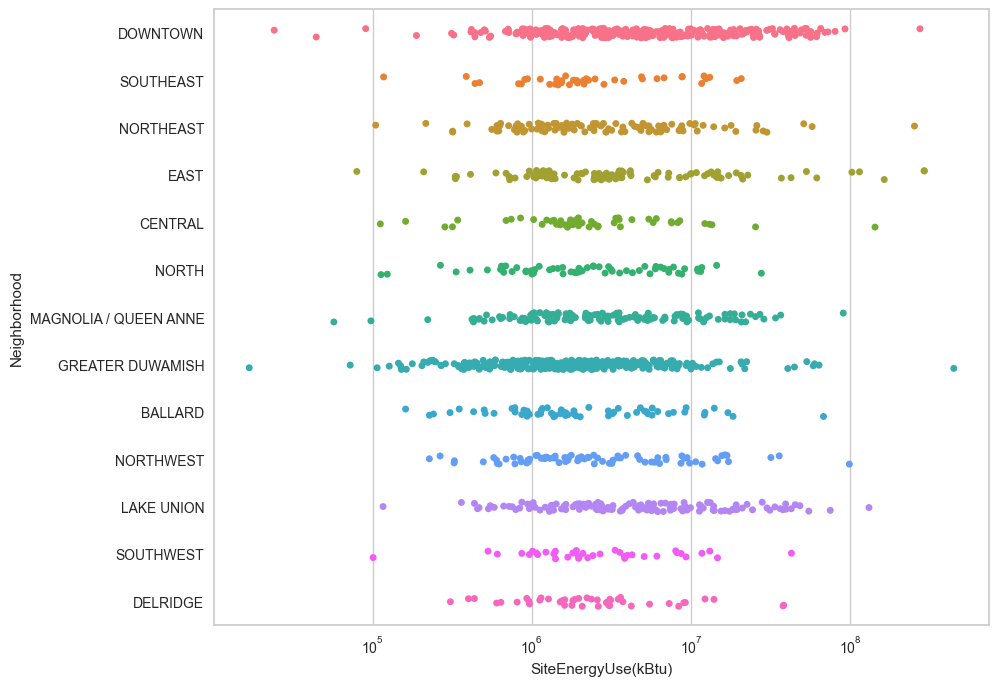

In [68]:
sns.stripplot(data=df_nh['Neighborhood'], y=df_nh['Neighborhood'], x=df_nh[conso], hue=df_nh['Neighborhood'], legend=False)
plt.xscale('log');

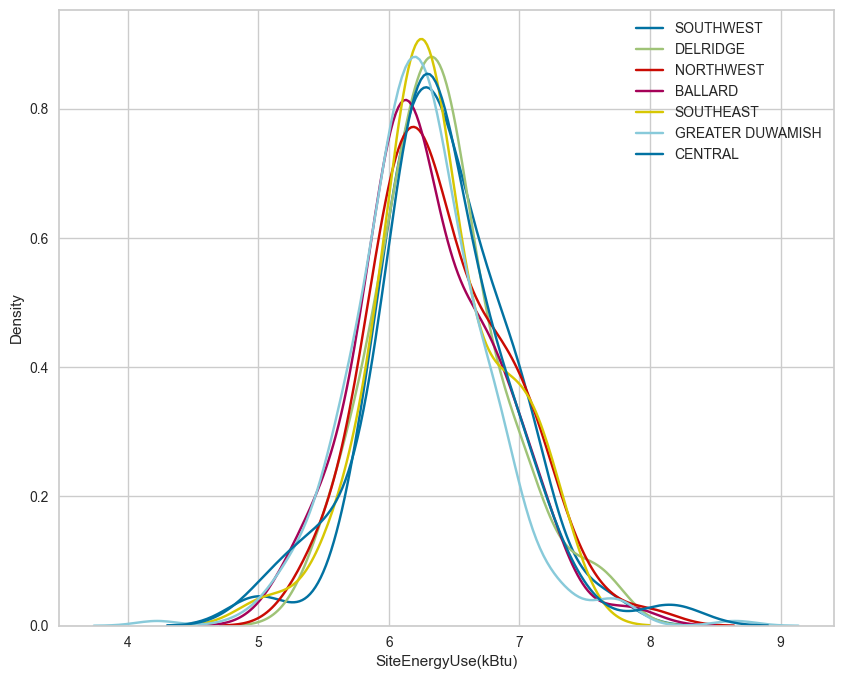

In [69]:
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'SOUTHWEST'][conso]), label='SOUTHWEST')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'DELRIDGE'][conso]), label='DELRIDGE')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'NORTHWEST'][conso]), label='NORTHWEST')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'BALLARD'][conso]), label='BALLARD')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'SOUTHEAST'][conso]), label='SOUTHEAST')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'GREATER DUWAMISH'][conso]), label='GREATER DUWAMISH')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'CENTRAL'][conso]), label='CENTRAL')
plt.legend();

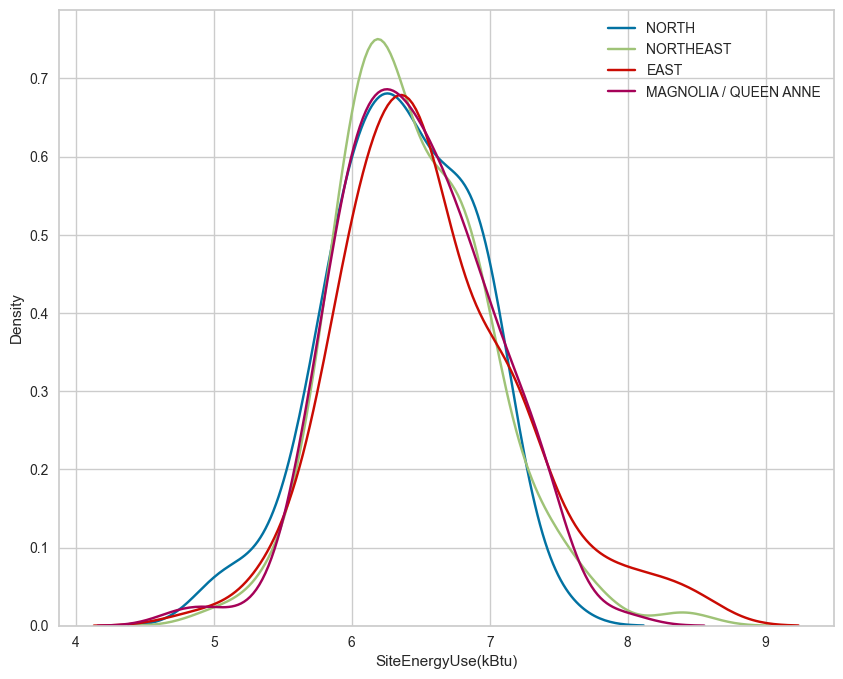

In [70]:
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'NORTH'][conso]), label='NORTH')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'NORTHEAST'][conso]), label='NORTHEAST')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'EAST'][conso]), label='EAST')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'MAGNOLIA / QUEEN ANNE'][conso]), label='MAGNOLIA / QUEEN ANNE')
plt.legend();

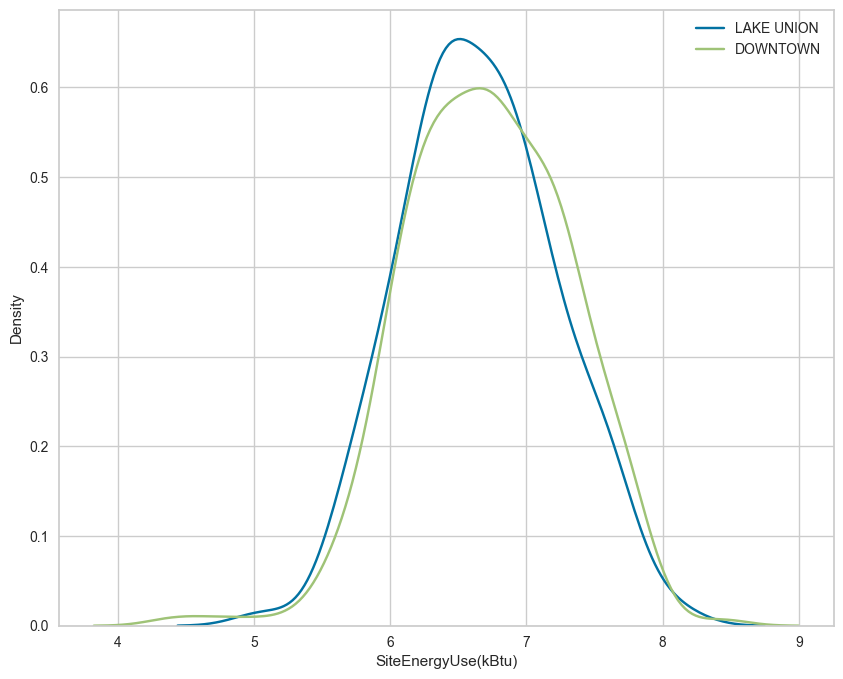

In [71]:
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'LAKE UNION'][conso]), label='LAKE UNION')
sns.kdeplot(np.log10(df_nh[df_nh['Neighborhood']== 'DOWNTOWN'][conso]), label='DOWNTOWN')
plt.legend();

In [72]:
dict_replace_nh = dict()
dict_replace_nh[0] = {'LAKE UNION':'grp_0', 'DOWNTOWN':'grp_0'}
dict_replace_nh[1] = {'NORTH':'grp_1', 'NORTHEAST':'grp_1', 'EAST':'grp_1', 'MAGNOLIA / QUEEN ANNE':'grp_1'}
dict_replace_nh[2] = {'SOUTHWEST':'grp_2', 'DELRIDGE':'grp_2', 'NORTHWEST':'grp_2', 'BALLARD':'grp_2', 'SOUTHEAST':'grp_2',
                      'GREATER DUWAMISH':'grp_2','CENTRAL':'grp_2'}

In [73]:
def replace_cat_nh(df, dict_regroup):
    new_df = df.copy()
    new_cat = ['x0_'+ft for ft in dict_regroup.values()][0]
    old_cats = ['x0_'+ft for ft in dict_regroup.keys()]
    new_df[new_cat] = 0 
    for cat in old_cats:
        new_df[new_cat] += new_df[cat]
        new_df.drop(columns=cat, inplace=True)
    return new_df

In [74]:
for regroup in dict_replace_nh.values():
    
    X_train_nh_tr_log_qt = replace_cat_nh(df_train_qt_log, regroup).to_numpy()
    
    print("\nRegroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_nh_tr_log_qt, y_train_tr_qt))


Regroupement de LAKE UNION, DOWNTOWN


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.28   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49    0.01   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75


Regroupement de NORTH, NORTHEAST, EAST, MAGNOLIA / QUEEN ANNE


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    822421.62  2185042015439.879883  1427946.96     0.7  1.49     0.0   
XGBoost  848688.86  2489677831042.680176  1534046.72    0.63  1.73     0.3   

           R²  
Model          
Ridge    0.74  
XGBoost  0.68


Regroupement de SOUTHWEST, DELRIDGE, NORTHWEST, BALLARD, SOUTHEAST, GREATER DUWAMISH, CENTRAL


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    822336.69  2236783463784.290039  1456014.64    0.69  1.48    0.01   
XGBoost  865093.68  2463498897810.990234  1518731.29    0.66  1.58    0.27   

           R²  
Model          
Ridge    0.73  
XGBoost  0.70

In [75]:
best_rmse[0]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    819884.14   2180074892394.48999  1424806.76     0.7  1.49     0.0   
XGBoost   843135.0  2277457760766.040039  1460659.91    0.68  1.76    0.26   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

Nous voyons que le permier regroupement permet d'améliorer significativement le score **RMSE** de nos modèles.

Essayons de combiner les regroupements de modalités :

In [76]:
X_train_nh_tr_log_qt = df_train_qt_log.copy()

for regroup in dict_replace_nh.values():
    X_train_nh_tr_log_qt = replace_cat_nh(X_train_nh_tr_log_qt, regroup)

cross_val_promising_models(X_train_nh_tr_log_qt.to_numpy(), y_train_tr_qt)

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    825938.93       2273698484436.5  1472730.65    0.68  1.48     0.0   
XGBoost  877168.89  2806618390766.459961  1617624.13    0.59  1.62    0.28   

           R²  
Model          
Ridge    0.72  
XGBoost  0.64

> Nous n'effectuons que le premier regroupement.

In [77]:
df_ft_eng = replace_cat_nh(df_train_qt_log, dict_replace_nh[0])
best_rmse.append(cross_val_promising_models(df_ft_eng.to_numpy(), y_train_tr_qt))

### PrimaryPropertyType

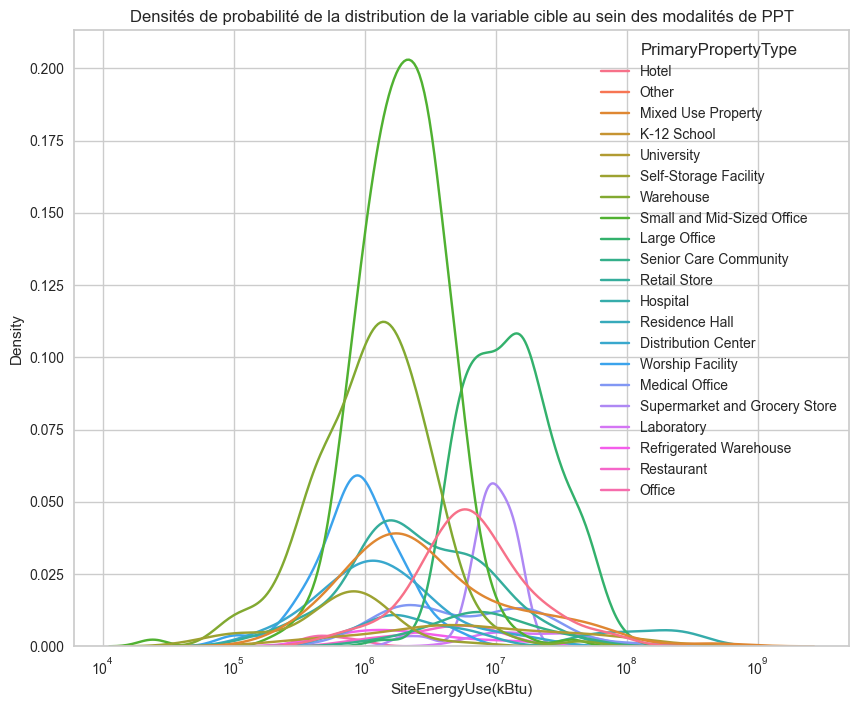

In [78]:
df_ppt = df[['PrimaryPropertyType', conso]].copy()

plt.title("Densités de probabilité de la distribution de la variable cible au sein des modalités de PPT")
sns.kdeplot(data=df_ppt, x=conso, hue=df_ppt['PrimaryPropertyType'], log_scale=True);

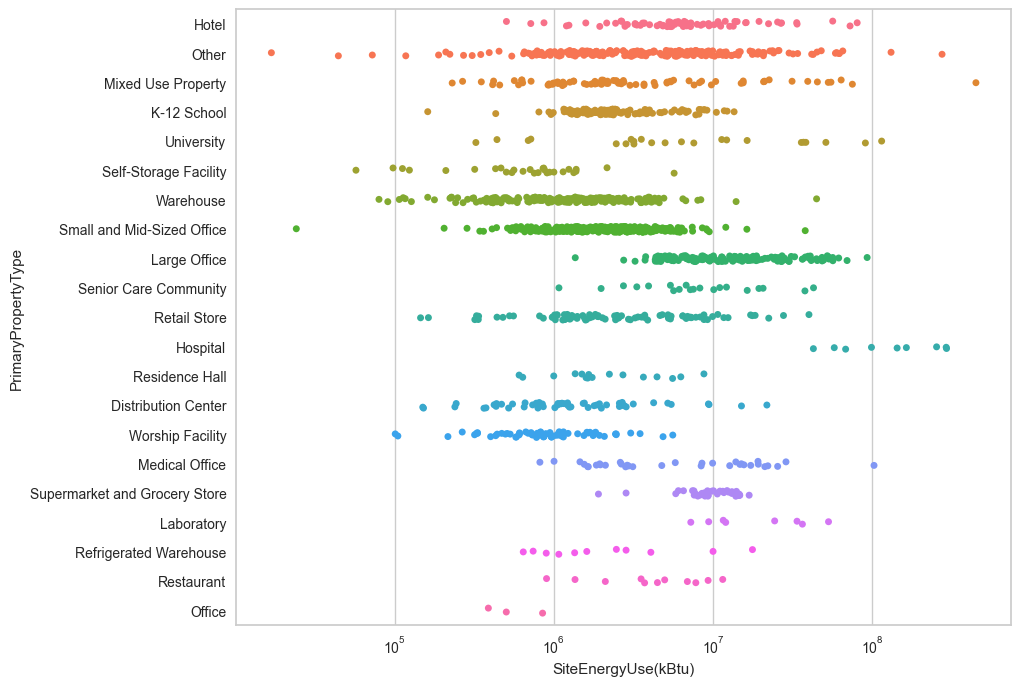

In [79]:
sns.stripplot(data=df_ppt['PrimaryPropertyType'], y=df_ppt['PrimaryPropertyType'], x=df_ppt[conso], hue=df_ppt['PrimaryPropertyType'], legend=False)
plt.xscale('log');

A partir des 2 visualisations précédentes, nous pouvons essayer de regrouper entre elles les modalités ayant une distribution de notre variable cibles qui soient proches :

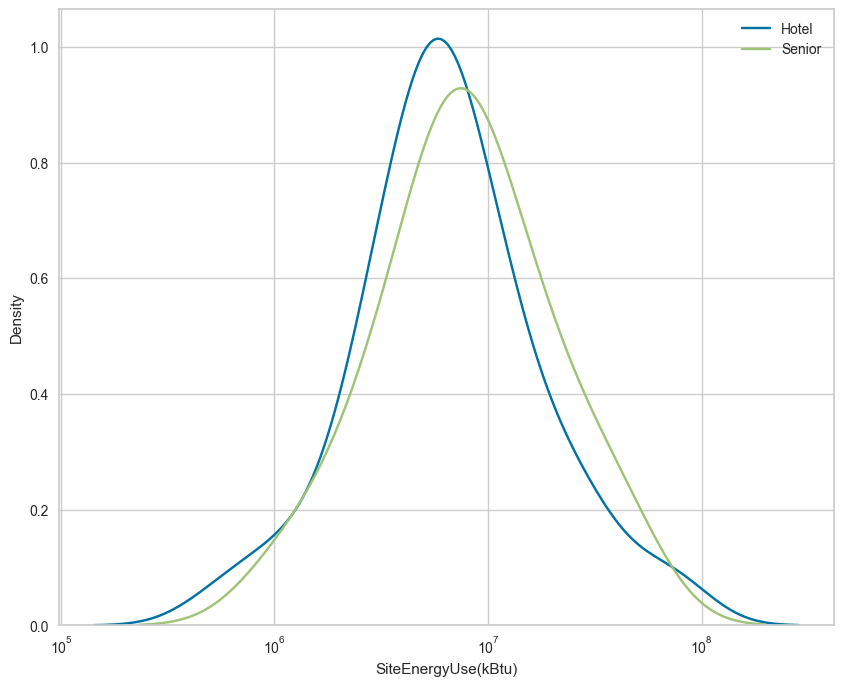

In [80]:
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'Hotel'][conso], label='Hotel', log_scale=True)
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'Senior Care Community'][conso], label='Senior', log_scale=True)
plt.legend();

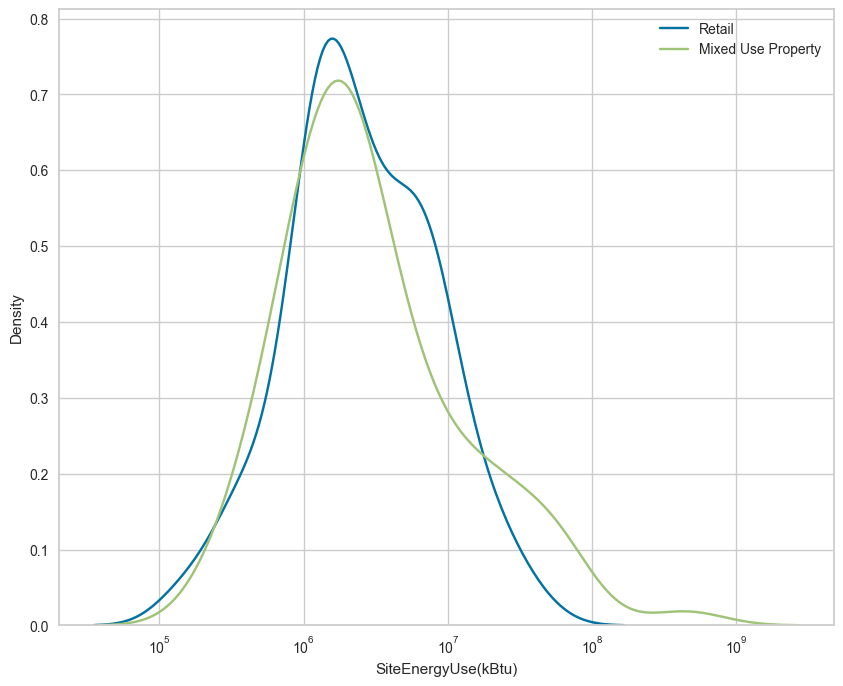

In [81]:
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'Retail Store'][conso], label='Retail', log_scale=True)
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'Mixed Use Property'][conso], label='Mixed Use Property', log_scale=True)
plt.legend();

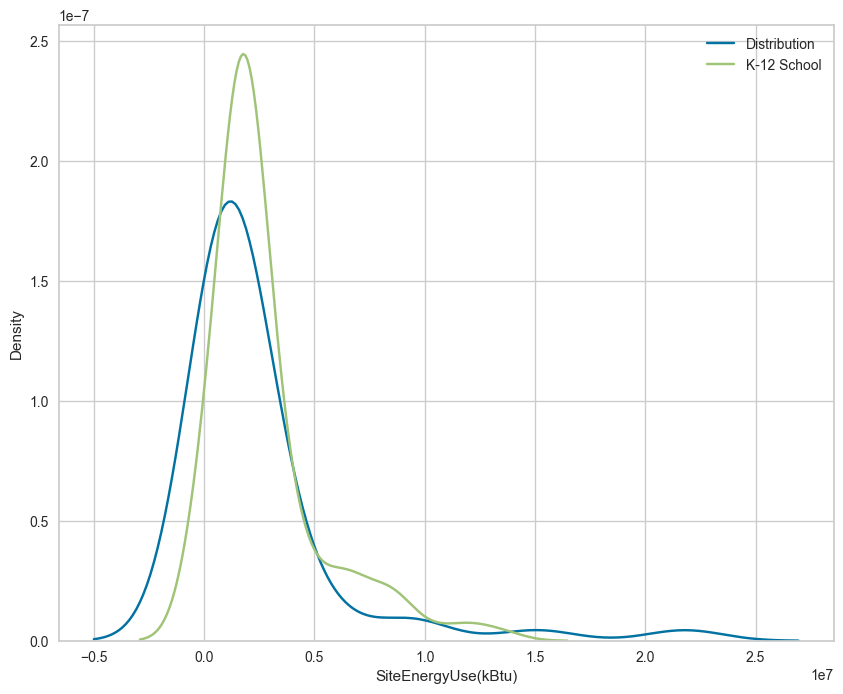

In [82]:
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'Distribution Center'][conso], label='Distribution')
sns.kdeplot(df_ppt[df_ppt['PrimaryPropertyType']== 'K-12 School'][conso], label='K-12 School')
plt.legend();

In [83]:
dict_replace = dict()
dict_replace[0] = {'Senior Care Community':'grp_0','Hotel':'grp_0'}
dict_replace[1] = {'Retail Store':'grp_1', 'Mixed Use Property':'grp_1'}
dict_replace[2] = {'Distribution Center':'grp_2', 'K-12 School':'grp_2'}

In [84]:
def replace_cat_ppt(df, dict_regroup):
    new_df = df.copy()
    new_cat = ['x1_'+ft for ft in dict_regroup.values()][0]
    old_cats = ['x1_'+ft for ft in dict_regroup.keys()]
    new_df[new_cat] = 0 
    for cat in old_cats:
        new_df[new_cat] += new_df[cat]
        new_df.drop(columns=cat, inplace=True)
    return new_df

In [85]:
for regroup in dict_replace.values():
    
    X_train_ppt_tr_log_qt = replace_cat_ppt(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup]))
    
    display(cross_val_promising_models(X_train_ppt_tr_log_qt, y_train_tr_qt))

Regroupement de Senior Care Community, Hotel


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820195.14  2170051857588.870117  1421872.11    0.71  1.49    0.01   
XGBoost  837484.85   2269396664862.22998  1459151.94    0.68  1.82    0.25   

           R²  
Model          
Ridge    0.75  
XGBoost  0.72

Regroupement de Retail Store, Mixed Use Property


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820334.52  2171167544114.189941  1422370.19    0.71  1.49     0.0   
XGBoost  834519.51  2320880350013.859863  1470312.51    0.67  1.77    0.24   

           R²  
Model          
Ridge    0.75  
XGBoost  0.72

Regroupement de Distribution Center, K-12 School


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820189.52  2170669400727.879883  1421918.49    0.71  1.49     0.0   
XGBoost  847918.46  2621251985317.939941  1543511.17    0.61  1.87    0.29   

           R²  
Model          
Ridge    0.75  
XGBoost  0.67

In [86]:
best_rmse[-1]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.25   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

Aucun des regroupements ne nous permet d'améliorer significativement le socre **RMSE**.
Vérifions si ce peut être le cas en les réalisant tous:

In [87]:
X_train_ppt_tr_log_qt = df_ft_eng.copy()
for regroup in dict_replace.values():
    X_train_ppt_tr_log_qt = replace_cat_ppt(X_train_ppt_tr_log_qt, regroup)

cross_val_promising_models(X_train_ppt_tr_log_qt.to_numpy(), y_train_tr_qt)

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820243.01  2171476283052.959961  1422327.58    0.71  1.49     0.0   
XGBoost  844750.62  2418615884731.779785  1492601.44    0.66  1.89    0.25   

           R²  
Model          
Ridge    0.75  
XGBoost  0.71

Nous n'obtenons pas de meilleurs résultats en regroupant les modalités de la variable **PrimaryPropertyType**.

### LargestPropertyTypeUse

Étant donné le grand nombre de modalités, ici, nous avons tout intérêt à commencer à intégrer dans de plus grandes catégories les modalités ayant avec un effectif unitaire :

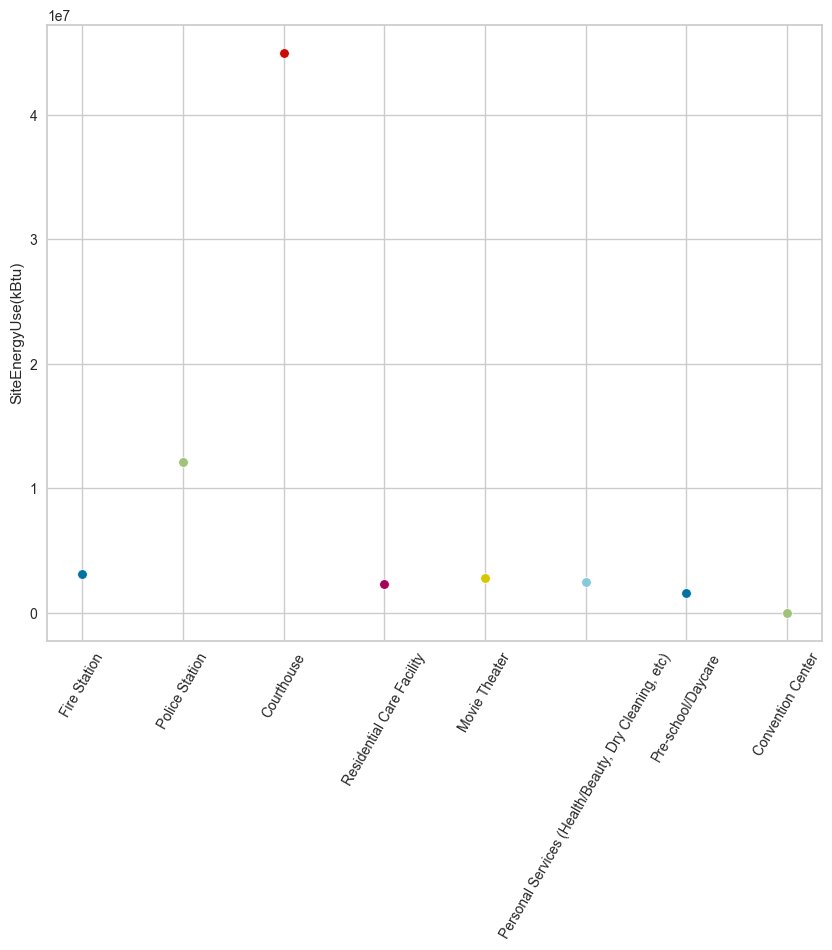

In [88]:
list_cat_unit = list(df['LargestPropertyUseType'].value_counts()[df['LargestPropertyUseType'].value_counts()==1].index)
for cat in list_cat_unit:
    sns.scatterplot(x=list_cat_unit.index(cat),y=df[df['LargestPropertyUseType']==cat][conso])

plt.xticks(ticks=[list_cat_unit.index(cat) for cat in list_cat_unit], labels=list_cat_unit)
plt.xticks(rotation=60);

In [89]:
for cat in list_cat_unit:
    print(cat)
    display(df[df[conso] > 0.99*df[df['LargestPropertyUseType'] == cat][conso].values[0]].sort_values(by=conso, ascending=True)[:15])

Fire Station


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
465                     46000.0  47.60197 -122.33437                1.0   
806                     16243.0  47.72134 -122.34102                1.0   
251                     74831.0  47.62323 -122.33028                1.0   
1009                    57952.0  47.51885 -122.33421                5.0   
1010                    18262.0  47.52956 -122.33592                1.0   
659                     38939.0  47.61607 -122.34449                1.0   
1192                    43615.0  47.53419 -122.36624                1.0   
167                     47079.0  47.71895 -122.29475                1.0   
436                     85343.0  47.57658 -122.33054                1.0   
1283                    48350.0  47.64747 -122.34086                1.0   
1545                    68916.0  47.66127 -122.31256                1.0   
384                     60732.0  47.59388 -122.31124                1.0   
1521                    99765.0  47.61699 -122.32083                1.0   
121                     28636.0  47.70956 -122.33450                1.0   
410                     50008.0  47.55623 -122.33316                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
465                6                   56700                   0   
806                2                   26994                   0   
251                5                   71421               69710   
1009               1                   57952                   0   
1010               1                   26232                   0   
659                2                   37740                   0   
1192               1                   43615                   0   
167                5                   50759                   0   
436                2                   92792                   0   
1283               4                   48350                   0   
1545               1                   68072                   0   
384                1                   65430                   0   
1521               2                   99765                   0   
121                3                   55442                   0   
410                1                   50008                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
465              56700                          10500.0   
806              26994                          10751.0   
251             141131                          71643.0   
1009             57952                              0.0   
1010             26232                           7970.0   
659              37740                              0.0   
1192             43615                              0.0   
167              50759                           3680.0   
436              92792                          13435.0   
1283             48350                              0.0   
1545             68072                              0.0   
384              65430                           8142.0   
1521             99765                              0.0   
121              55442                          15385.0   
410              50008                              0.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt      Neighborhood  \
465                              0.0       1900          DOWNTOWN   
806                              0.0       1958         NORTHWEST   
251                              0.0       2009        LAKE UNION   
1009                             0.0       2005          DELRIDGE   
1010                             0.0       1971          DELRIDGE   
659                              0.0       1922          DOWNTOWN   
1192                             0.0       1970          DELRIDGE   
167                              0.0       1972             NORTH   
436                              0.0       1962  GREATER DUWAMISH   
1283                             0.0       2008        LAKE UNION   
1545        

Police Station


LargestPropertyUseTypeGFA   Latitude   Longitude  NumberofBuildings  \
880                     20649.0  47.622400 -122.362480                1.0   
514                     90345.0  47.614720 -122.355660                1.0   
5                       88830.0  47.616230 -122.336570                1.0   
1520                    35361.0  47.524720 -122.270740                1.0   
755                     36000.0  47.698750 -122.367250                1.0   
1474                    84300.0  47.618080 -122.321750                1.0   
386                     74864.0  47.614400 -122.309820                1.0   
1015                    45522.0  47.689900 -122.376190                1.0   
133                    367884.0  47.529150 -122.365110                1.0   
1226                    28734.0  47.547230 -122.284550                1.0   
476                     39500.0  47.637180 -122.377340                1.0   
1534                   341897.0  47.621460 -122.339760                1.0   
155                    135006.0  47.592690 -122.333720                1.0   
485                    178625.0  47.618130 -122.358330                1.0   
578                    146150.0  47.607967 -122.319545                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
880                2                   34416                   0   
514                3                   76893                   0   
5                  2                   60090               37198   
1520               1                   53775                   0   
755                2                    3636               31000   
1474               5                   84000                   0   
386                3                   80004                   0   
1015               1                   45522                   0   
133                2                  367884                   0   
1226               1                   37883                   0   
476                1                   57176                   0   
1534              12                  317442              163260   
155                9                  153882               14567   
485                7                  197203               80283   
578                5                  130262              159157   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
880              34416                          13767.0   
514              76893                          33380.0   
5                97288                              0.0   
1520             53775                          12689.0   
755              34636                              0.0   
1474             84000                              0.0   
386              80004                              0.0   
1015             45522                              0.0   
133             367884                              0.0   
1226             37883                          24813.0   
476              57176                          15000.0   
1534            480702                         136594.0   
155             168449                          20600.0   
485             277486                          87624.0   
578             289419                         139000.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt           Neighborhood  \
880                           2000.0       1962  MAGNOLIA / QUEEN ANNE   
514                          15845.0       1902               DOWNTOWN   
5                                0.0       1999               DOWNTOWN   
1520                          2110.0       2013              SOUTHEAST   
755                              0.0       1966                BALLARD   
1474                             0.0       2006                   EAST   
386                              0.0       1926                CENTRAL   
1015                             0.0       1994                BALLARD   
133                              0.0       2010               DELRIDGE   

Courthouse


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
208                   1011135.0  47.60505 -122.33427                1.0   
34                     616000.0  47.51138 -122.28875                3.0   
19                     537150.0  47.60265 -122.33051                1.0   
216                    808980.0  47.60615 -122.33388                1.0   
327                    175364.0  47.62405 -122.34036                1.0   
20                     385274.0  47.60378 -122.32842                1.0   
309                    155985.0  47.61907 -122.33651                1.0   
247                    718473.0  47.60896 -122.33481                1.0   
273                   1314475.0  47.61043 -122.33206                1.0   
1528                   203030.0  47.65356 -122.30613                1.0   
268                    643083.0  47.61022 -122.33745                1.0   
352                    119815.0  47.60740 -122.33777                1.0   
256                    994116.0  47.60723 -122.33611                1.0   
1490                   181930.0  47.60427 -122.32311                1.0   
157                    240984.0  47.52429 -122.31234               14.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
208               47                 1323055                   0   
34                 2                  714095                   0   
19                10                  540360                   0   
216               49                  754455              368980   
327                5                  282813              153684   
20                19                  385274                   0   
309                8                  287819                   0   
247               42                  635824                   0   
273               56                 1215718              389860   
1528               6                  203030                   0   
268               30                  620338              134662   
352                6                  154660                   0   
256               55                 1115000              285000   
1490               8                  178000                   0   
157                2                  302494               31874   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
208            1323055                         272682.0   
34              714095                         276000.0   
19              540360                              0.0   
216            1123435                         232248.0   
327             436497                         173235.0   
20              385274                              0.0   
309             287819                          88350.0   
247             635824                          40000.0   
273            1605578                         389860.0   
1528            203030                              0.0   
268             755000                         126891.0   
352             154660                          63101.0   
256            1400000                         264481.0   
1490            178000                              0.0   
157             334368                          72963.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt      Neighborhood  \
208                          37595.0       1983          DOWNTOWN   
34                           71000.0       1961  GREATER DUWAMISH   
19                               0.0       1916          DOWNTOWN   
216                          30329.0       1969          DOWNTOWN   
327                          88901.0       2008        LAKE UNION   
20                               0.0       1985          DOWNTOWN   
309                          15630.0       1929        LAKE UNION   
247                          19671.0       1976          DOWNTOWN   
273                          30744.0       1989          DOWNTOWN   
1528                             0.0       1998         NORTHEAST   
268         

Residential Care Facility


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
1308                    22960.0  47.63644 -122.34218                1.0   
887                     75605.0  47.52499 -122.27466                1.0   
805                     25557.0  47.72299 -122.34293                1.0   
1044                    31325.0  47.65103 -122.35541                1.0   
144                     67235.0  47.68359 -122.37308                1.0   
174                     65310.0  47.59096 -122.29985                1.0   
722                     31000.0  47.58482 -122.30501                1.0   
794                     40067.0  47.64976 -122.35684                1.0   
798                     34545.0  47.64934 -122.35592                1.0   
600                     50956.0  47.69054 -122.29705                1.0   
731                     14317.0  47.63629 -122.35922                1.0   
172                     75214.0  47.64052 -122.36560                1.0   
1176                    32200.0  47.52549 -122.33064                1.0   
696                     55206.0  47.57405 -122.30301                1.0   
545                     77800.0  47.58454 -122.32690                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
1308               3                   22960                   0   
887                2                   75605                   0   
805                4                   25557                   0   
1044               3                   48924                   0   
144                2                   67235                   0   
174                2                   64414                   0   
722                2                   31000                   0   
794                3                   40067                   0   
798                3                   34545                   0   
600                1                   46732                   0   
731                1                   27247                   0   
172                3                   75214                   0   
1176               1                   33320                   0   
696                1                   55206                   0   
545                1                   73296                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
1308             22960                              0.0   
887              75605                              0.0   
805              25557                              0.0   
1044             48924                          13143.0   
144              67235                              0.0   
174              64414                              0.0   
722              31000                              0.0   
794              40067                              0.0   
798              34545                              0.0   
600              46732                              0.0   
731              27247                           7701.0   
172              75214                              0.0   
1176             33320                           1200.0   
696              55206                              0.0   
545              73296                              0.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt           Neighborhood  \
1308                             0.0       1961  MAGNOLIA / QUEEN ANNE   
887                              0.0       2000              SOUTHEAST   
805                              0.0       1970              NORTHWEST   
1044                             0.0       1989             LAKE UNION   
144                              0.0       1999                BALLARD   
174                              0.0       1991                CENTRAL   
722                              0.0       1970       GREATER DUWAMISH   
794                              0.0       1986  MAGNOLIA / QUEEN ANNE   
798                              0.0       1980  MAGNOLIA / QUEEN ANNE   
600                            

Movie Theater


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
556                     55000.0  47.52549 -122.33064                1.0   
318                    127800.0  47.62572 -122.33389                1.0   
1174                    36000.0  47.53160 -122.33300                1.0   
799                     70296.0  47.64865 -122.35435                1.0   
1171                    33392.0  47.70197 -122.34219                1.0   
1252                    30000.0  47.55966 -122.33146                1.0   
1036                    20424.0  47.59560 -122.32292                1.0   
1275                    45500.0  47.60154 -122.33520                1.0   
876                     38500.0  47.62014 -122.34456                1.0   
1069                    35693.0  47.60320 -122.33663                1.0   
782                     30971.0  47.61109 -122.32721                1.0   
1139                    27642.0  47.66159 -122.28606                2.0   
1018                    40657.0  47.56999 -122.34703                1.0   
866                     20895.0  47.60836 -122.34157                1.0   
831                     41632.0  47.61194 -122.32177                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
556                1                   54880                   0   
318                5                  127800                   0   
1174               1                   36000                   0   
799                3                   70296                   0   
1171               1                   33392                   0   
1252               1                   30000                   0   
1036               2                   21315                   0   
1275               4                   45500                   0   
876                4                   38520                   0   
1069               3                   32160                   0   
782                3                   30971                   0   
1139               4                   22356               14576   
1018               2                   40657                   0   
866                6                   40715                   0   
831                3                   73549                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
556              54880                              0.0   
318             127800                              0.0   
1174             36000                              0.0   
799              70296                              0.0   
1171             33392                              0.0   
1252             30000                              0.0   
1036             21315                              0.0   
1275             45500                              0.0   
876              38520                              0.0   
1069             32160                          14219.0   
782              30971                              0.0   
1139             36932                              0.0   
1018             40657                              0.0   
866              40715                          16260.0   
831              73549                          31917.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt           Neighborhood  \
556                              0.0       1979       GREATER DUWAMISH   
318                              0.0       1914             LAKE UNION   
1174                             0.0       1973       GREATER DUWAMISH   
799                              0.0       1980  MAGNOLIA / QUEEN ANNE   
1171                             0.0       1986              NORTHWEST   
1252                             0.0       1960       GREATER DUWAMISH   
1036                             0.0       1973       GREATER DUWAMISH   
1275                             0.0       1914               DOWNTOWN   
876                              0.0       1959             LAKE UNION   
1069                           

Personal Services (Health/Beauty, Dry Cleaning, etc)


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
594                     62975.0  47.57950 -122.38723                1.0   
281                     38880.0  47.61304 -122.34059                1.0   
997                     30498.0  47.70541 -122.32232                2.0   
168                     56772.0  47.66182 -122.31113                1.0   
1250                    25406.0  47.71620 -122.29560                1.0   
653                     57800.0  47.61471 -122.34525                1.0   
527                     45000.0  47.60956 -122.33715                1.0   
982                     24052.0  47.68582 -122.33709                1.0   
1343                    62400.0  47.66450 -122.31224                1.0   
834                     53000.0  47.60821 -122.32960                1.0   
1388                    26000.0  47.62531 -122.32303                1.0   
1310                    21194.0  47.66816 -122.27706                1.0   
1258                    22000.0  47.56173 -122.32885                1.0   
992                     76105.0  47.70842 -122.33320                1.0   
1386                    24600.0  47.60133 -122.31088                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
594                1                   61183                   0   
281                4                   52800                   0   
997                1                   30498                   0   
168                2                   56772                   0   
1250               1                   25406                   0   
653                5                   57800                   0   
527                3                   83118                   0   
982                3                   33062               22850   
1343               2                   78401                   0   
834                3                   37796                   0   
1388               3                   31900                   0   
1310               1                   22778                   0   
1258               1                   27263                   0   
992                3                   48798               27307   
1386               3                   20992                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
594              61183                              0.0   
281              52800                          12960.0   
997              30498                              0.0   
168              56772                              0.0   
1250             25406                              0.0   
653              57800                              0.0   
527              83118                              0.0   
982              55912                          23501.0   
1343             78401                           9940.0   
834              37796                          17600.0   
1388             31900                              0.0   
1310             22778                          12923.0   
1258             27263                           2700.0   
992              76105                              0.0   
1386             20992                           4625.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt      Neighborhood  \
594                              0.0       1950         SOUTHWEST   
281                              0.0       1925          DOWNTOWN   
997                              0.0       2005             NORTH   
168                              0.0       1952         NORTHEAST   
1250                             0.0       1960             NORTH   
653                              0.0       1990          DOWNTOWN   
527                              0.0       1940          DOWNTOWN   
982                           9561.0       1996         NORTHWEST   
1343                          4960.0       1927         NORTHEAST   
834                              0.0       1962              EAST   
1388        

Pre-school/Daycare


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
948                     15000.0  47.66984 -122.38420                1.0   
368                     85400.0  47.54853 -122.32814                1.0   
1365                    44000.0  47.60048 -122.33157                1.0   
826                     35840.0  47.60961 -122.33566                1.0   
875                     54150.0  47.61952 -122.34462                1.0   
21                      58916.0  47.54576 -122.26853                1.0   
1494                   293707.0  47.51098 -122.27817                1.0   
1277                    24120.0  47.60149 -122.33458                1.0   
1360                    63922.0  47.67842 -122.31949                1.0   
1519                    44162.0  47.51377 -122.34328                1.0   
658                     26670.0  47.61460 -122.34217                1.0   
1484                    14877.0  47.58230 -122.32937                1.0   
502                    109090.0  47.58772 -122.32686                1.0   
650                     26270.0  47.61652 -122.34854                1.0   
1197                    40285.0  47.69845 -122.30747                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
948                1                   15000               15576   
368                1                   85400                   0   
1365               5                   36879                   0   
826                5                   35840                   0   
875                3                   51552                   0   
21                 2                   56228                   0   
1494               2                   45700                   0   
1277               4                   42804                   0   
1360               3                   46485                   0   
1519               2                   44162                   0   
658                4                   26670                   0   
1484               3                   21947                   0   
502                1                  111908                   0   
650                2                   26270                   0   
1197               1                   36701                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
948              30576                           3100.0   
368              85400                              0.0   
1365             36879                              0.0   
826              35840                              0.0   
875              51552                            650.0   
21               56228                              0.0   
1494             45700                              0.0   
1277             42804                           6583.0   
1360             46485                              0.0   
1519             44162                          15761.0   
658              26670                              0.0   
1484             21947                          12023.0   
502             111908                              0.0   
650              26270                              0.0   
1197             36701                              0.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt      Neighborhood  \
948                              0.0       2004           BALLARD   
368                              0.0       1966  GREATER DUWAMISH   
1365                             0.0       1905          DOWNTOWN   
826                              0.0       1907          DOWNTOWN   
875                              0.0       2013        LAKE UNION   
21                               0.0       1961         SOUTHEAST   
1494                             0.0       1988         SOUTHEAST   
1277                             0.0       1900          DOWNTOWN   
1360                             0.0       1950         NORTHEAST   
1519                             0.0       2010          DELRIDGE   
658         

Convention Center


LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
1212                    24717.0  47.58788 -122.33458                1.0   
823                     25000.0  47.61119 -122.33581                1.0   
863                     24019.0  47.60711 -122.33886                1.0   
964                     39952.0  47.64418 -122.37587                1.0   
1489                    39212.0  47.54277 -122.31626                1.0   
1442                    23040.0  47.61481 -122.31536                1.0   
701                     24000.0  47.60528 -122.33627                1.0   
963                     30989.0  47.64455 -122.37581                1.0   
980                     23772.0  47.51709 -122.37797                1.0   
1393                    20039.0  47.66146 -122.27880                1.0   
1218                    22752.0  47.55608 -122.33880                1.0   
1216                    21018.0  47.61234 -122.31628                1.0   
1027                    21936.0  47.72051 -122.30103                1.0   
934                     20140.0  47.65022 -122.34174                1.0   
727                     20047.0  47.56979 -122.29234                1.0   

      NumberofFloors  PropertyGFABuilding(s)  PropertyGFAParking  \
1212               3                   27690                   0   
823                3                   57720                   0   
863                3                   49760                   0   
964                3                   39952                   0   
1489               2                   39212                   0   
1442               2                   23040                   0   
701                5                   33300                   0   
963                3                   30989                   0   
980                1                   23772                   0   
1393               2                   20039                   0   
1218               1                   24617                   0   
1216               1                   24248                   0   
1027               1                   21936                   0   
934                2                   20140                   0   
727                2                   20047                   0   

      PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
1212             27690                              0.0   
823              57720                              0.0   
863              49760                              0.0   
964              39952                              0.0   
1489             39212                              0.0   
1442             23040                              0.0   
701              33300                           6000.0   
963              30989                              0.0   
980              23772                              0.0   
1393             20039                              0.0   
1218             24617                              0.0   
1216             24248                           3230.0   
1027             21936                              0.0   
934              20140                              0.0   
727              20047                              0.0   

      ThirdLargestPropertyUseTypeGFA  YearBuilt           Neighborhood  \
1212                             0.0       1910       GREATER DUWAMISH   
823                              0.0       1903               DOWNTOWN   
863                              0.0       1900               DOWNTOWN   
964                              0.0       1915  MAGNOLIA / QUEEN ANNE   
1489                             0.0       1906       GREATER DUWAMISH   
1442                             0.0       1920                   EAST   
701                              0.0       1900               DOWNTOWN   
963                              0.0       1980  MAGNOLIA / QUEEN ANNE   
980                              0.0       1971              SOUTHWEST   
1393                           

Nous pouvons intégrer la modalité **Fire Station** dans la catégorie **Medical Office** car c'est celle présentant un bâtiment dont la valeur cible est la plus proche, et nous procédons de même pour les autres modalités unitaires :

In [90]:
df_lput = df[['LargestPropertyUseType', conso]].copy()

In [91]:
dict_replace = dict()

dict_replace[0] = {'Fire Station':'Medical Office'}
dict_replace[1] = {'Police Station':'Other - Recreation'}
dict_replace[2] = {'Courthouse':'Office'}
dict_replace[3] = {'Movie Theater':'Office'}
dict_replace[4] = {'Personal Services (Health/Beauty, Dry Cleaning, etc)':'Hotel'}
dict_replace[5] = {'Convention Center':'Other'}

In [92]:
def replace_cat_lput_unit(df, dict_regroup):
    new_df = df.copy()
    new_cat = [ft for ft in dict_regroup.values()][0]
    old_cat = [ft for ft in dict_regroup.keys()][0]
    new_df['x2_'+new_cat] += new_df['x2_'+old_cat]
    new_df.drop(columns=['x2_'+old_cat], inplace=True)
    return new_df

In [93]:
for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput_unit(df_ft_eng, regroup).to_numpy()
    
    for key, value in regroup.items():
    
        print("Regroupement de "+', '.join([key, value]))
    
        display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_qt))

Regroupement de Fire Station, Medical Office


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820111.73  2169993484906.100098  1421784.22    0.71  1.49    0.01   
XGBoost   841672.6  2296882210139.870117  1464808.44    0.68  1.71    0.25   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

Regroupement de Police Station, Other - Recreation


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    819531.62  2169415558087.300049  1421176.71    0.71  1.49     0.0   
XGBoost  824794.62  2208198547214.109863  1434500.99    0.69  1.63    0.25   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

Regroupement de Courthouse, Office


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge     820632.9   2169870742567.72998  1422292.75    0.71  1.49     0.0   
XGBoost  832843.85  2203313103541.350098  1433541.63    0.69  1.82    0.24   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

Regroupement de Movie Theater, Office


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  826928.74  2120444379871.080078  1412274.45     0.7  1.66    0.28   
Ridge    820240.37   2170435257358.98999  1422243.12    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

Regroupement de Personal Services (Health/Beauty, Dry Cleaning, etc), Hotel


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820226.65  2169774097150.060059  1421857.63    0.71  1.49     0.0   
XGBoost   831726.3  2158829288742.820068  1423033.99     0.7  1.71    0.26   

           R²  
Model          
Ridge    0.75  
XGBoost  0.74

Regroupement de Convention Center, Other


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  834824.08  2190640303282.399902  1436172.63    0.69  1.65    0.25   
Ridge    829727.14  2270147006625.790039  1458988.33    0.69  1.49     0.0   

           R²  
Model          
XGBoost  0.73  
Ridge    0.73

In [94]:
best_rmse[-1]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.25   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

> Aucun des regroupements ci-haut ne permet d'améliorer significativement le score **RMSE**, voyons s'il en est de même en les réalisant tous.

In [95]:
X_train_lput_tr_log_qt = df_ft_eng.copy()
for regroup in dict_replace.values():
    X_train_lput_tr_log_qt = replace_cat_lput_unit(X_train_lput_tr_log_qt, regroup)

cross_val_promising_models(X_train_lput_tr_log_qt.to_numpy(), y_train_tr_qt)

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost   829963.6  2251005308417.109863   1448744.0    0.69  1.62    0.24   
Ridge    828952.27  2267187486714.029785  1458078.89    0.69  1.49     0.0   

           R²  
Model          
XGBoost  0.73  
Ridge    0.73

> Nous n'observons pas d'amélioration du score **RMSE** en effectuant tous les regroupements ci-avant.

Essayons d'opérer des regroupements entre les modalités ayant un effectif de 2 observations et 3 observations:

In [96]:
list_2_3_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index) + list(df['LargestPropertyUseType'].value_counts()[df['LargestPropertyUseType'].value_counts()==3].index) #+ list(df['LargestPropertyUseType'].value_counts()[df['LargestPropertyUseType'].value_counts()==4].index)

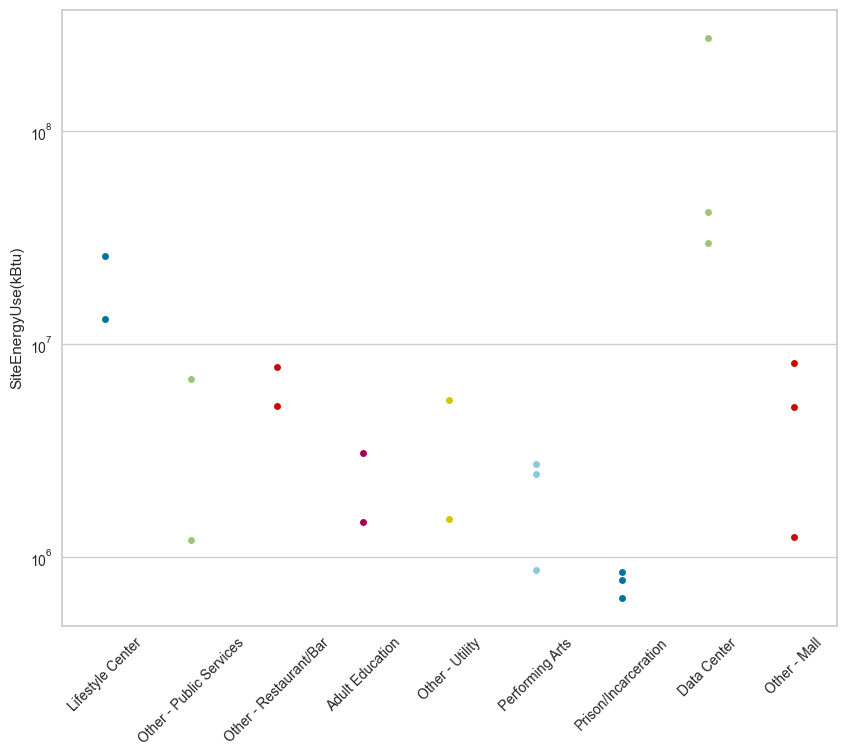

In [97]:
for cat in list_2_3_cat:
    sns.swarmplot(x=list_2_3_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][conso])

plt.xticks(ticks=[list_2_3_cat.index(cat) for cat in list_2_3_cat], labels=list_2_3_cat)
plt.xticks(rotation=45);
plt.yscale('log')

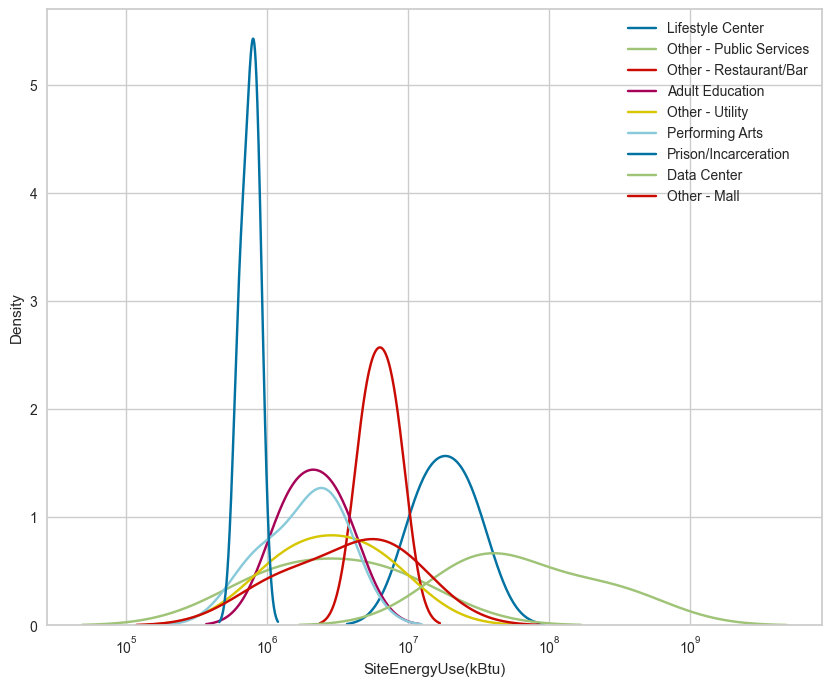

In [98]:
for cat in list_2_3_cat:
    sns.kdeplot(df[df['LargestPropertyUseType']==cat][conso], label=cat, log_scale=True)
plt.legend();

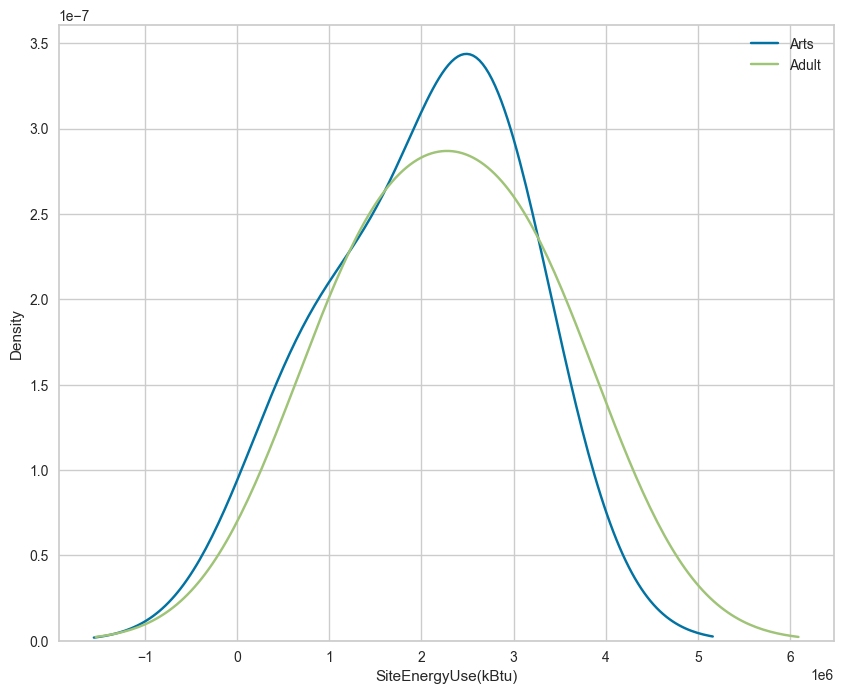

In [99]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Performing Arts'][conso], label='Arts')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Adult Education'][conso], label='Adult')
plt.legend();

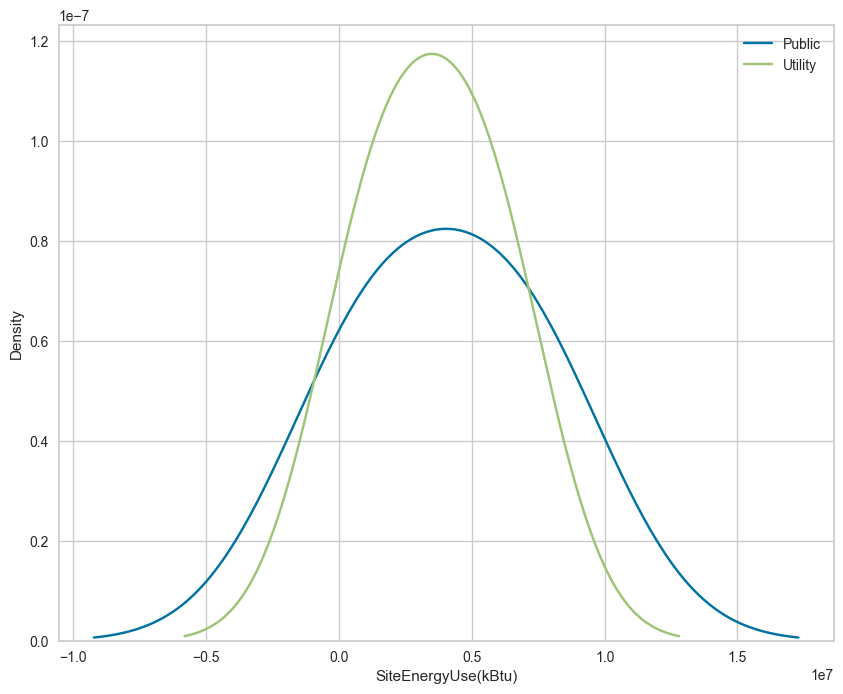

In [100]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Public Services'][conso], label='Public')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Utility'][conso], label='Utility')
plt.legend();

In [101]:
def replace_cat_lput(df, dict_regroup):
    new_df = df.copy()
    new_cat = ['x2_'+ft for ft in dict_regroup.values()][0]
    old_cats = ['x2_'+ft for ft in dict_regroup.keys()]
    new_df[new_cat] = 0 
    for cat in old_cats:
        new_df[new_cat] += new_df[cat]
        new_df.drop(columns=cat, inplace=True)
    return new_df

In [102]:
dict_replace.clear()
dict_replace[0] = {'Performing Arts':'grp_0', 'Adult Education':'grp_0'}
dict_replace[1] = {'Other - Public Services':'grp_1', 'Other - Utility':'grp_1', 'Other - Mall':'grp_1'}

In [103]:
for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_qt))

Regroupement de Performing Arts, Adult Education


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    819265.41  2169101003199.379883  1421330.24    0.71  1.49    0.01   
XGBoost  835496.12  2210206674752.990234  1438341.67    0.69  1.56    0.25   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

Regroupement de Other - Public Services, Other - Utility, Other - Mall


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820912.58  2172438341424.070068  1422978.82    0.71  1.49    0.01   
XGBoost  835723.05  2268590813559.390137  1454773.37    0.67  1.64    0.29   

           R²  
Model          
Ridge    0.75  
XGBoost  0.72

In [104]:
best_rmse[-1]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.25   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

> Aucun des regroupements ci-haut ne permet d'améliorer significativement le score **RMSE**, voyons s'il en est de même en les réalisant tous.

In [105]:
X_train_lput_tr_log_qt = df_ft_eng.copy()
for regroup in dict_replace.values():
    X_train_lput_tr_log_qt = replace_cat_lput(X_train_lput_tr_log_qt, regroup)

cross_val_promising_models(X_train_lput_tr_log_qt.to_numpy(), y_train_tr_qt)

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820000.17  2171687684918.909912  1422533.55    0.71  1.49     0.0   
XGBoost  834615.64  2291069499260.160156  1460876.45    0.67  1.68    0.25   

           R²  
Model          
Ridge    0.75  
XGBoost  0.72

> Nous n'obtentons pas un un meilleur score **RMSE**.

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 2 à 4 observations:

In [106]:
list_2_3_4_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==3].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==4].index)

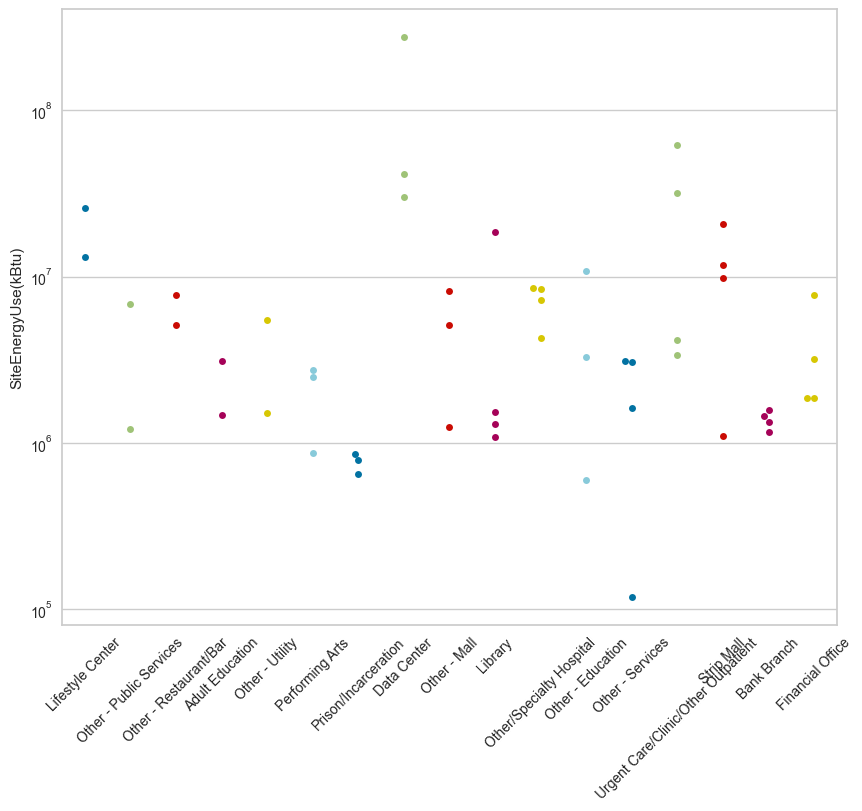

In [107]:
for cat in list_2_3_4_cat:
    sns.swarmplot(x=list_2_3_4_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][conso])

plt.xticks(ticks=[list_2_3_4_cat.index(cat) for cat in list_2_3_4_cat], labels=list_2_3_4_cat)
plt.xticks(rotation=45);
plt.yscale('log')

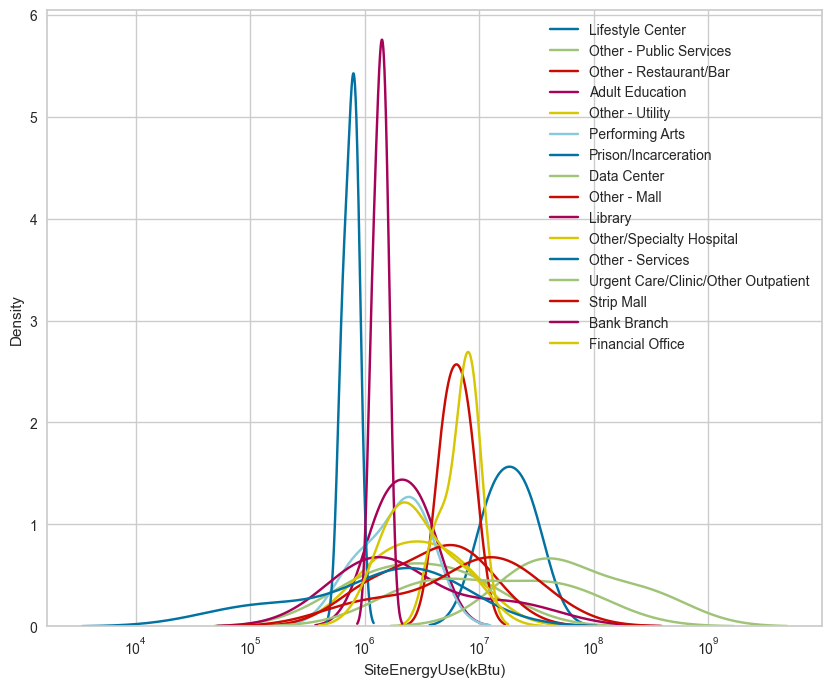

In [108]:
for cat in list_2_3_4_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][conso], label=cat, log_scale=True)
plt.legend();

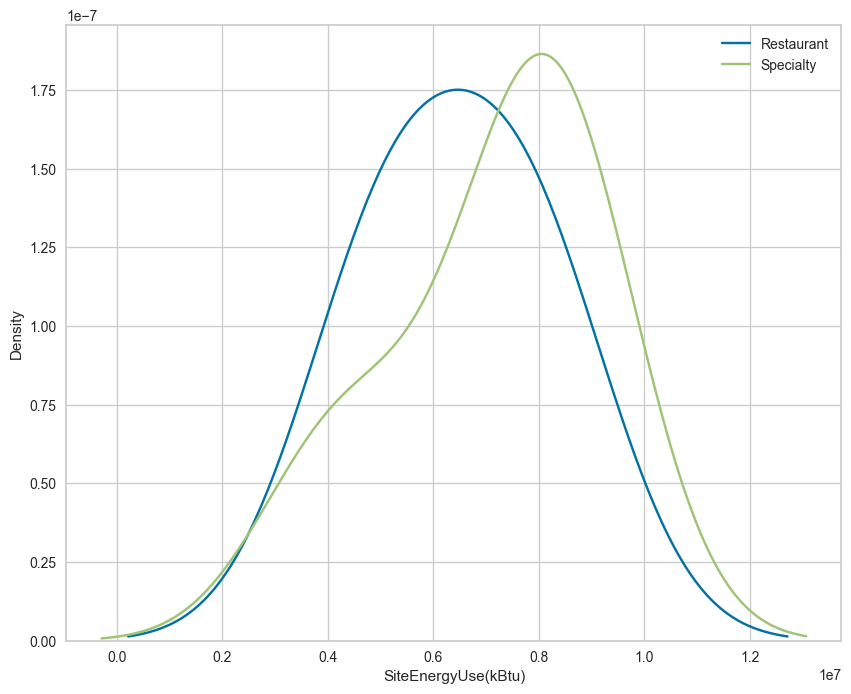

In [109]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Restaurant/Bar'][conso], label='Restaurant')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other/Specialty Hospital'][conso], label='Specialty')
plt.legend();

In [110]:
dict_replace.clear()
dict_replace[0] = {'Other - Restaurant/Bar':'grp_2', 'Other/Specialty Hospital':'grp_2'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_qt))

Regroupement de Other - Restaurant/Bar, Other/Specialty Hospital


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    819849.78  2170082370809.850098   1422063.6    0.71  1.49    0.01   
XGBoost  827494.41  2183294063769.719971  1430204.69    0.69  1.74    0.25   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

In [111]:
best_rmse[-1]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.25   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

> Nous n'améliorons pas le score **RMSE** grâce à ce regroupement.

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 2 à 5 observations:

In [112]:
list_2_to_5_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==3].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==4].index)+ list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==5].index)

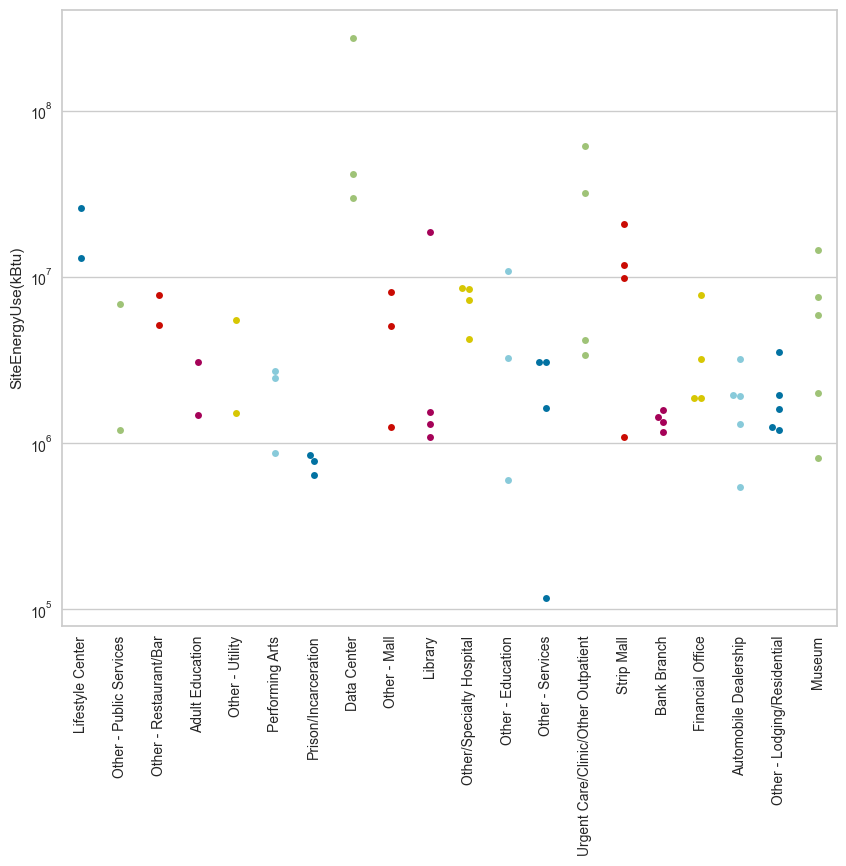

In [113]:
for cat in list_2_to_5_cat:
    sns.swarmplot(x=list_2_to_5_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][conso])

plt.xticks(ticks=[list_2_to_5_cat.index(cat) for cat in list_2_to_5_cat], labels=list_2_to_5_cat)
plt.xticks(rotation=90);
plt.yscale('log')

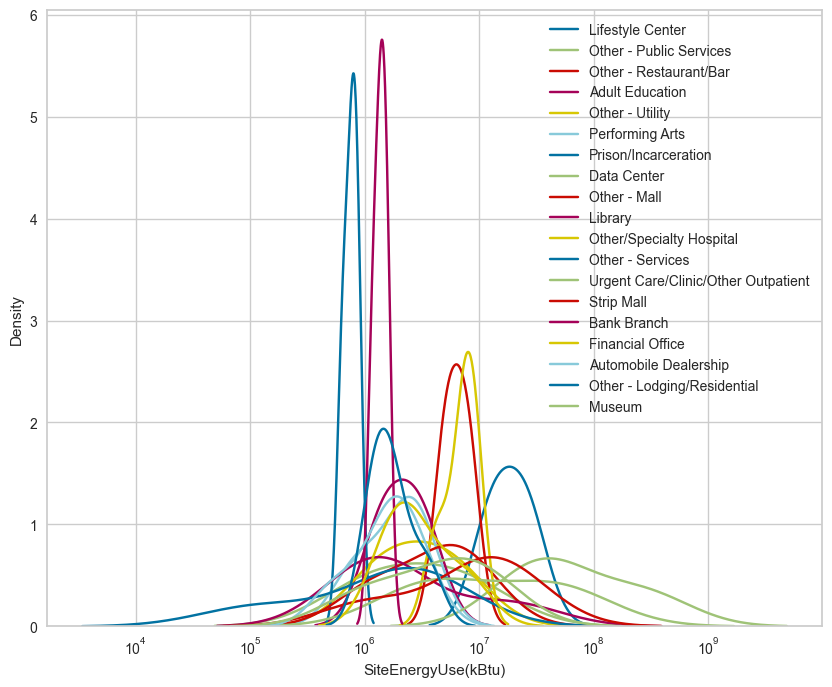

In [114]:
for cat in list_2_to_5_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][conso], label=cat, log_scale=True)
plt.legend();

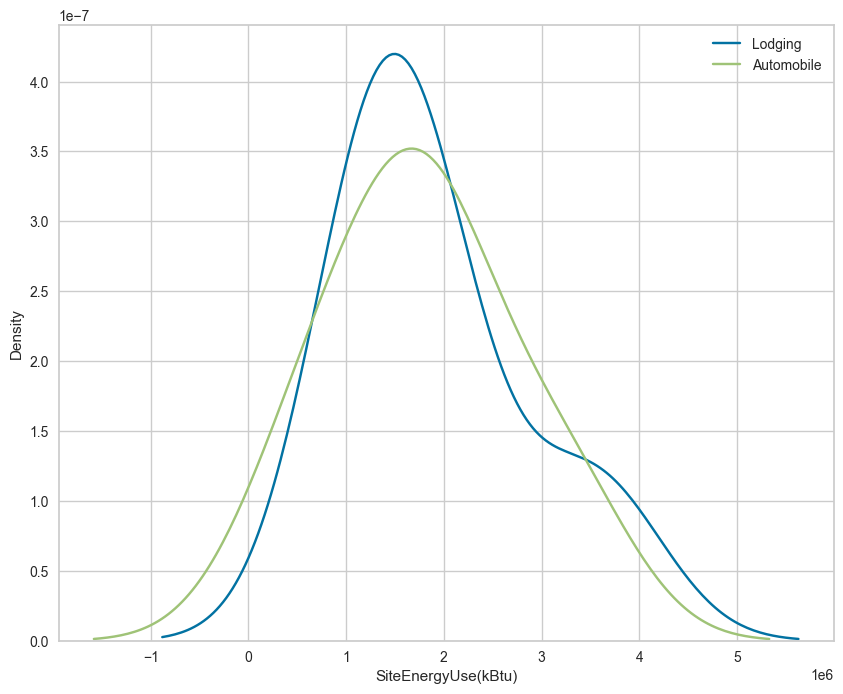

In [115]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Lodging/Residential'][conso], label='Lodging')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Automobile Dealership'][conso], label='Automobile')
plt.legend();

In [116]:
dict_replace.clear()
dict_replace[0] = {'Other - Lodging/Residential':'grp_4', 'Automobile Dealership':'grp_4'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_qt))

Regroupement de Other - Lodging/Residential, Automobile Dealership


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    821110.43  2170034398131.600098  1421915.88    0.71  1.49    0.01   
XGBoost  828198.31  2308575609167.609863  1468506.49    0.69  1.66    0.34   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

In [117]:
best_rmse[-1]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.25   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

> Ce regroupement ne permet pas d'améliorer le score **RMSE**.

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 2 à 9 observations:

In [118]:
list_2_to_9_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==3].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==4].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==5].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==6].index) + list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==7].index)+list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==8].index)+list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==9].index)

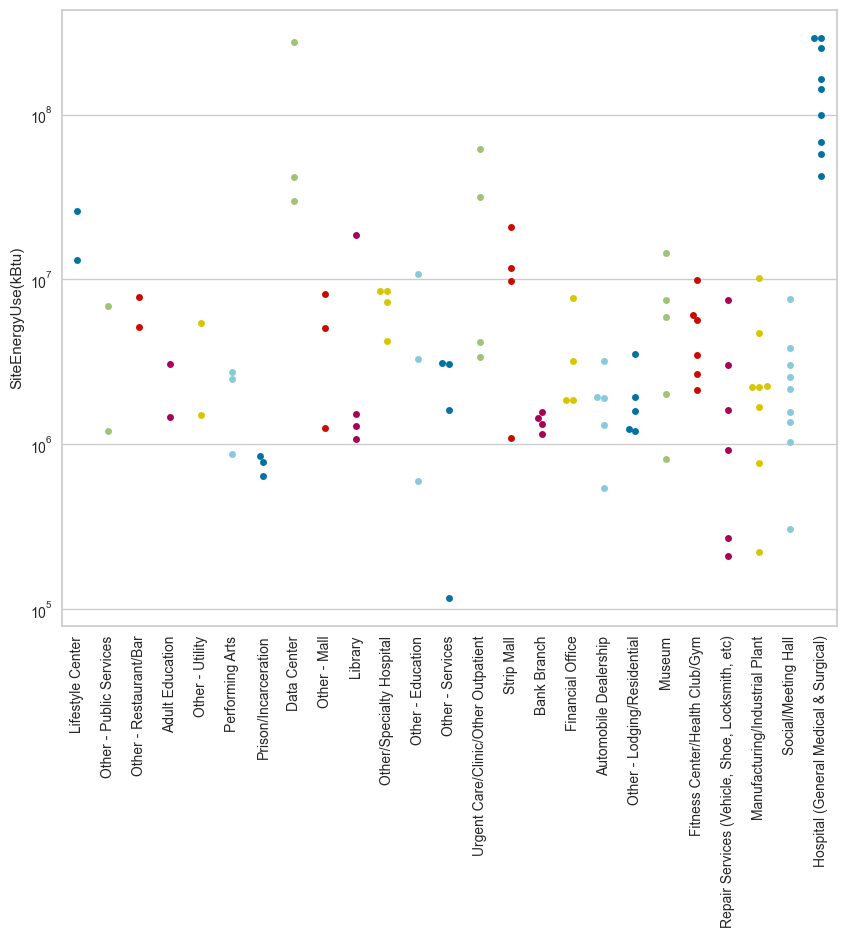

In [119]:
for cat in list_2_to_9_cat:
    sns.swarmplot(x=list_2_to_9_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][conso])

plt.xticks(ticks=[list_2_to_9_cat.index(cat) for cat in list_2_to_9_cat], labels=list_2_to_9_cat)
plt.xticks(rotation=90)
plt.yscale('log')

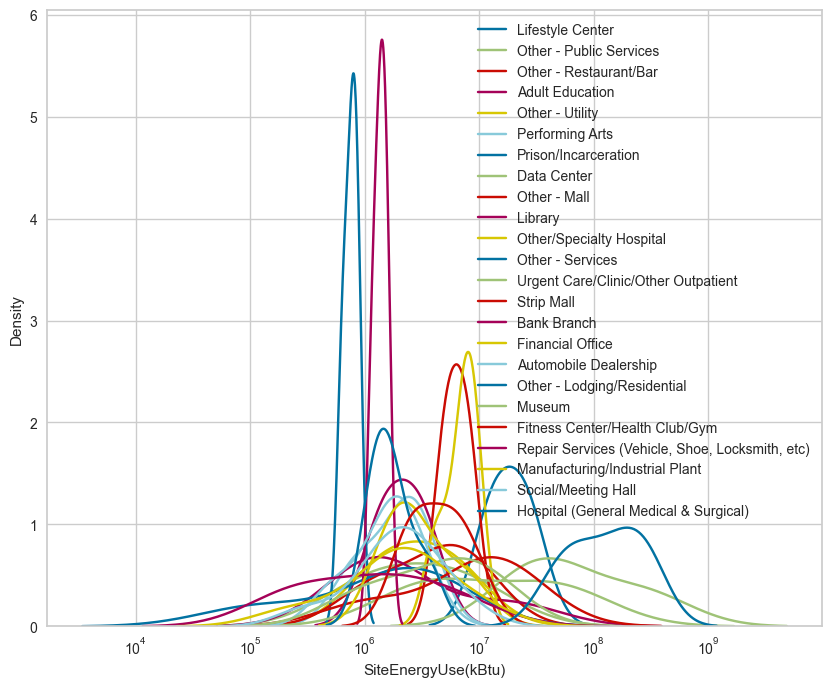

In [120]:
for cat in list_2_to_9_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][conso], label=cat, log_scale=True)
plt.legend();

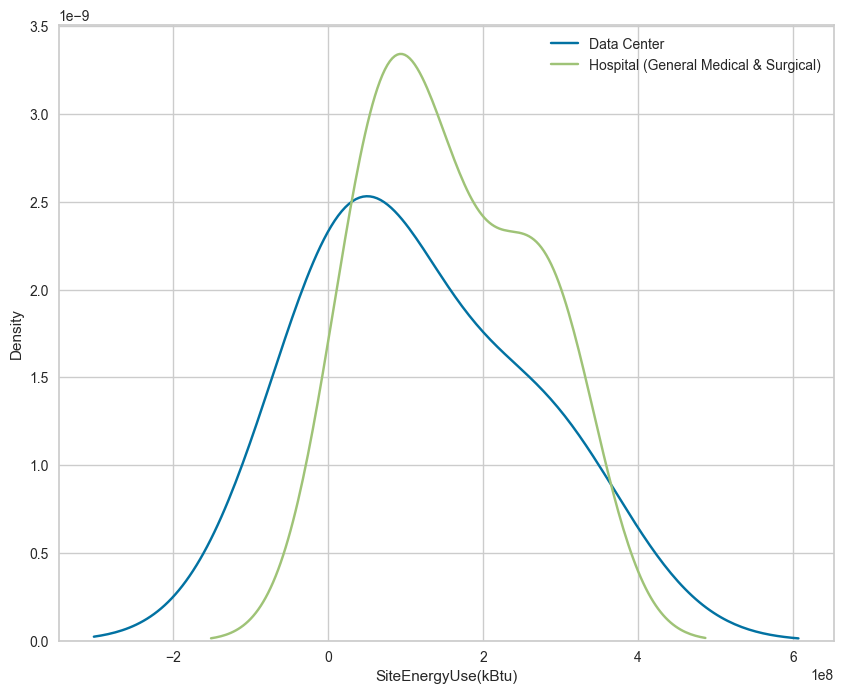

In [121]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Data Center'][conso], label='Data Center')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Hospital (General Medical & Surgical)'][conso], label='Hospital (General Medical & Surgical)')
plt.legend();

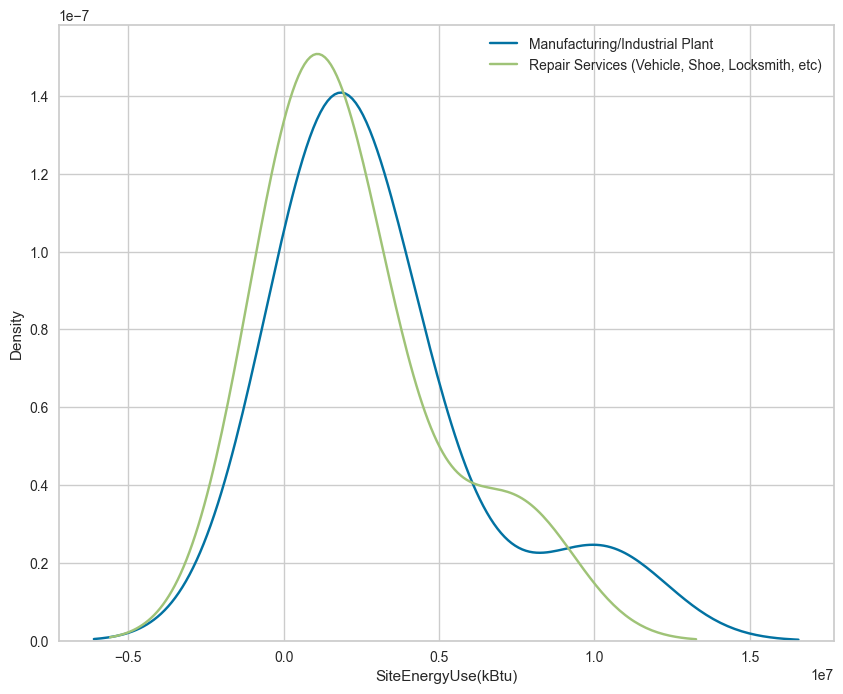

In [122]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Manufacturing/Industrial Plant'][conso], label='Manufacturing/Industrial Plant')
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Repair Services (Vehicle, Shoe, Locksmith, etc)'][conso], label='Repair Services (Vehicle, Shoe, Locksmith, etc)')
plt.legend();

In [123]:
dict_replace.clear()
dict_replace[0] = {'Manufacturing/Industrial Plant':'grp_5', 'Repair Services (Vehicle, Shoe, Locksmith, etc)':'grp_5'}
dict_replace[1] = {'Data Center':'grp_6', 'Hospital (General Medical & Surgical)':'grp_6'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_qt))

Regroupement de Manufacturing/Industrial Plant, Repair Services (Vehicle, Shoe, Locksmith, etc)


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    819424.35  2163888994883.050049  1419495.22    0.71  1.49    0.01   
XGBoost  843460.42   2195067198593.26001  1437902.35    0.69  1.76    0.32   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

Regroupement de Data Center, Hospital (General Medical & Surgical)


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    822538.99  2233716023875.839844  1437252.66     0.7  1.49     0.0   
XGBoost  852106.63  2512222736106.540039  1539757.77    0.65  1.68    0.33   

           R²  
Model          
Ridge    0.74  
XGBoost  0.70

In [196]:
best_rmse[-1]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.25   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

> Aucun des regroupements précédents ne permet d'améliorer significativement le score **RMSE**.

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 2 à 16 observations:

In [125]:
list_2_to_16_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index)
for i in range(3,17):
    list_2_to_16_cat += list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==i].index)

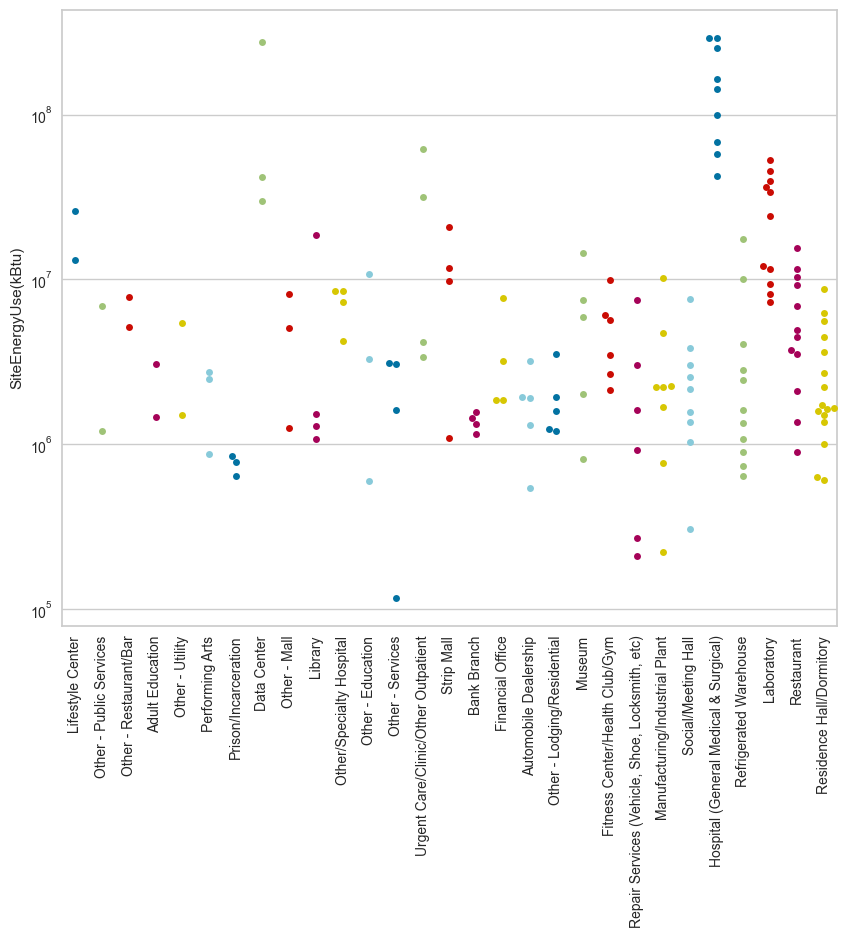

In [126]:
for cat in list_2_to_16_cat:
    sns.swarmplot(x=list_2_to_16_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][conso])

plt.xticks(ticks=[list_2_to_16_cat.index(cat) for cat in list_2_to_16_cat], labels=list_2_to_16_cat)
plt.xticks(rotation=90)
plt.yscale('log')

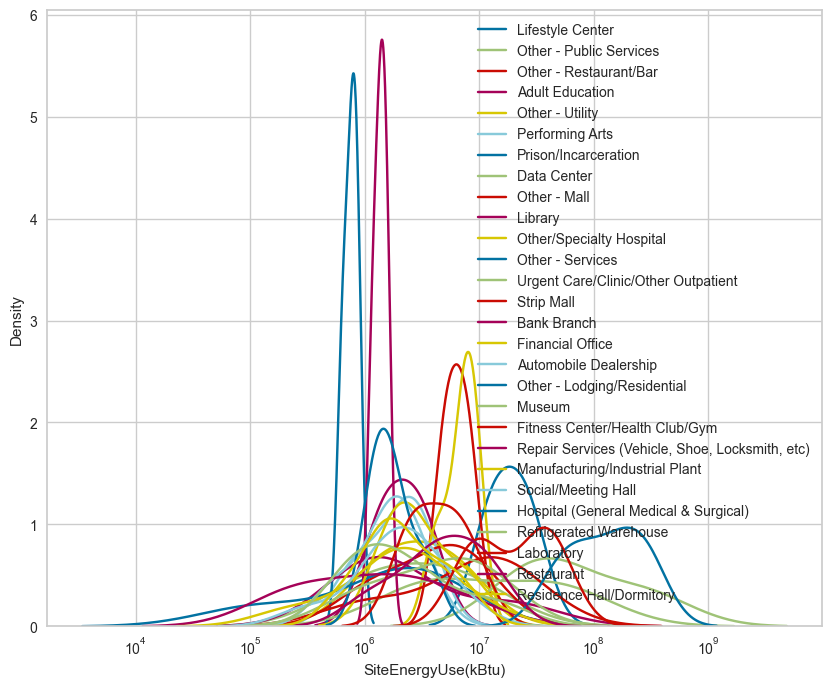

In [127]:
for cat in list_2_to_16_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][conso], label=cat, log_scale=True)
plt.legend();

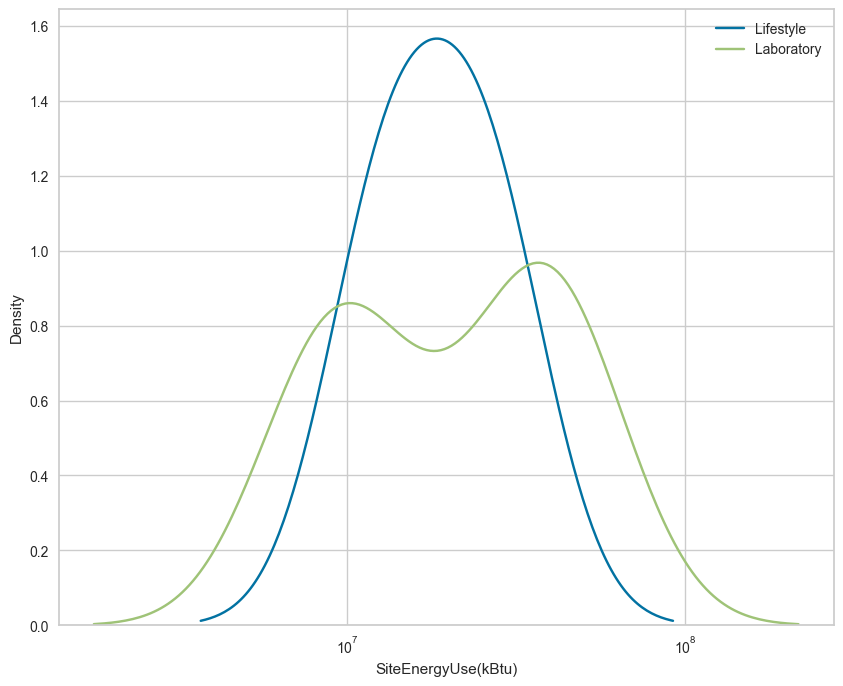

In [128]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Lifestyle Center'][conso], label='Lifestyle', log_scale=True)
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Laboratory'][conso], label='Laboratory', log_scale=True)
plt.legend();

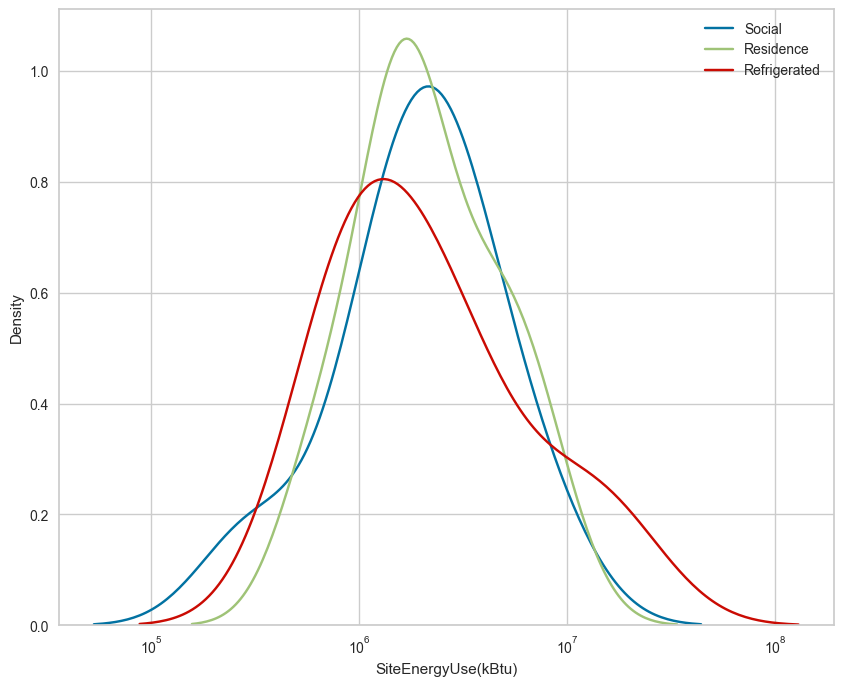

In [129]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Social/Meeting Hall'][conso], label='Social', log_scale=True)
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Residence Hall/Dormitory'][conso], label='Residence', log_scale=True)
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Refrigerated Warehouse'][conso], label='Refrigerated', log_scale=True)
plt.legend();

In [130]:
dict_replace.clear()
dict_replace[0] = {'Lifestyle Center':'grp_7', 'Laboratory':'grp_7'}
dict_replace[1] = {'Social/Meeting Hall':'grp_8', 'Residence Hall/Dormitory':'grp_8', 'Refrigerated Warehouse':'grp_8'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_qt))

Regroupement de Lifestyle Center, Laboratory


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820726.02  2180925055230.820068  1425737.89     0.7  1.49    0.01   
XGBoost   834777.3  2258722185994.899902  1456483.68    0.68  1.67    0.45   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

Regroupement de Social/Meeting Hall, Residence Hall/Dormitory, Refrigerated Warehouse


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820449.05   2170150183369.52002  1421967.68    0.71  1.49    0.01   
XGBoost  838105.55  2176346757370.100098   1432761.2    0.69  1.71    0.34   

           R²  
Model          
Ridge    0.75  
XGBoost  0.73

In [131]:
best_rmse[-1]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.25   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

> Aucun des regroupements ne permet d'améliorer significativement le score **RMSE**

Essayons d'opérer des regroupements entre les modalités ayant une effectif de 4 à 26 observations:

In [132]:
list_4_to_26_cat = list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==2].index)
for i in range(4,41):
    list_4_to_26_cat += list(df_lput['LargestPropertyUseType'].value_counts()[df_lput['LargestPropertyUseType'].value_counts()==i].index)

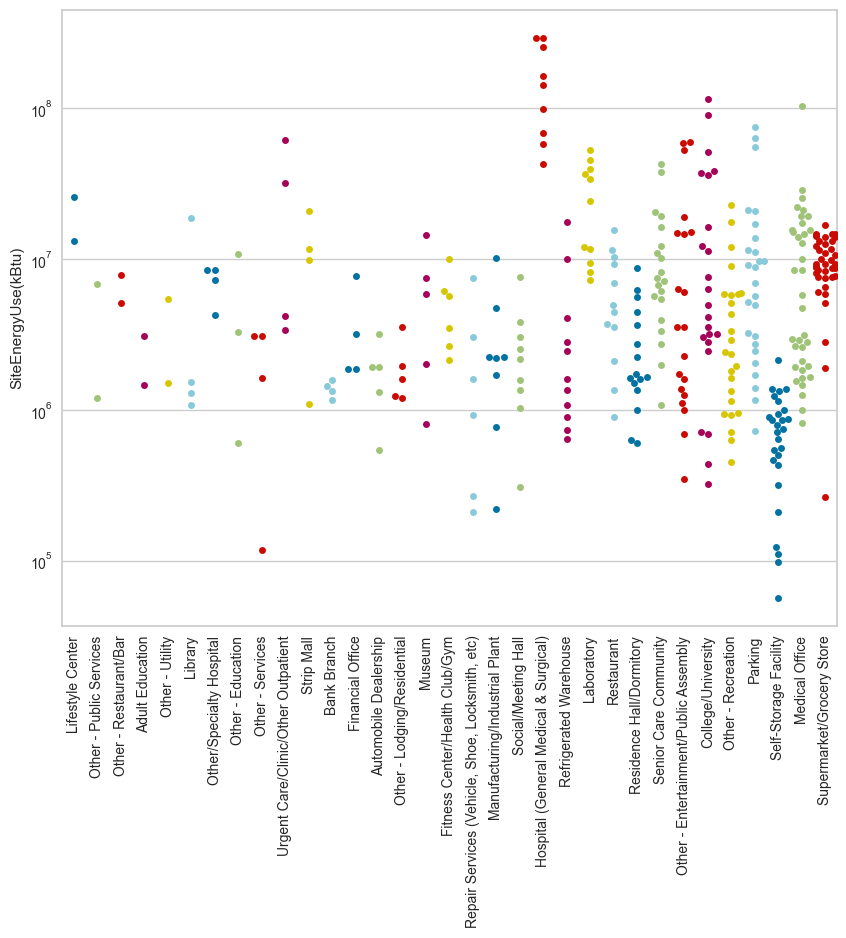

In [133]:
for cat in list_4_to_26_cat:
    sns.swarmplot(x=list_4_to_26_cat.index(cat), y=df_lput[df_lput['LargestPropertyUseType']==cat][conso])

plt.xticks(ticks=[list_4_to_26_cat.index(cat) for cat in list_4_to_26_cat], labels=list_4_to_26_cat)
plt.xticks(rotation=90)
plt.yscale('log')

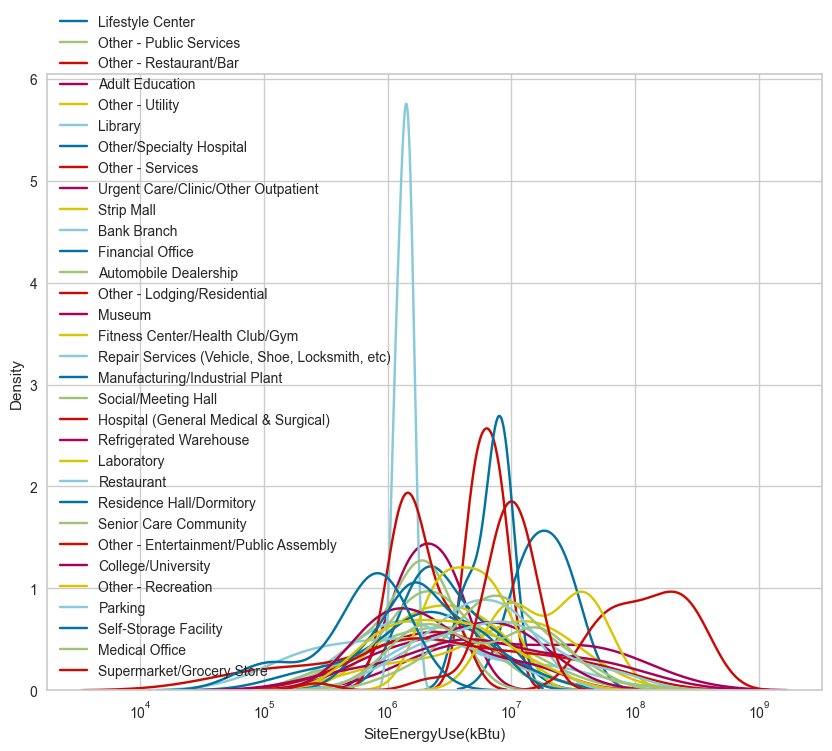

In [134]:
for cat in list_4_to_26_cat:
    sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']==cat][conso], label=cat, log_scale=True)
plt.legend();

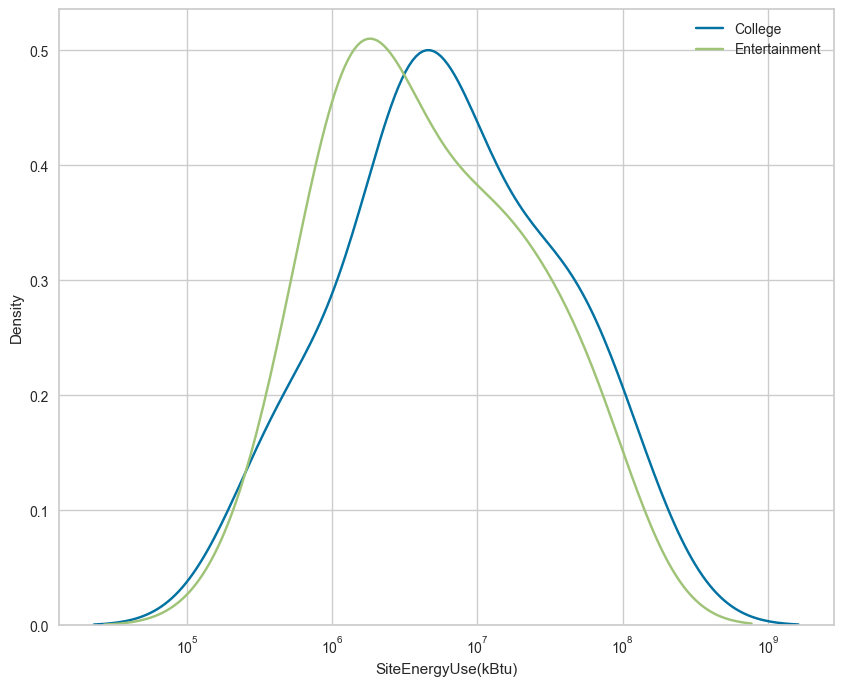

In [135]:
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'College/University'][conso], label='College', log_scale=True)
sns.kdeplot(df_lput[df_lput['LargestPropertyUseType']== 'Other - Entertainment/Public Assembly'][conso], label='Entertainment', log_scale=True)
plt.legend();

In [136]:
dict_replace.clear()
dict_replace[0] = {'College/University':'grp_9', 'Other - Entertainment/Public Assembly':'grp_9'}

for regroup in dict_replace.values():
    
    X_train_lput_tr_log_qt = replace_cat_lput(df_ft_eng, regroup).to_numpy()
    
    print("Regroupement de "+', '.join([key for key in regroup.keys()]))
    
    display(cross_val_promising_models(X_train_lput_tr_log_qt, y_train_tr_qt))

Regroupement de College/University, Other - Entertainment/Public Assembly


MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    820084.41  2168819512211.350098  1421743.57    0.71  1.49    0.01   
XGBoost  847403.87  2364977109350.379883  1488793.71    0.66  1.74    0.27   

           R²  
Model          
Ridge    0.75  
XGBoost  0.71

In [137]:
best_rmse[-1]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.25   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

> Ce regroupement ne permet pas d'améliorer le score **RMSE**.

Tout notre travail sur le regroupement de modalités au sein des variables catégorielles jusqu'à présent nous a permis d'améliorer notre score **RMSE**.

Cependant, les 2 variables **PrimaryPropertyType** et **LargestPropertyType** reflètant la même chose, la diversité des types d'usage des bâtiments, mais avec une granularité différente, nous pouvons donc légitimement nous demander si l'une ou l'autre apporte une information redondante et si nous obtiendrions de meilleurs résultats sans l'une des 2.

C'est ce que nous allons vérifier :

In [138]:
X_train_tr_qt_log_wo_x1 = df_train_qt_log.drop(columns=dict_cols_grps['PrimaryPropertyType']).to_numpy()
X_train_tr_qt_log_wo_x2 = df_train_qt_log.drop(columns=dict_cols_grps['LargestPropertyUseType']).to_numpy()

In [139]:
cross_val_promising_models(X_train_tr_qt_log_wo_x1, y_train_tr_qt)

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    819197.94  2152493357908.350098  1419061.31    0.71  1.49     0.0   
XGBoost  842494.43  2305635760921.100098  1468853.67    0.68  1.74    0.24   

           R²  
Model          
Ridge    0.75  
XGBoost  0.72

In [140]:
cross_val_promising_models(X_train_tr_qt_log_wo_x2, y_train_tr_qt)

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
Ridge    828787.62  2546050268087.899902  1509848.49    0.67  1.48     0.0   
XGBoost  865051.11   2618248164224.27002  1546630.95    0.65  1.83    0.48   

           R²  
Model          
Ridge    0.70  
XGBoost  0.68

In [141]:
best_rmse[-1]

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                        
XGBoost  825455.43       2120284505178.5  1410378.33     0.7  1.69    0.25   
Ridge    820182.89  2170088615810.439941  1421874.13    0.71  1.49     0.0   

           R²  
Model          
XGBoost  0.74  
Ridge    0.75

Nous obtenons un score **RMSE** sans la variable **PrimaryPropertyType** qui est proche de celui que nous obtenons suite à notre travail précédent de feature engineering pour le modèle **Ridge**.

Plus généralement, vérifions si nous pouvons obtenir de meilleurs résultats si nous retirons certaines de nos variables du jeu de données : 

In [142]:
def cross_val(X_train, y_train, model):
    
    name_mdl = model
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[name_mdl]
                     )
        
    dict_results ={
                    'MAE':[],
                    'MSE':[], 
                    'RMSE':[],
                    'adj. R²':[],
                    'R²':[],
                    'RMSLE':[],
                    'TT(sec)':[]
            }

    for train_index, test_index in kfold.split(X):
        mdl = clone(promising_models_to_train[name_mdl])

        start_fit_time = timeit.default_timer()
        mdl.fit(X[train_index], y[train_index])
        fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
        dict_results['TT(sec)'].append(fit_duration)

        y_pred_qt = mdl.predict(X[test_index])

        for mtr_name, metric in metrics.items():
            score = metric(y_true=np.abs(target_prepro_qt.inverse_transform(y))[test_index], 
                           y_pred=np.abs(target_prepro_qt.inverse_transform(y_pred_qt.reshape(-1,1))))
            if mtr_name in ('RMSE','RMSLE'):
                score = np.sqrt(score)
            elif mtr_name == 'adj. R²':
                score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
            dict_results[mtr_name].append(score)

    for mtr_name, scores in dict_results.items():            
        df.loc[name_mdl, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

In [143]:
min_to_beat_ridge = 1424806.76 # meilleur score RMSE obtenu suite au pré-traitement des variables numérique
dict_rmse_drop_ridge_0 = dict()

for key, value in dict_cols_grps.items():
    X_drop = df_train_qt_log.drop(columns=value).to_numpy()
    new_rmse = cross_val(X_drop, y_train_tr_qt, 'Ridge')['RMSE'][0]
    if new_rmse < min_to_beat_ridge:
        dict_rmse_drop_ridge_0[key] = new_rmse
        
dict_rmse_drop_ridge_0

{'Longitude': 1419358.41,
 'NumberofFloors': 1417747.05,
 'PropertyGFATotal': 1422219.51,
 'SecondLargestPropertyUseTypeGFA': 1422359.16,
 'ThirdLargestPropertyUseTypeGFA': 1410081.8,
 'YearBuilt': 1424596.0,
 'PrimaryPropertyType': 1419061.31}

In [144]:
dict_rmse_drop_ridge_1 = dict()

for key_0, value in dict_rmse_drop_ridge_0.items():
    dict_rmse_drop_ridge_1[key_0] = dict()
    dict_tmp = dict_cols_grps.copy()
    df_tmp = df_train_qt_log.drop(columns=dict_tmp[key_0])
    del dict_tmp[key_0]
    
    for key_1 in dict_tmp.keys():
        X_drop = df_tmp.drop(columns=dict_tmp[key_1]).to_numpy()
        new_rmse = cross_val(X_drop, y_train_tr_qt, 'Ridge')['RMSE'][0]
        if new_rmse < value:
            dict_rmse_drop_ridge_1[key_0][key_1] = new_rmse

dict_rmse_drop_ridge_1

{'Longitude': {'NumberofFloors': 1411756.15,
  'PropertyGFATotal': 1417773.81,
  'SecondLargestPropertyUseTypeGFA': 1409664.28,
  'ThirdLargestPropertyUseTypeGFA': 1408790.67,
  'PrimaryPropertyType': 1415820.71},
 'NumberofFloors': {'Longitude': 1411756.15,
  'PropertyGFATotal': 1415227.82,
  'ThirdLargestPropertyUseTypeGFA': 1405725.61,
  'PrimaryPropertyType': 1417201.78},
 'PropertyGFATotal': {'Longitude': 1417773.81,
  'NumberofFloors': 1415227.82,
  'SecondLargestPropertyUseTypeGFA': 1421734.3,
  'ThirdLargestPropertyUseTypeGFA': 1407687.03,
  'PrimaryPropertyType': 1418341.96},
 'SecondLargestPropertyUseTypeGFA': {'Longitude': 1409664.28,
  'PropertyGFATotal': 1421734.3,
  'ThirdLargestPropertyUseTypeGFA': 1418262.01},
 'ThirdLargestPropertyUseTypeGFA': {'Longitude': 1408790.67,
  'NumberofFloors': 1405725.61,
  'PropertyGFATotal': 1407687.03,
  'YearBuilt': 1406991.55,
  'PrimaryPropertyType': 1410003.96},
 'YearBuilt': {'Longitude': 1419515.6,
  'NumberofFloors': 1422310.69,
 

In [145]:
dict_rmse_drop_ridge = dict()
dict_rmse_drop_ridge[1] = dict_rmse_drop_ridge_0
dict_rmse_drop_ridge

{1: {'Longitude': 1419358.41,
  'NumberofFloors': 1417747.05,
  'PropertyGFATotal': 1422219.51,
  'SecondLargestPropertyUseTypeGFA': 1422359.16,
  'ThirdLargestPropertyUseTypeGFA': 1410081.8,
  'YearBuilt': 1424596.0,
  'PrimaryPropertyType': 1419061.31}}

In [146]:
dict_rmse_drop_ridge[2] = dict()
for k0, value in dict_rmse_drop_ridge_1.items():
    for k1, rmse in value.items():
        dict_rmse_drop_ridge[2][k0,k1]=rmse
dict_rmse_drop_ridge[2]

{('Longitude', 'NumberofFloors'): 1411756.15,
 ('Longitude', 'PropertyGFATotal'): 1417773.81,
 ('Longitude', 'SecondLargestPropertyUseTypeGFA'): 1409664.28,
 ('Longitude', 'ThirdLargestPropertyUseTypeGFA'): 1408790.67,
 ('Longitude', 'PrimaryPropertyType'): 1415820.71,
 ('NumberofFloors', 'Longitude'): 1411756.15,
 ('NumberofFloors', 'PropertyGFATotal'): 1415227.82,
 ('NumberofFloors', 'ThirdLargestPropertyUseTypeGFA'): 1405725.61,
 ('NumberofFloors', 'PrimaryPropertyType'): 1417201.78,
 ('PropertyGFATotal', 'Longitude'): 1417773.81,
 ('PropertyGFATotal', 'NumberofFloors'): 1415227.82,
 ('PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA'): 1421734.3,
 ('PropertyGFATotal', 'ThirdLargestPropertyUseTypeGFA'): 1407687.03,
 ('PropertyGFATotal', 'PrimaryPropertyType'): 1418341.96,
 ('SecondLargestPropertyUseTypeGFA', 'Longitude'): 1409664.28,
 ('SecondLargestPropertyUseTypeGFA', 'PropertyGFATotal'): 1421734.3,
 ('SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA'): 14182

In [147]:
i=3
while True:
    dict_rmse_drop_ridge[i] = dict()

    for feats_to_drop, rmse in dict_rmse_drop_ridge[i-1].items():

        list_to_drop = list(feats_to_drop)
        dict_tmp = dict_cols_grps.copy()

        for feat_to_drop in list_to_drop:
            df_tmp = df_train_qt_log.drop(columns=dict_tmp[feat_to_drop])
            del dict_tmp[feat_to_drop]

        for feature in dict_tmp.keys():
            X_drop = df_tmp.drop(columns=dict_tmp[feature]).to_numpy()
            new_rmse = cross_val(X_drop, y_train_tr_qt, 'Ridge')['RMSE'][0]
            if new_rmse < rmse:
                new_fts_to_drop = list_to_drop.copy()
                new_fts_to_drop.append(feature)
                new_fts_to_drop = tuple(new_fts_to_drop)
                dict_rmse_drop_ridge[i][new_fts_to_drop] = new_rmse
                
    if len(dict_rmse_drop_ridge[i])==0:
        break
    else:
        print(f"Élimination de {i} variables:\n")
        display(dict_rmse_drop_ridge[i])
        i += 1

Élimination de 3 variables:



{('Longitude', 'NumberofFloors', 'ThirdLargestPropertyUseTypeGFA'): 1405725.61,
 ('Longitude', 'PropertyGFATotal', 'NumberofFloors'): 1415227.82,
 ('Longitude',
  'PropertyGFATotal',
  'ThirdLargestPropertyUseTypeGFA'): 1407687.03,
 ('Longitude', 'ThirdLargestPropertyUseTypeGFA', 'NumberofFloors'): 1405725.61,
 ('Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'PropertyGFATotal'): 1407687.03,
 ('Longitude', 'ThirdLargestPropertyUseTypeGFA', 'YearBuilt'): 1406991.55,
 ('Longitude',
  'PrimaryPropertyType',
  'ThirdLargestPropertyUseTypeGFA'): 1410003.96,
 ('NumberofFloors',
  'Longitude',
  'SecondLargestPropertyUseTypeGFA'): 1409664.28,
 ('NumberofFloors', 'Longitude', 'ThirdLargestPropertyUseTypeGFA'): 1408790.67,
 ('NumberofFloors',
  'PropertyGFATotal',
  'ThirdLargestPropertyUseTypeGFA'): 1407687.03,
 ('NumberofFloors', 'PrimaryPropertyType', 'Longitude'): 1415820.71,
 ('NumberofFloors',
  'PrimaryPropertyType',
  'ThirdLargestPropertyUseTypeGFA'): 1410003.96,
 ('PropertyGFATotal

Élimination de 4 variables:



{('Longitude',
  'PropertyGFATotal',
  'NumberofFloors',
  'ThirdLargestPropertyUseTypeGFA'): 1405725.61,
 ('Longitude',
  'PropertyGFATotal',
  'ThirdLargestPropertyUseTypeGFA',
  'NumberofFloors'): 1405725.61,
 ('Longitude',
  'PropertyGFATotal',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('Longitude',
  'PrimaryPropertyType',
  'ThirdLargestPropertyUseTypeGFA',
  'NumberofFloors'): 1405725.61,
 ('Longitude',
  'PrimaryPropertyType',
  'ThirdLargestPropertyUseTypeGFA',
  'PropertyGFATotal'): 1407687.03,
 ('Longitude',
  'PrimaryPropertyType',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('NumberofFloors',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'PropertyGFATotal'): 1407687.03,
 ('NumberofFloors',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('NumberofFloors',
  'PropertyGFATotal',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('NumberofFloors',
  'PrimaryPropertyType',
  'Long

Élimination de 5 variables:



{('NumberofFloors',
  'PrimaryPropertyType',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'PropertyGFATotal'): 1407687.03,
 ('NumberofFloors',
  'PrimaryPropertyType',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('PropertyGFATotal',
  'Longitude',
  'PrimaryPropertyType',
  'ThirdLargestPropertyUseTypeGFA',
  'NumberofFloors'): 1405725.61,
 ('PropertyGFATotal',
  'Longitude',
  'PrimaryPropertyType',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('PropertyGFATotal',
  'NumberofFloors',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('PropertyGFATotal',
  'SecondLargestPropertyUseTypeGFA',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'NumberofFloors'): 1405725.61,
 ('PropertyGFATotal',
  'SecondLargestPropertyUseTypeGFA',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('PropertyGFATotal',
  'PrimaryPropertyType',
  'Longitude',
  'NumberofFloors',
  'T

Élimination de 6 variables:



{('PropertyGFATotal',
  'PrimaryPropertyType',
  'NumberofFloors',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('SecondLargestPropertyUseTypeGFA',
  'PropertyGFATotal',
  'Longitude',
  'PrimaryPropertyType',
  'ThirdLargestPropertyUseTypeGFA',
  'NumberofFloors'): 1405725.61,
 ('SecondLargestPropertyUseTypeGFA',
  'PropertyGFATotal',
  'Longitude',
  'PrimaryPropertyType',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('SecondLargestPropertyUseTypeGFA',
  'PropertyGFATotal',
  'NumberofFloors',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55,
 ('SecondLargestPropertyUseTypeGFA',
  'PropertyGFATotal',
  'PrimaryPropertyType',
  'Longitude',
  'NumberofFloors',
  'ThirdLargestPropertyUseTypeGFA'): 1405725.61,
 ('SecondLargestPropertyUseTypeGFA',
  'PropertyGFATotal',
  'PrimaryPropertyType',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'NumberofFloors'): 1405725.61,
 ('SecondLargestPropertyUseTy

Élimination de 7 variables:



{('SecondLargestPropertyUseTypeGFA',
  'PropertyGFATotal',
  'PrimaryPropertyType',
  'NumberofFloors',
  'Longitude',
  'ThirdLargestPropertyUseTypeGFA',
  'YearBuilt'): 1406991.55}

En épurant les variables de notre jeu de données, pour le modèle **Ridge**, nous passons d'un score **RMSE** de *1424806.76* à *1405725.61* soit 1.3% d'amélioration, et ce qui est meilleur que le score obtenu suite à notre travail de feature engineering.

Faisons la même chose pour le modèle **XGBoost** :

In [148]:
min_to_beat_xgb = 1460659.91
dict_rmse_drop_xgb_0 = dict()

for key, value in dict_cols_grps.items():
    X_drop = df_train_qt_log.drop(columns=value).to_numpy()
    new_rmse = cross_val(X_drop, y_train_tr_qt, 'XGBoost')['RMSE'][0]
    if new_rmse < min_to_beat_xgb:
        dict_rmse_drop_xgb_0[key] = new_rmse
        
dict_rmse_drop_xgb_0

{'PropertyGFABuilding(s)': 1449375.97,
 'ThirdLargestPropertyUseTypeGFA': 1443734.62,
 'SecondLargestPropertyUseType': 1453802.36}

In [149]:
dict_rmse_drop_xgb_1 = dict()

for key_0, value in dict_rmse_drop_xgb_0.items():
    dict_rmse_drop_xgb_1[key_0] = dict()
    dict_tmp = dict_cols_grps.copy()
    df_tmp = df_train_qt_log.drop(columns=dict_tmp[key_0])
    del dict_tmp[key_0]
    
    for key_1 in dict_tmp.keys():
        X_drop = df_tmp.drop(columns=dict_tmp[key_1]).to_numpy()
        new_rmse = cross_val(X_drop, y_train_tr_qt, 'XGBoost')['RMSE'][0]
        if new_rmse < value:
            dict_rmse_drop_xgb_1[key_0][key_1] = new_rmse

dict_rmse_drop_xgb_1

{'PropertyGFABuilding(s)': {'YearBuilt': 1420669.64},
 'ThirdLargestPropertyUseTypeGFA': {'Longitude': 1431709.32},
 'SecondLargestPropertyUseType': {'ThirdLargestPropertyUseTypeGFA': 1447710.71}}

In [150]:
dict_rmse_drop_xgb = dict()
dict_rmse_drop_xgb[1] = dict_rmse_drop_xgb_0
dict_rmse_drop_xgb

{1: {'PropertyGFABuilding(s)': 1449375.97,
  'ThirdLargestPropertyUseTypeGFA': 1443734.62,
  'SecondLargestPropertyUseType': 1453802.36}}

In [151]:
dict_rmse_drop_xgb[2] = dict()
for k0, value in dict_rmse_drop_xgb_1.items():
    for k1, rmse in value.items():
        dict_rmse_drop_xgb[2][k0,k1]=rmse
dict_rmse_drop_xgb[2]

{('PropertyGFABuilding(s)', 'YearBuilt'): 1420669.64,
 ('ThirdLargestPropertyUseTypeGFA', 'Longitude'): 1431709.32,
 ('SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA'): 1447710.71}

In [152]:
i=3
while True:
    dict_rmse_drop_xgb[i] = dict()

    for feats_to_drop, rmse in dict_rmse_drop_xgb[i-1].items():

        list_to_drop = list(feats_to_drop)
        dict_tmp = dict_cols_grps.copy()

        for feat_to_drop in list_to_drop:
            df_tmp = df_train_qt_log.drop(columns=dict_tmp[feat_to_drop])
            del dict_tmp[feat_to_drop]

        for feature in dict_tmp.keys():
            X_drop = df_tmp.drop(columns=dict_tmp[feature]).to_numpy()
            new_rmse = cross_val(X_drop, y_train_tr_qt, 'XGBoost')['RMSE'][0]
            if new_rmse < rmse:
                new_fts_to_drop = list_to_drop.copy()
                new_fts_to_drop.append(feature)
                new_fts_to_drop = tuple(new_fts_to_drop)
                dict_rmse_drop_xgb[i][new_fts_to_drop] = new_rmse
                
    if len(dict_rmse_drop_xgb[i])==0:
        break
    else:
        print(f"Élimination de {i} variables:\n")
        display(dict_rmse_drop_xgb[i])
        i += 1

Élimination de 3 variables:



{('PropertyGFABuilding(s)', 'YearBuilt', 'PrimaryPropertyType'): 1419030.71,
 ('SecondLargestPropertyUseType',
  'ThirdLargestPropertyUseTypeGFA',
  'Longitude'): 1431709.32}

En épurant les variables de notre jeu de données, pour le modèle **XGBoost**, nous passons d'un score **RMSE** de *1460659.91* à *1419030.71* soit **2.8%** d'amélioration. Cependant nous n'améliorons pas le score **RMSE** par rapport à nos étapes précédentes de feature engineering.

# Importance de la variable ENERGYSTARScore

Vérifions maintenant si l'ajout de la variable **ENERGYSTARScore** à notre jeu de données permet d'améliorer les résultats de nos modèles phares, puis nous reconduirons notre élagage de variables à partir de ce jeu de données augmenté :

In [153]:
df = data.copy()
df.drop(columns='TotalGHGEmissions', inplace=True)

In [154]:
conso = 'SiteEnergyUse(kBtu)'

cat_features = ['Neighborhood', 'PrimaryPropertyType',
                'LargestPropertyUseType',
                'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType']

num_features = ['LargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'NumberofBuildings', 
                     'NumberofFloors', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal',
                     'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'YearBuilt', 'ENERGYSTARScore']

log_features = ['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA', 
                'ThirdLargestPropertyUseTypeGFA']

std_features = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
                'PropertyGFAParking', 'YearBuilt', 'ENERGYSTARScore']

In [155]:
df = df[num_features+cat_features+[conso]]

In [156]:
from sklearn.model_selection import train_test_split

X_train_star, _, y_train_star, _ = train_test_split(df.drop(columns=conso),df[conso], test_size=0.2, random_state=SEED)

X_train_star.reset_index(drop=True, inplace=True)
y_train_star.reset_index(drop=True, inplace=True)

In [157]:
cat_features_ind = [X_train_star.columns.get_loc(ft) for ft in cat_features]
numerical_features_ind = [X_train_star.columns.get_loc(ft) for ft in num_features]
log_features_ind = [X_train_star.columns.get_loc(ft) for ft in log_features]
qt_features_ind = [X_train_star.columns.get_loc(ft) for ft in std_features]

In [158]:
ft_prepro_qt_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                      ('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), qt_features_ind),
                                      ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                     ])

In [159]:
X_train_star.dropna(inplace=True)
y_train_star = y_train_star[X_train_star.index]

In [160]:
X_train_star_tr_log_qt = ft_prepro_qt_log.fit_transform(X_train_star)
y_train_star_tr_qt = target_prepro_qt.transform(pd.DataFrame(y_train_star))

In [161]:
cross_val_promising_models(X_train_star_tr_log_qt, y_train_star_tr_qt)

MAE                    MSE        RMSE adj. R² RMSLE TT(sec)  \
Model                                                                          
Ridge     1590675.1  13906392442611.349609  3542624.29    0.76  0.73     0.0   
XGBoost  1661549.22  13950177596796.910156  3627971.16    0.76  0.48    0.21   

           R²  
Model          
Ridge    0.80  
XGBoost  0.79

> Nous pouvons conclure ici que la variable **ENERGYSTAR** ne permet pas d'améliorer les performances de nos modèles.

Nous pouvons désormais considérer les jeu de données travaillés propres à nos modèles les plus prometteurs : **Ridge** et **XGBoost**.

In [162]:
ft_to_drop_ridge = ['YearBuilt', 'PrimaryPropertyType', 'PropertyGFATotal', 'Longitude', 'ThirdLargestPropertyUseTypeGFA',
                    'NumberofFloors']

In [163]:
X_train_tr_qt_log_ridge = df_train_qt_log.copy()

for ft in ft_to_drop_ridge:
    X_train_tr_qt_log_ridge = X_train_tr_qt_log_ridge.drop(columns=dict_cols_grps[ft])
    
X_train_tr_qt_log_ridge = X_train_tr_qt_log_ridge.to_numpy()

X_train_tr_qt_log_xgb = df_ft_eng.to_numpy()

In [164]:
cross_val(X_train_tr_qt_log_ridge, y_train_tr_qt, 'Ridge')

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)    R²
Ridge  811186.93  2104965541042.219971  1401100.33    0.72  1.49     0.0  0.75

In [165]:
cross_val(X_train_tr_qt_log_xgb, y_train_tr_qt, 'XGBoost')

MAE              MSE        RMSE adj. R² RMSLE TT(sec)    R²
XGBoost  825455.43  2120284505178.5  1410378.33     0.7  1.69    0.42  0.74

# Ajustement des hyperparamètres

## Modèle RIDGE

In [166]:
from sklearn.model_selection import GridSearchCV

In [167]:
def cross_val_final(X_train, y_train, model, model_name):
    
    mdl = deepcopy(model)
    
    y = y_train.copy()

    X = X_train.copy()
    
    k = np.shape(X_train)[1]
    
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'adj. R²', 'RMSLE', 'TT(sec)'],
                      index=[model_name]
                     )
        
    dict_results = {
                       'MAE':[],
                       'MSE':[], 
                       'RMSE':[],
                       'adj. R²':[],
                       'R²':[],
                       'RMSLE':[],
                       'TT(sec)':[]
                      }

    for train_index, test_index in kfold.split(X):
        
        start_fit_time = timeit.default_timer()
        mdl.fit(X[train_index], y[train_index])
        fit_duration =  np.round(timeit.default_timer() - start_fit_time, 2)
        dict_results['TT(sec)'].append(fit_duration)

        y_pred_qt = mdl.predict(X[test_index])

        for mtr_name, metric in metrics.items():
            score = metric(y_true=np.abs(target_prepro_qt.inverse_transform(y))[test_index], 
                           y_pred=np.abs(target_prepro_qt.inverse_transform(y_pred_qt.reshape(-1,1))))
            if mtr_name in ('RMSE','RMSLE'):
                score = np.sqrt(score)
            elif mtr_name == 'adj. R²':
                score = 1-((len(X)-1)/(len(X)-k-1))*(1-score)
            dict_results[mtr_name].append(score)

    for mtr_name, scores in dict_results.items():            
        df.loc[model_name, mtr_name] = round(np.mean(dict_results[mtr_name]),2)
        
    return df.sort_values(by='RMSE', ascending=True)

In [168]:
df_ridge = data.copy()

In [169]:
conso = 'SiteEnergyUse(kBtu)'

cat_features_ridge = ['Neighborhood', 'PrimaryPropertyType',
                'LargestPropertyUseType',
                'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType']

num_features_ridge = ['LargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'NumberofBuildings', 
                     'NumberofFloors', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal',
                     'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'YearBuilt']

log_features_ridge = ['LargestPropertyUseTypeGFA', 'PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA', 
                'ThirdLargestPropertyUseTypeGFA']

qt_features_ridge = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
                'PropertyGFAParking', 'YearBuilt']

for liste in cat_features_ridge, num_features_ridge, log_features_ridge, qt_features_ridge:
    for feat in ft_to_drop_ridge:
        if feat in liste:
            liste.remove(feat)

In [170]:
df_ridge = df[cat_features_ridge+num_features_ridge+[conso]]

In [172]:
from sklearn.model_selection import train_test_split

X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = train_test_split(df_ridge.drop(columns=conso),df_ridge[conso], test_size=0.2, random_state=SEED)

X_train_ridge.reset_index(drop=True, inplace=True)
X_test_ridge.reset_index(drop=True, inplace=True)
y_train_ridge.reset_index(drop=True, inplace=True)
y_test_ridge.reset_index(drop=True, inplace=True)

y_train_ridge_tr_qt = target_prepro_qt.transform(pd.DataFrame(y_train_ridge))

In [173]:
cat_features_ridge_ind = [X_train_ridge.columns.get_loc(ft) for ft in cat_features_ridge]
numerical_features_ridge_ind = [X_train_ridge.columns.get_loc(ft) for ft in num_features_ridge]
log_features_ridge_ind = [X_train_ridge.columns.get_loc(ft) for ft in log_features_ridge]
qt_features_ridge_ind = [X_train_ridge.columns.get_loc(ft) for ft in qt_features_ridge]

In [174]:
ft_prepro_qt_log_ridge = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ridge_ind),
                                            ('qt_num_ft', QuantileTransformer(output_distribution="normal", random_state=SEED), qt_features_ridge_ind),
                                            ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ridge_ind)
                                           ])

X_train_ridge_tr_log_qt = ft_prepro_qt_log_ridge.fit_transform(X_train_ridge)

ohenc_col_names = ft_prepro_qt_log_ridge.named_transformers_['one_hot_cat_ft']['one_hot_cat_ft'].get_feature_names()
tr_col_names = list(num_features_ridge) + list(ohenc_col_names)

In [175]:
params_ridge = {"alpha" : np.arange(0.01, 1, 0.1), 
               "copy_X" : [True, False],
               "fit_intercept" : [True, False],
               "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

ridge_search = GridSearchCV(ridge_reg, params_ridge, scoring='neg_root_mean_squared_error', cv=kfold)
ridge_search.fit(X_train_tr_qt_log_ridge, y_train_tr_qt)

GridSearchCV(cv=KFold(n_splits=10, random_state=49, shuffle=True),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=49,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [176]:
ridge_search.best_params_, ridge_search.best_score_, display(cross_val_final(X_train_tr_qt_log_ridge, y_train_tr_qt, ridge_search.best_estimator_, 'Ridge'))

MAE                  MSE       RMSE adj. R² RMSLE TT(sec)    R²
Ridge  810924.38  2148017147599.23999  1409109.1    0.71  1.49    0.88  0.75

({'alpha': 0.91, 'copy_X': True, 'fit_intercept': True, 'solver': 'saga'},
 -0.7359069606703315,
 None)

In [177]:
params_grid = {"alpha" : np.arange(0.91, 4, 0.5), 
               "copy_X" : [True],
               "fit_intercept" : [True],
               "solver": ['saga']
}

ridge_search = GridSearchCV(ridge_reg, params_grid, scoring='neg_root_mean_squared_error', cv=kfold)

ridge_search.fit(X_train_tr_qt_log_ridge, y_train_tr_qt)
ridge_search.best_params_, ridge_search.best_score_, display(cross_val_final(X_train_tr_qt_log_ridge, y_train_tr_qt, ridge_search.best_estimator_, 'Ridge'))

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)    R²
Ridge  818492.19  2332399121202.339844  1459507.46    0.69  1.48    0.55  0.73

({'alpha': 2.9100000000000006,
  'copy_X': True,
  'fit_intercept': True,
  'solver': 'saga'},
 -0.732702434073165,
 None)

In [178]:
params_grid = {"alpha" : np.arange(2.8, 3, 0.05), 
               "copy_X" : [True],
               "fit_intercept" : [True],
               "solver": ['saga']
}

ridge_search = GridSearchCV(ridge_reg, params_grid, scoring='neg_root_mean_squared_error', cv=kfold)

ridge_search.fit(X_train_tr_qt_log_ridge, y_train_tr_qt)
ridge_search.best_params_, ridge_search.best_score_, display(cross_val_final(X_train_tr_qt_log_ridge, y_train_tr_qt, ridge_search.best_estimator_, 'Ridge'))

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)    R²
Ridge  818652.68  2336461852165.740234  1460526.69    0.69  1.48    0.55  0.73

({'alpha': 2.999999999999999,
  'copy_X': True,
  'fit_intercept': True,
  'solver': 'saga'},
 -0.7327014543403298,
 None)

In [179]:
best_ridge = Ridge(**{'alpha': 2.9100000000000006,
  'copy_X': True,
  'fit_intercept': True,
  'solver': 'saga'})

In [180]:
cross_val_final(X_train_tr_qt_log_ridge, y_train_tr_qt, best_ridge, 'Ridge')

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)    R²
Ridge  818477.8  2332256083572.160156  1459469.11    0.69  1.48    0.63  0.73

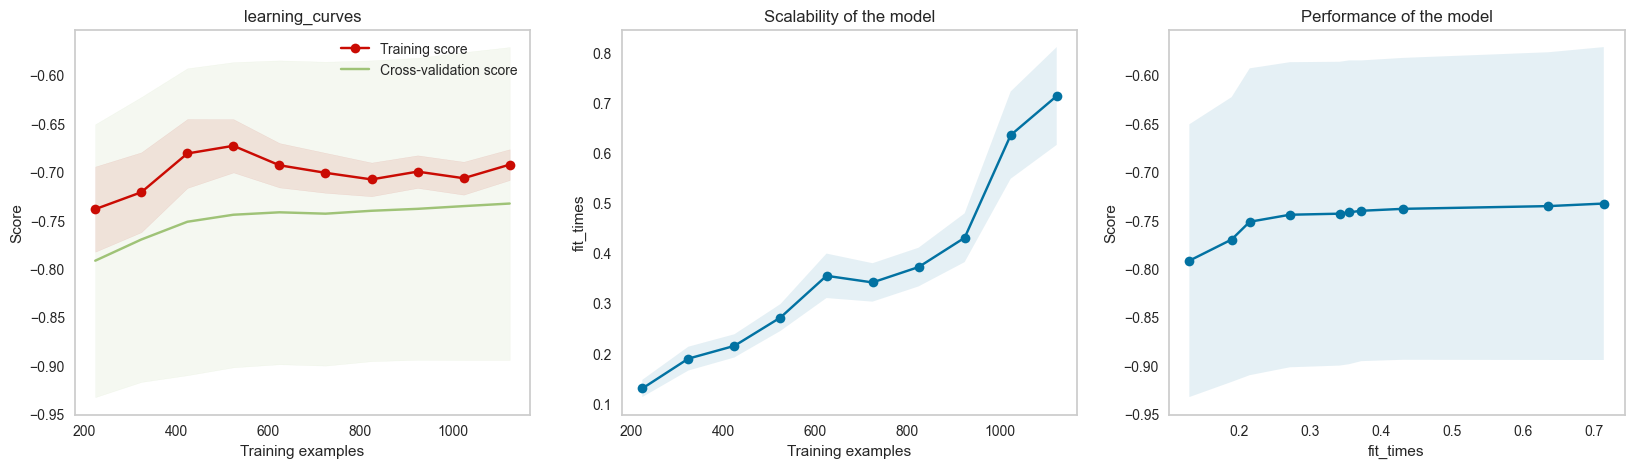

In [181]:
plot_learning_curve(
        best_ridge,
        "learning_curves",
        X_train_tr_qt_log_ridge,
        y_train_tr_qt,
        #axes=axes[:,i],
        cv=kfold,
        n_jobs=4,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.2, 1.0, 10)
    );
save_fig("Courbes d'apprentissage du meilleur modèle Ridge")

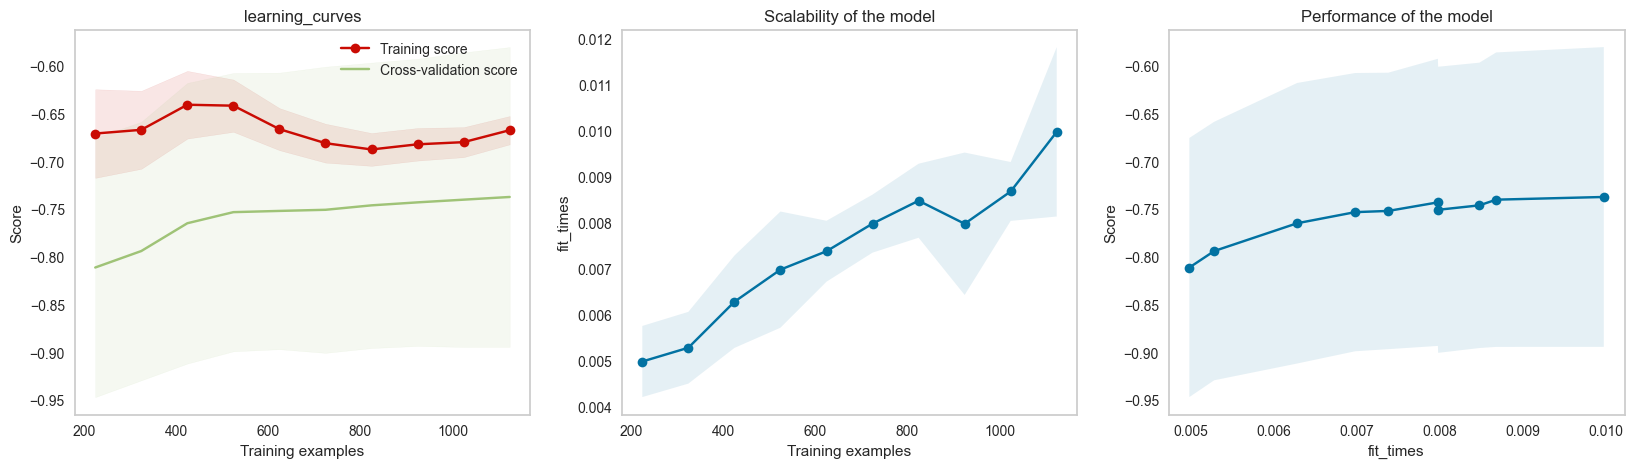

In [182]:
plot_learning_curve(
        ridge_reg,
        "learning_curves",
        X_train_tr_qt_log_xgb,
        y_train_tr_qt,
        #axes=axes[:,i],
        cv=kfold,
        n_jobs=4,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.2, 1.0, 10)
    );
save_fig("Courbes d'apprentissage dmodèle Ridge par défaut")

Nous pouvons voir que l'ajustement des hyperparamètres nous a permis de réduire l'overfitting présent dans le modèle de base (nous pouvons voir que les courbes d'apprentissage sont plus proches pour le modèle ajusté), et également de réduire le **fit_times** du modèle avant atteinte du plateau de performance (le Score n'évolue plus).

Un moyen d'améliorer notre modèle serait d'augmenter le nombre d'observations d'entraînement, par exemple en prenant toutes les observations du jeu de données plutôt qu'en restreignant nos validations croisées au jeu d'entraînement suite au *train_test_split*.

## Modèle XGBoost

In [183]:
param_xgb = {
    "max_depth": range(3,10,2),
    "min_child_weight":range(1,6,2),
}

xgb_search = GridSearchCV(xgb, param_xgb, scoring='neg_root_mean_squared_error', cv=kfold)

xgb_search.fit(X_train_tr_qt_log_xgb, y_train_tr_qt)
xgb_search.best_score_, xgb_search.best_params_, display(cross_val_final(X_train_tr_qt_log_xgb, y_train_tr_qt, xgb_search.best_estimator_, 'XGBoost'))

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
XGBoost  940773.17  3943921783493.359863  1848586.59    0.53   1.6    0.17   

           R²  
XGBoost  0.59

(-0.7627967140925064, {'max_depth': 3, 'min_child_weight': 5}, None)

In [184]:
param_xgb = {
    "max_depth": range(1,4),
    "min_child_weight":range(5,10,2)
}

xgb_search = GridSearchCV(xgb, param_xgb, scoring='neg_root_mean_squared_error', cv=kfold)

xgb_search.fit(X_train_tr_qt_log_xgb, y_train_tr_qt)
xgb_search.best_score_, xgb_search.best_params_, display(cross_val_final(X_train_tr_qt_log_xgb, y_train_tr_qt, xgb_search.best_estimator_, 'XGBoost'))

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
XGBoost  946261.28  3774674582168.490234  1868121.94    0.51  1.49    0.13   

           R²  
XGBoost  0.58

(-0.7516707515536087, {'max_depth': 2, 'min_child_weight': 9}, None)

In [185]:
param_xgb = {
    "max_depth": [2],
    "min_child_weight":range(9,15,1)
}

xgb_search = GridSearchCV(xgb, param_xgb, scoring='neg_root_mean_squared_error', cv=kfold)

xgb_search.fit(X_train_tr_qt_log_xgb, y_train_tr_qt)
xgb_search.best_score_, xgb_search.best_params_, display(cross_val_final(X_train_tr_qt_log_xgb, y_train_tr_qt, xgb_search.best_estimator_, 'XGBoost'))

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
XGBoost  946261.28  3774674582168.490234  1868121.94    0.51  1.49    0.14   

           R²  
XGBoost  0.58

(-0.7516707515536087, {'max_depth': 2, 'min_child_weight': 9}, None)

In [186]:
param_xgb = {
    "max_depth": [2],
    "min_child_weight":[9],
    "gamma":np.arange(0.1, 1, 0.1)
}

xgb_search = GridSearchCV(xgb, param_xgb, scoring='neg_root_mean_squared_error', cv=kfold)

xgb_search.fit(X_train_tr_qt_log_xgb, y_train_tr_qt)
xgb_search.best_score_, xgb_search.best_params_, display(cross_val_final(X_train_tr_qt_log_xgb, y_train_tr_qt, xgb_search.best_estimator_, 'XGBoost'))

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
XGBoost  928119.45  3533282117128.859863  1797634.55    0.55  1.49    0.14   

           R²  
XGBoost  0.61

(-0.746615652511783,
 {'gamma': 0.8, 'max_depth': 2, 'min_child_weight': 9},
 None)

In [187]:
param_xgb = {
    "max_depth": [2],
    "min_child_weight":[9],
    "gamma":np.arange(0.75, 0.85, 0.02)
}

xgb_search = GridSearchCV(xgb, param_xgb, scoring='neg_root_mean_squared_error', cv=kfold)

xgb_search.fit(X_train_tr_qt_log_xgb, y_train_tr_qt)
xgb_search.best_score_, xgb_search.best_params_, display(cross_val_final(X_train_tr_qt_log_xgb, y_train_tr_qt, xgb_search.best_estimator_, 'XGBoost'))

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
XGBoost  926585.96  3526859879812.419922  1796171.68    0.55  1.48    0.12   

           R²  
XGBoost  0.61

(-0.7459617191742713,
 {'gamma': 0.81, 'max_depth': 2, 'min_child_weight': 9},
 None)

In [188]:
param_xgb = {
    "max_depth": [3],
    "min_child_weight":[1],
    "gamma":[0.81],
    "subsample":np.arange(0.1, 1, 0.2),
    "colsample_bytree":np.arange(0.1, 1, 0.2)
}

xgb_search = GridSearchCV(xgb, param_xgb, scoring='neg_root_mean_squared_error', cv=kfold)

xgb_search.fit(X_train_tr_qt_log_xgb, y_train_tr_qt)
xgb_search.best_score_, xgb_search.best_params_, display(cross_val_final(X_train_tr_qt_log_xgb, y_train_tr_qt, xgb_search.best_estimator_, 'XGBoost'))

MAE                   MSE        RMSE adj. R² RMSLE TT(sec)  \
XGBoost  845695.25  2405182629716.470215  1508743.23    0.67  1.58    0.13   

           R²  
XGBoost  0.71

(-0.7398952472806457,
 {'colsample_bytree': 0.5000000000000001,
  'gamma': 0.81,
  'max_depth': 3,
  'min_child_weight': 1,
  'subsample': 0.9000000000000001},
 None)

In [189]:
param_xgb = {
    "max_depth": [3],
    "min_child_weight":[1],
    "gamma":[0.66],
    "subsample":np.arange(0.9, 1.2, 0.5),
    "colsample_bytree":np.arange(0.3, 0.5, 0.05)
}


xgb_search = GridSearchCV(xgb, param_xgb, scoring='neg_root_mean_squared_error', cv=kfold)

xgb_search.fit(X_train_tr_qt_log_xgb, y_train_tr_qt)
xgb_search.best_score_, xgb_search.best_params_, display(cross_val_final(X_train_tr_qt_log_xgb, y_train_tr_qt, xgb_search.best_estimator_, 'XGBoost'))

MAE                  MSE        RMSE adj. R² RMSLE TT(sec)  \
XGBoost  830807.91  2335758546240.77002  1478518.21    0.68  1.55    0.13   

           R²  
XGBoost  0.72

(-0.7454373083771719,
 {'colsample_bytree': 0.44999999999999996,
  'gamma': 0.66,
  'max_depth': 3,
  'min_child_weight': 1,
  'subsample': 0.9},
 None)

In [190]:
best_xgb = XGBRegressor(**{'colsample_bytree': 0.45,
  'gamma': 0.66,
  'max_depth': 3,
  'min_child_weight': 1,
  'subsample': 0.9})

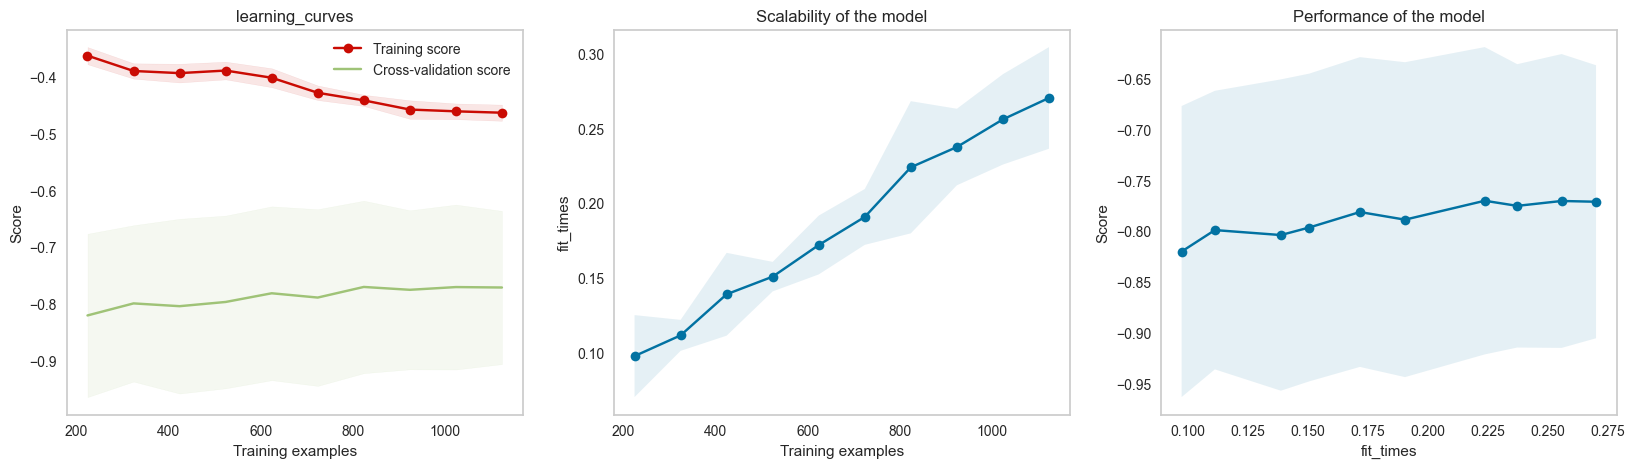

In [191]:
plot_learning_curve(
        best_xgb,
        "learning_curves",
        X_train_tr_qt_log_xgb,
        y_train_tr_qt,
        #axes=axes[:,i],
        cv=kfold,
        n_jobs=4,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.2, 1.0, 10)
    );
save_fig("Courbes d'apprentissage du meilleur modèle XGBoost")

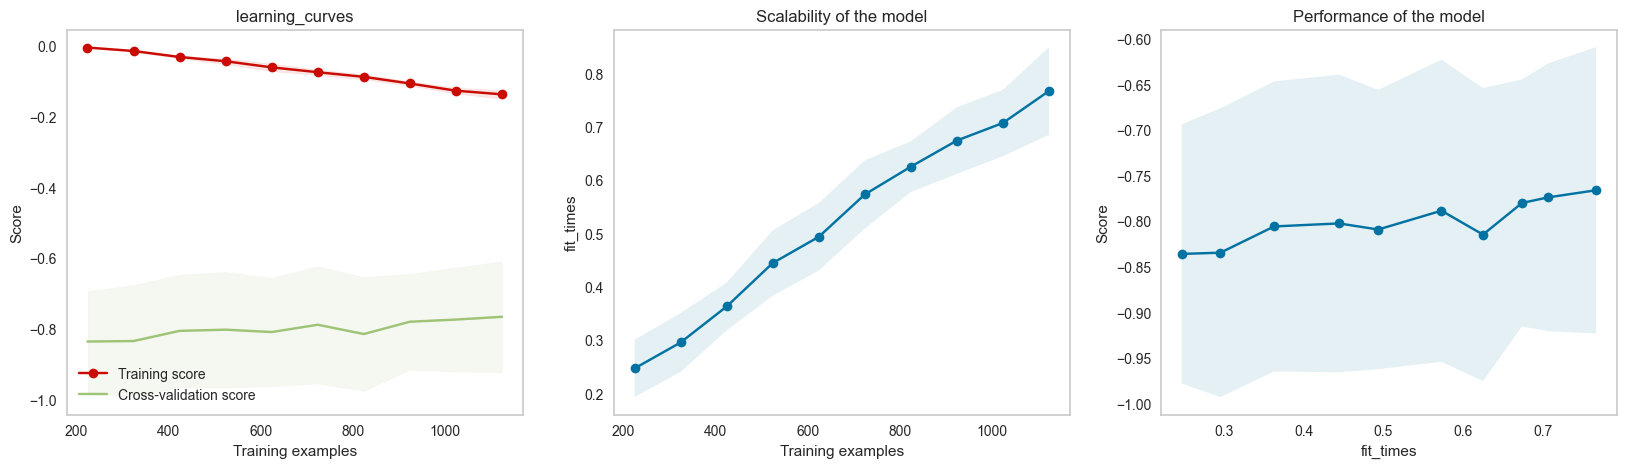

In [192]:
plot_learning_curve(
        xgb,
        "learning_curves",
        X_train_tr_qt_log_xgb,
        y_train_tr_qt,
        #axes=axes[:,i],
        cv=kfold,
        n_jobs=4,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.2, 1.0, 10)
    );
save_fig("Courbes d'apprentissage du modèle XGBoost par défaut")

Nous pouvons voir que l'ajustement des hyperparamètres a fortement réduit l'overfitting présent au départ, mais sans améliorer significativement les performances de notre modèle en validation croisée.

Pour ce modèle, nous avons beosin de plus d'observations d'entraînement pour espérer améliorer les performances.

En outre, le plus gros gap de performance que nous avons réussi à obtenir est suite à notre travail de **feature engineering**, suite auquel, c'est le modèle **XGBoost** avec ses paramètres par défaut qui est le plus indiqué.

In [193]:
cross_val_final(X_train_tr_qt_log_xgb, y_train_tr_qt, xgb, 'XGBoost')

MAE              MSE        RMSE adj. R² RMSLE TT(sec)    R²
XGBoost  825455.43  2120284505178.5  1410378.33     0.7  1.69    0.26  0.74

# Importance des variables du meilleur modèle : RIDGE

In [194]:
from sklearn.pipeline import make_pipeline
best_ridge = make_pipeline(ft_prepro_qt_log_ridge, ridge_search.best_estimator_)
best_ridge.fit(X_train_ridge, y_train_tr_qt)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('log_num_ft',
                                                  FunctionTransformer(accept_sparse=False,
                                                                      check_inverse=True,
                                                                      func=<function log_tr at 0x000002BBE26E6AF0>,
                                                                      inv_kw_args=None,
                                                                      inverse_func=None,
                                                                      kw_args=None,
                                                                      validate=False),
                                               

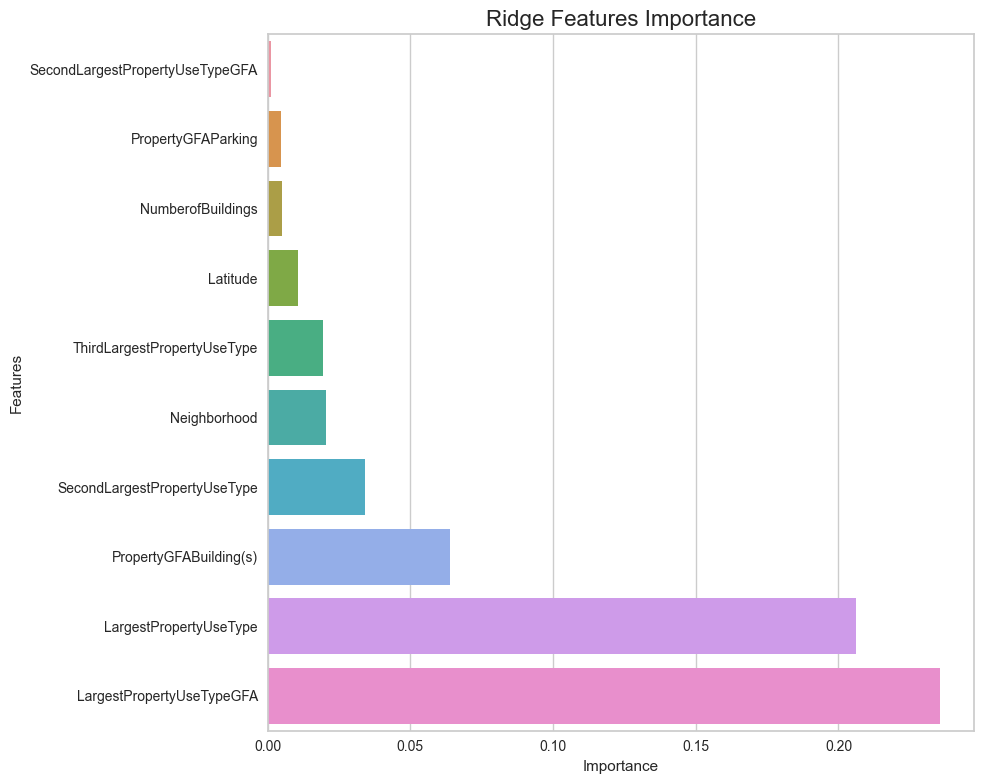

In [195]:
plot_features_importance(best_ridge, "Ridge", X_train_ridge, y_train_tr_qt, scoring='neg_root_mean_squared_error')

# Choix définitif du modèle

Le modèle nous ayant permis d'atteindre les meilleures performances dans notre objectif de prédiction de la consommation d'énergie des bâtiments de Seattle à partir de leurs variables structurelles est le modèle de régression **RIDGE**.

La variable **ENERGYSTARScore**, coûteuse à produire, ne permet pas d'améliorer les prédictions de notre variable cible et nous pourrons donc nous en passer pour les prochaines années.